# Fig3: OneK1K cis + trans

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from cigma import plot, util

[2025-11-23 15:59:47 - INFO] cffi mode is CFFI_MODE.ANY
[2025-11-23 15:59:47 - INFO] R home found: /home/minhuic/programs/anaconda3/envs/gxct/lib/R
[2025-11-23 15:59:47 - INFO] R library path: /apps/default/lib:/apps/default/lib:
[2025-11-23 15:59:47 - INFO] LD_LIBRARY_PATH: /apps/default/lib:/apps/default/lib:
[2025-11-23 15:59:47 - INFO] Default options to initialize R: rpy2, --quiet, --no-save
[2025-11-23 15:59:48 - INFO] Environment variable "PWD" redefined by R and overriding existing variable. Current: "/ess/home/home1/minhuic", R: "/gpfs/data/ukb-share/dahl/minhuic/GxCTMM/workflow/notebook"
[2025-11-23 15:59:48 - INFO] R is already initialized. No need to initialize.


In [2]:
# Load data
meta_f  = '../../data/Yazar2022Science/gene_meta.txt'
cis_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy'
trans_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/he.jk.npy'
jk_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.jk.npy'
P_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz'
n_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/n.final.gz'
joint_rare_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.min_maf0.01.max_maf0.05.npy'

meta = pd.read_table(meta_f, usecols=['feature', 'GeneSymbol', 'chr', 'start']).drop_duplicates()
cis = np.load(cis_f, allow_pickle=True).item()
trans = np.load(trans_f, allow_pickle=True).item()
jk = np.load(jk_f, allow_pickle=True).item()
P = pd.read_table(P_f, index_col=0)
cell_counts = pd.read_table(n_f, index_col=0)
cts = P.columns.to_list()

joint_rare = np.load(joint_rare_f, allow_pickle=True).item()
joint_rare_df = util.read_out(joint_rare, ['gene', 'free:hom_g2', 'free:v', 'free:hom_g2_b', 'free:v_b', 'free:hom_e2', 'free:w'])
joint_rare_df['free:g'] = joint_rare_df['free:hom_g2'] + joint_rare_df['free:v']
joint_rare_df['free:g_b'] = joint_rare_df['free:hom_g2_b'] + joint_rare_df['free:v_b']
joint_rare_df['specificity'] = joint_rare_df['free:v'] / joint_rare_df['free:g']
joint_rare_df['specificity_b'] = joint_rare_df['free:v_b'] / joint_rare_df['free:g_b']

p_cut = 0.05 / len(jk['gene'])

In [3]:
# jk
# Cumulate BP
def cumulate_bp(data):
    data_grouped = data.groupby(('chr'))
    cumulative_bp = 0
    ticks = []
    new_data = []
    for chrom, group in data_grouped:
        group['start_cum'] = group['start'] + cumulative_bp
        ticks.append(group['start_cum'].median())
        cumulative_bp = group['start_cum'].max()
        new_data.append(group)
    combined_data = pd.concat(new_data)
    return combined_data, ticks

jk_data = pd.DataFrame({'feature': jk['gene'], 'V': -np.log10(jk['p']['free']['V']), 'W': -np.log10(jk['p']['free']['W']),
                        'v_bar': np.diagonal(jk['free']['V'], axis1=1, axis2=2).mean(axis=1),
                        'specific_h2': jk['free']['specific_h2'],
                        'raw_p_beta': jk['p']['free']['ct_beta'], 
                        'var_beta': np.var(jk['free']['ct_beta'], axis=1)})
# sanity check
# assert np.array_equal(jk['gene'], iid_jk['gene'])

jk_data = meta.merge(jk_data).sort_values(['chr', 'start'])
jk_data, chr_ticks = cumulate_bp(jk_data)

jk_data['W'] = np.clip(jk_data['W'], 0, 100) # NOTE

In [4]:
# Full
full_V_diag = np.diagonal(cis['full']['V'], axis1=1, axis2=2)
full_W_diag = np.diagonal(cis['full']['W'], axis1=1, axis2=2)
full_V = cis['full']['V']
full_W = cis['full']['W']
full_V_mean = np.mean(full_V, axis=0)
full_W_mean = np.mean(full_W, axis=0)

full_h2 = np.diag(full_V_mean) / np.diag(full_V_mean + full_W_mean)
full_V_cor = full_V_mean / np.sqrt(np.outer(np.diag(full_V_mean), np.diag(full_V_mean)))
full_W_cor = full_W_mean / np.sqrt(np.outer(np.diag(full_W_mean), np.diag(full_W_mean)))
full_cor = full_V_cor.copy()
upper_mask = np.triu(np.ones_like(full_cor, dtype=bool))
full_cor[upper_mask] = full_W_cor[upper_mask]
np.fill_diagonal(full_cor, full_h2)
# print(full_h2)
# print(full_V_cor)
# print(full_W_cor)
print(full_cor)
# print(full_V_mean)
# print(np.sort(full_cor[~upper_mask]))

[[0.13663346 0.67680584 0.08855391 0.07494847 0.10820198 0.07991739
  0.1259586 ]
 [0.91155159 0.11607869 0.13228535 0.11718844 0.17866772 0.1519203
  0.16289439]
 [0.54652643 0.58079238 0.16831882 0.79586271 0.38461431 0.71700552
  0.31675613]
 [0.54538102 0.58697303 0.9649645  0.21764866 0.3229814  0.77300039
  0.24812071]
 [0.54062978 0.57497795 0.80532498 0.77824702 0.14055099 0.38912364
  0.62500377]
 [0.56468999 0.59598379 0.94305086 0.97979731 0.82281827 0.15311877
  0.2654262 ]
 [0.45078101 0.4805234  0.64482393 0.610487   0.85319793 0.65351165
  0.12961006]]


9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared: 0.10136985303533792; Trans specific: 0.14850067668957345;
Trans specific (%): 0.5943104889282522
Cis specific sd: 0.012605266228707767
Trans specific sd: 0.045853393086214965
Trans (%): 0.8837440884972985
[[0.00124157 0.00135672]
 [0.02288203 0.02080401]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = 0.2831981664704886 with p = 0.001
cis h2 se: 0.0010829642777309947
trans h2 se: 0.0215255725743338
4625 genes with g > 0 in all windows
hom_g2
window
5       0.046992
20      0.050506
50      0.054102
100     0.056943
300     0.060275
500     0.060531
700     0.060476
1000    0.060957
2000    0.061141
Name: hom_g2, dtype: float64
v
window
5       0.025498
20      0.028225
50      0.031614
100     0.034022
300     0.038222
500     0.040497
700     0.041591
1000  

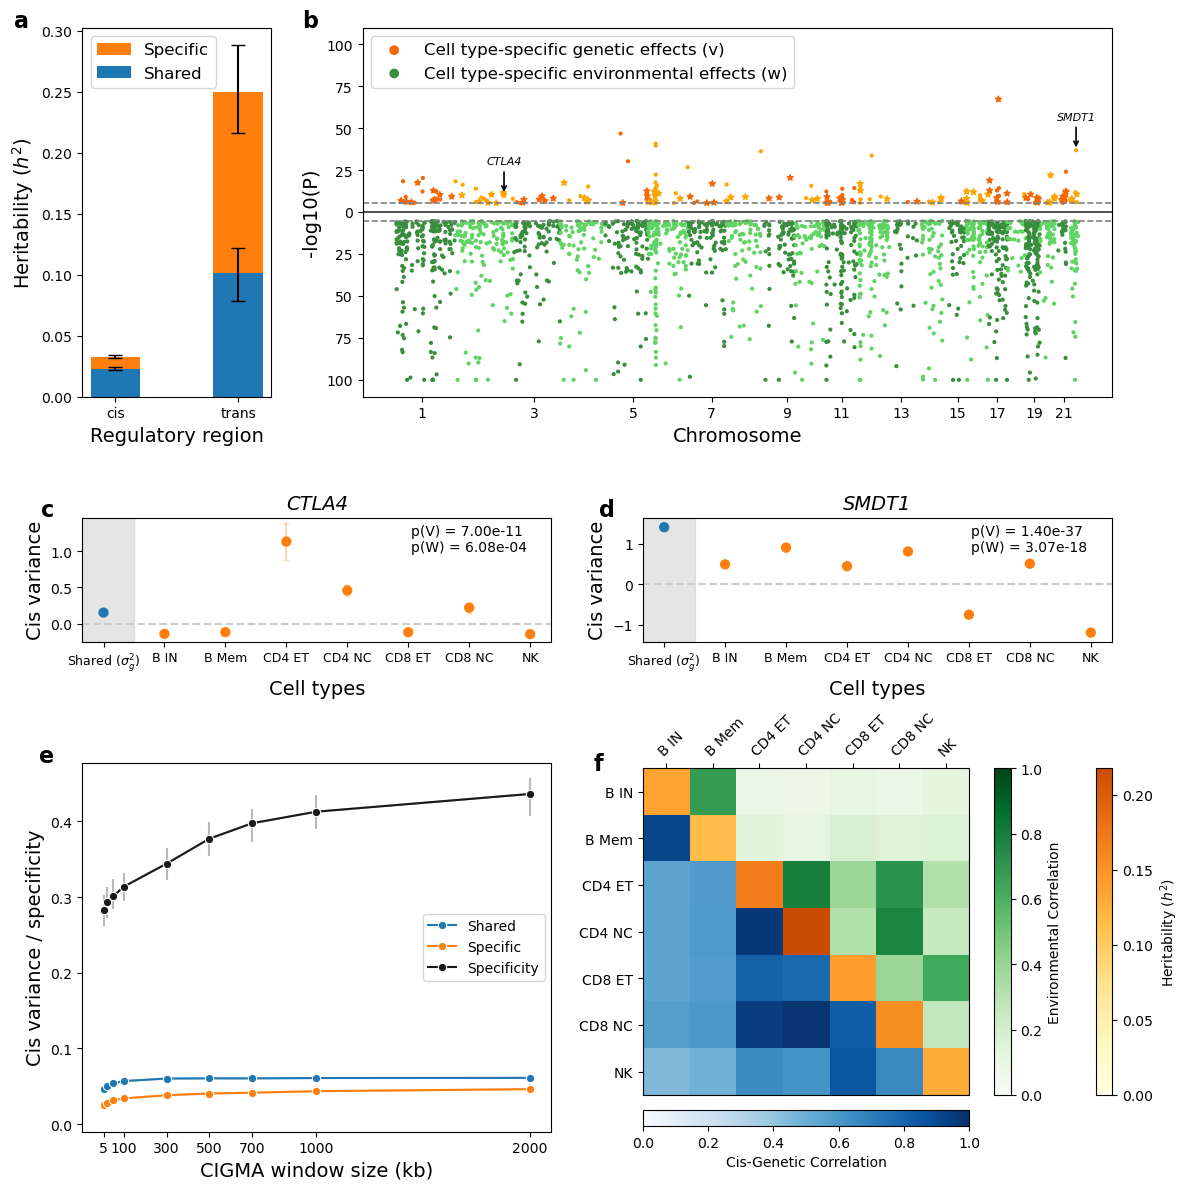

In [8]:
# fig
colors = sns.color_palette()
fs = 12
# sns.set_style('dark')

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(5, 4, figure=fig)

# axis1: cis Transcriptome-wide + Trans transcriptome-wide
ax = fig.add_subplot(gs[:2, 0])
dif, p = plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4)  # NOTE: filter bio_var > 0
ax.legend(loc='upper left', reverse=True, fontsize=12)
ax.set_ylabel('Heritability ($h^2$)', fontsize=fs+2)
ax.set_xlabel('Regulatory region', fontsize=fs+2)
plt.xticks(fontsize=10)
print(f'trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = {dif} with p = {p}')
ax.text(-0.28, 1.05, 'a', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

# se for cis and trans h2
tmp_df = util.read_out(trans, ['free:hom_g2', 'free:v', 'free:hom_g2_b', 'free:v_b', 'free:hom_e2', 'free:w'])
tmp_df['bio_var'] = tmp_df['free:hom_g2_b'] + tmp_df['free:v_b'] + tmp_df['free:hom_e2'] + tmp_df['free:w'] + tmp_df['free:hom_g2'] + tmp_df['free:v']
tmp_df = tmp_df.loc[tmp_df['bio_var'] > 0, :]
# print(tmp_df.shape[0])
# print(np.median((tmp_df['free:hom_g2'] + tmp_df['free:v']) / tmp_df['bio_var']))
se = stats.bootstrap((tmp_df['free:hom_g2'] + tmp_df['free:v'], tmp_df['bio_var']), lambda x, y: np.median(x / y),
                            vectorized=False, paired=True, random_state=np.random.default_rng(123),
                            ).standard_error
print('cis h2 se:', se)

# print(np.median((tmp_df['free:hom_g2_b'] + tmp_df['free:v_b']) / tmp_df['bio_var']))
se = stats.bootstrap((tmp_df['free:hom_g2_b'] + tmp_df['free:v_b'], tmp_df['bio_var']), lambda x, y: np.median(x / y),
                            vectorized=False, paired=True, random_state=np.random.default_rng(123),
                            ).standard_error
print('trans h2 se:', se)



# axis4: Full
ax = fig.add_subplot(gs[3:, 2:])
mask_diagonal = np.eye(full_cor.shape[0], dtype=bool)
mask_lower = np.tril(np.ones_like(full_cor, dtype=bool), -1)
mask_upper = np.triu(np.ones_like(full_cor, dtype=bool), 1)
# cmap_diag = plt.cm.Grays
# cmap_lower = mcolors.LinearSegmentedColormap.from_list("YlOr", plt.cm.YlOrBr(np.linspace(0, 0.75, 256)))
cmap_diag = mcolors.LinearSegmentedColormap.from_list("YlOr", plt.cm.YlOrBr(np.linspace(0, 0.75, 256)))
cmap_lower = plt.cm.Blues
cmap_upper = plt.cm.Greens
diagonal_img = ax.imshow(np.ma.masked_where(~mask_diagonal, full_cor), cmap=cmap_diag, interpolation='none', vmin=0)
lower_img = ax.imshow(np.ma.masked_where(~mask_lower, full_cor), cmap=cmap_lower, interpolation='none', vmin=0, vmax=1)
upper_img = ax.imshow(np.ma.masked_where(~mask_upper, full_cor), cmap=cmap_upper, interpolation='none', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax_upper = divider.append_axes("right", size="5%", pad=0.25)
cax_diagonal = divider.append_axes("right", size="5%", pad=0.85)
cax_lower = divider.append_axes("bottom", size="5%", pad=0.15)

cbar_lower = fig.colorbar(lower_img, cax=cax_lower, orientation='horizontal')
cbar_lower.set_label('Cis-Genetic Correlation')
cbar_diag = fig.colorbar(diagonal_img, cax=cax_diagonal)
cbar_diag.set_label('Heritability ($h^2$)')
cbar_diag.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
cbar_upper = fig.colorbar(upper_img, cax=cax_upper)
cbar_upper.set_label('Environmental Correlation')

ax.set_xticks(np.arange(full_cor.shape[1]))
ax.set_yticks(np.arange(full_cor.shape[0]))
ax.set_xticklabels(cts)
ax.set_yticklabels(cts)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
ax.text(-0.12, 1.05, 'f', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


# axis5: window size
ax = fig.add_subplot(gs[3:, :2])

windows = [5, 20, 50, 100, 300, 700, 1000, 2000]

window_dfs = {}
for window in windows:
    out_f = f'../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/cis_window_{window}000/he.free.jk.npy'
    tmp_out = np.load(out_f, allow_pickle=True).item()
    window_dfs[window] = util.read_out(tmp_out, ['gene','free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v'})
    window_dfs[window]['g'] = window_dfs[window]['hom_g2'] + window_dfs[window]['v']
    window_dfs[window]['specificity'] = window_dfs[window]['v'] / window_dfs[window]['g']

tmp_out_df = util.read_out(jk, ['gene','free:hom_g2', 'free:v', 'p:free:hom_g2', 'p:free:V']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v'})
tmp_out_df['g'] = tmp_out_df['hom_g2'] + tmp_out_df['v']
tmp_out_df['specificity'] = tmp_out_df['v'] / tmp_out_df['g']

# merge all windows
df = tmp_out_df.loc[tmp_out_df['g'] > 0]

for window in windows:
    tmp_df = window_dfs[window]
    tmp_df = tmp_df.loc[tmp_df['g'] > 0, ['gene', 'g', 'specificity', 'hom_g2', 'v']]
    df = df.merge(tmp_df, on='gene', suffixes=('', f'_{window}'))
df = df.rename(columns={'hom_g2': 'hom_g2_500', 'v': 'v_500', 'g': 'g_500', 'specificity': 'specificity_500'})
windows.append(500)
windows = sorted(windows)
print(df.shape[0], 'genes with g > 0 in all windows')

for x in ['hom_g2', 'v', 'specificity']:
    if x == 'hom_g2':
        color = colors[0]
        label = 'Shared'
        estimator = 'mean'
    elif x == 'v':
        color = colors[1]
        label = 'Specific'
        estimator = 'mean'
    elif x == 'specificity':
        color = '0.1'
        label = 'Specificity'
        estimator = 'median'
    tmp_df = df.copy()
    melt_df = tmp_df.melt(id_vars=['gene'], value_vars=[f'{x}_{w}' for w in windows],
                    var_name='window', value_name=x)
    melt_df['window'] = melt_df['window'].str.replace(f'{x}_', '')
    melt_df['window'] = melt_df['window'].astype(int)
    print(x)
    if x in ['hom_g2', 'v']:
        print(melt_df.groupby('window')[x].mean())
    else:
        print(melt_df.groupby('window')[x].median())

    # all genes
    sns.lineplot(data=melt_df, x='window', y=x, err_style='bars',
                    marker=False, estimator=estimator, alpha=.3, color=color)
    sns.lineplot(data=melt_df, x='window', y=x, errorbar=None,
                    marker='o', estimator=estimator, label=label, color=color)

# change x ticks to windows
xticks = windows.copy()
xticks.remove(20)
xticks.remove(50)
plt.xticks(ticks=xticks, labels=[str(x0) for x0 in xticks])
plt.xlabel('CIGMA window size (kb)', fontsize=fs+2)
plt.ylabel('Cis variance / specificity', fontsize=fs+2)
# plt.grid()
plt.legend(loc='center right')
plt.ylim(bottom=-.01)
ax.text(-0.06, 1.05, 'e', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


# axis2: Significance test
ax = fig.add_subplot(gs[:2, 1:])
light_dark_green = mcolors.ListedColormap(["orange", "#f56607"])  # '#a05200' is a darker shade than 'darkorange'
light_dark_blue = mcolors.ListedColormap(["#5fd463", '#388e3c'])  # lighter green and dark green
cut = -np.log10(0.05 / jk_data.shape[0])
print(f'significance level: (0.05 / n_tests) = ({0.05}/{jk_data.shape[0]}) = {0.05/jk_data.shape[0]:.2e}')
v = 'V'
w = 'W'
sig_V = jk_data.loc[jk_data[v] > cut, :]
sig_W = jk_data.loc[jk_data[w] > cut, :]
sig_V_only = jk_data.loc[(jk_data[v] > cut) & (jk_data[w] < cut), :]
print(sig_V.columns, sig_V.shape, sig_V_only.shape, sig_W.shape)
ax.scatter(sig_V['start_cum'], sig_V[v], c=sig_V['chr'] % 2, cmap=light_dark_green, s=4, label='Cell type-specific genetic effects (v)')
ax.scatter(sig_V_only['start_cum'], sig_V_only[v], c=sig_V_only['chr'] % 2, cmap=light_dark_green, marker='*', s=20)
ax.scatter(sig_W['start_cum'], -sig_W[w], c=sig_W['chr'] % 2, cmap=light_dark_blue, s=4, label='Cell type-specific environmental effects (w)')
ax.set_xticks(chr_ticks[::2])
ax.set_xticklabels(jk_data['chr'].unique()[::2])
ax.set_xlabel('Chromosome', fontsize=fs+2)
ax.set_ylabel('-log10(P)', fontsize=fs+2)
yticks = ax.get_yticks()
ytick_labels = [f"{abs(int(tick))}" for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.axhline(0, color='0.2', lw=1.2, ls='-')
ax.axhline(cut, color='0.5', lw=1.2, ls='--')
ax.axhline(-cut, color='0.5', lw=1.2, ls='--')
ax.set_ylim(-110, 110)
ax.legend(loc='upper left', markerscale=3, fontsize=fs)
ax.text(-0.06, 1.05, 'b', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

###### add gene name
genenames = ['CTLA4', 'SMDT1']
sig_V_genes = sig_V.loc[sig_V['GeneSymbol'].isin(genenames), :]
print(sig_V_genes)
for index, row in sig_V_genes.iterrows():
    gene = row['feature']
    genename = row['GeneSymbol']
    ax.annotate(genename, (row['start_cum'], row[v]), (row['start_cum'], row[v]+20), fontsize=8, fontstyle='italic',
                arrowprops={'edgecolor': 'black', 'arrowstyle': '->', 'lw': 1.2},
                ha='center', va='center')

# axis4: Example cis gene or two + Example trans gene or two
genenames = ['CTLA4', 'SMDT1']
idx = ['c', 'd']
genes = meta.loc[meta['GeneSymbol'].isin(genenames), 'feature'].to_list()
# sig_V_only = sig_V_only.sort_values(v, ascending=False)
for i, ax in enumerate([fig.add_subplot(gs[2, :2]), fig.add_subplot(gs[2, 2:])]):
    # gene = sig_V['feature'].to_list()[i]
    # gene = sig_V_only['feature'].to_list()[i]
    gene = genes[i]
    genename = meta.loc[meta['feature'] == gene]
    index = np.where(jk_data['feature'] == gene)[0][0]
    assert genename.shape[0] == 1
    genename = genename['GeneSymbol'].to_list()[0]
    gene_homg2 = jk['free']['hom_g2'][index]
    gene_V = np.diag(jk['free']['V'][index])
    gene_std_hom_g2 = np.sqrt(jk['p']['free']['var_hom_g2'][index])
    gene_std_V = np.sqrt(np.diag(jk['p']['free']['var_V'][index]))
    gene_p_V = 10 ** (-1 * jk_data[v][index])
    gene_p_W = 10 ** (-1 * jk_data[w][index])
    gene_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_homg2] + gene_V.tolist(), 
                        'error': [gene_std_hom_g2] + gene_std_V.tolist()})
    print(gene_df)
    sns.scatterplot(data=gene_df, palette=[colors[0]] + [colors[1]] * len(cts), x='variable', y='value', 
                    hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
    ax.axhline(0, ls='--', color='0.8', zorder=1)
    ax.text(0.70, 0.95, f'p(V) = {gene_p_V:.2e}', ha='left', va='top', transform=ax.transAxes)
    ax.text(0.70, 0.82, f'p(W) = {gene_p_W:.2e}', ha='left', va='top', transform=ax.transAxes)
    ax.legend().set_visible(False)
    ax.set_title(f'{genename}', fontsize=fs+2, fontstyle='italic')
    # ax.set_title(f'{genename} ({gene})', fontsize=14, fontstyle='italic')
    ax.set_xlabel('Cell types', fontsize=fs+2)
    ax.set_ylabel('Cis variance', fontsize=fs+2)
    ax.errorbar(gene_df['variable'], gene_df['value'], yerr=gene_df['error'], 
                    fmt='none', ecolor=colors[1], alpha=.3, capsize=2, zorder=1)
    ax.text(-0.06, 1.16, idx[i], transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


    # update labels
    current_labels = ax.get_xticklabels()
    new_labels = []
    for label in current_labels:
        label = label.get_text()
        if label == 'Shared':
            new_labels.append(r'Shared ($\sigma_g^2$)')
        else:
            # label = re.sub(' ', '\ ', label)
            # new_labels.append(f"$V_{{{label}}}$")
            new_labels.append(f"{label}")
    ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=9)

    # add shared background
    xmin, xmax = ax.get_xlim()
    ax.axvspan(xmin, 0.5, color='0.8', alpha=0.5, zorder=0)
    ax.set_xlim((xmin, xmax))


fig.tight_layout(w_pad=2)

# Transcriptiome-wide Distribution of shared and specific

/tmp/ipykernel_715832/1182324517.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, fontsize=9)


Shared      0.023002
Specific    0.010842
B IN        0.000831
B Mem       0.000894
CD4 ET      0.001422
CD4 NC      0.001345
CD8 ET      0.004305
CD8 NC      0.000172
NK          0.011938
Name: variance, dtype: float64
            Shared  Specific      B IN     B Mem    CD4 ET    CD4 NC  \
Shared    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Specific  0.413286  0.000000  0.000000  0.000000  0.000000  0.000000   
B IN      0.351408  0.875584  0.000000  0.000000  0.000000  0.000000   
B Mem     0.388231  0.854354  0.827383  0.000000  0.000000  0.000000   
CD4 ET   -0.011969 -0.141362 -0.284617 -0.283399  0.000000  0.000000   
CD4 NC   -0.078126 -0.255364 -0.372927 -0.386383  0.515875  0.000000   
CD8 ET   -0.095899 -0.065167 -0.238095 -0.262784 -0.002892 -0.054837   
CD8 NC   -0.084611 -0.140313 -0.277672 -0.292180  0.289466  0.522293   
NK        0.071067  0.238792 -0.102883 -0.112623 -0.067192 -0.117617   

            CD8 ET    CD8 NC   NK  
Shared    0.000000  0.0

/tmp/ipykernel_715832/1182324517.py:129: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


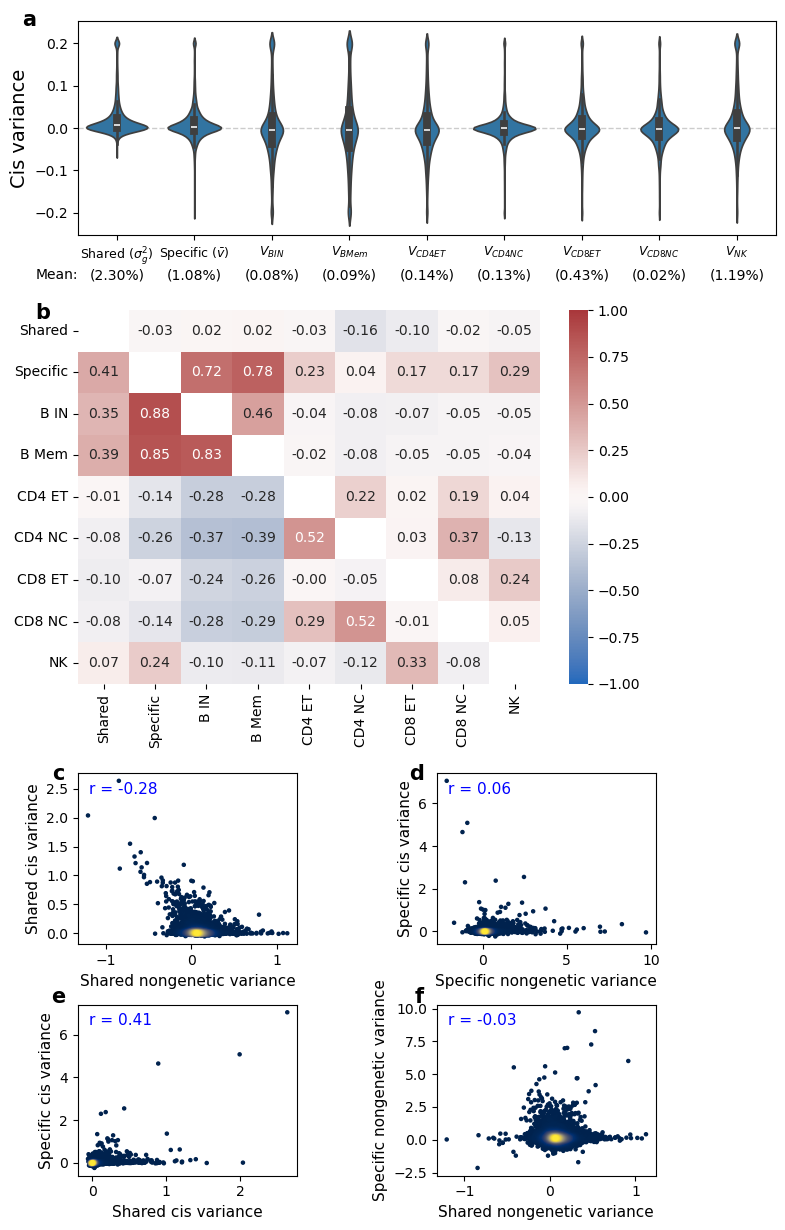

In [6]:
# collect data
tmp_gen_df = util.read_out(jk, ['free:hom_g2', 'free:v', 'free:V'])
tmp_gen_df = tmp_gen_df.rename(columns={'free:hom_g2': 'Shared', 'free:v': 'Specific'})
for i, ct in enumerate(cts):
    tmp_gen_df = tmp_gen_df.rename(columns={f'free:V_{i}': f'{ct}'})

tmp_env_df = util.read_out(jk, ['free:hom_e2', 'free:w', 'free:W'])
tmp_env_df = tmp_env_df.rename(columns={'free:hom_e2': 'Shared', 'free:w': 'Specific'})
for i, ct in enumerate(cts):
    tmp_env_df = tmp_env_df.rename(columns={f'free:W_{i}': f'{ct}'})

tmp_df = util.read_out(jk, ['free:hom_g2', 'free:v', 'free:V', 'free:hom_e2', 'free:w', 'free:W'])


order = ['Shared', 'Specific'] + cts
tmp_gen_df = tmp_gen_df[order]
tmp_env_df = tmp_env_df[order]
# print(tmp_gen_df.head())

# violinplot of variance components
colors = sns.color_palette()
fs=11

fig = plt.figure(figsize=(9, 15))
gs = gridspec.GridSpec(80, 6)

ax1 = fig.add_subplot(gs[0:15, :])
ax2 = fig.add_subplot(gs[20:46, :-1])
ax3 = fig.add_subplot(gs[52:64, 0:2])
ax4 = fig.add_subplot(gs[52:64, 3:5])
ax5 = fig.add_subplot(gs[68:80, 0:2])
ax6 = fig.add_subplot(gs[68:80, 3:5])


ax = ax1
df_var = tmp_gen_df.melt(var_name='component', value_name='variance')
df_var['variance'] = df_var['variance'].clip(-.2, .2)
sns.violinplot(x='component', y='variance', data=df_var, ax=ax, order=order)
ax.axhline(0, color='0.8', lw=1, ls='--', zorder=0)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Cis variance', fontsize=14)
# set x tick labels
# set x tick labels with LaTeX formatting for Shared and Specific
xticklabels = ax.get_xticklabels()
new = []
for label in xticklabels:
    if label.get_text() == 'Shared':
        new.append(r'Shared ($\sigma_g^2$)')
    elif label.get_text() == 'Specific':
        new.append(r'Specific ($\bar{v}$)')
    else:
        new.append(r'$V_{%s}$' % label.get_text())
xticklabels = new
ax.set_xticklabels(xticklabels, fontsize=9)

# add text of means at the bottom of each violin
means = df_var.groupby('component')['variance'].mean()
means = means.reindex(tmp_gen_df.columns)  # ensure the order is the same as the x-axis
print(means)
for i in range(len(means)):
    mean = means.iloc[i]
    ax.text(i, -.33, f'({mean * 100:.2f}%)', fontsize=10, va='top', ha='center')
ax.text(-0.5, -.33, 'Mean:', fontsize=10, va='top', ha='right')
ax.text(-0.06, 1.05, 'a', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

# heatmap of correlations
ax = ax2
# Compute correlation matrix for cell type-specific variance components
corr_gen_matrix = tmp_gen_df.corr()
corr_env_matrix = tmp_env_df.corr()
# zero out the strict upper triangle (leave diagonal)
upper_idx = np.triu_indices_from(corr_gen_matrix)
corr_gen_matrix.values[upper_idx] = 0
lower_idx = np.tril_indices_from(corr_env_matrix)
corr_env_matrix.values[lower_idx] = 0
corr_matrix = corr_gen_matrix + corr_env_matrix
np.fill_diagonal(corr_matrix.values, 0)
print(corr_gen_matrix)
print(corr_matrix)


# mask diagonal so it is not shown in the heatmap
mask_diagonal = np.eye(corr_matrix.shape[0], dtype=bool)
sns.heatmap(
    corr_matrix, annot=True, fmt='.2f', cmap='vlag', ax=ax,
    xticklabels=tmp_gen_df.columns, yticklabels=tmp_gen_df.columns, mask=mask_diagonal,
    vmin=-1, vmax=1
)

# ax.set_title('Correlations among cis variance components', fontsize=14)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=90, va="center", ha="right", rotation_mode="anchor")
ax.text(-0.06, 1.02, 'b', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


# scatter plots
ax = ax3
plot.scatter(tmp_df['free:hom_e2'], tmp_df['free:hom_g2'], s=5, heatscatter=True, ax=ax)
ax.set_xlabel('Shared nongenetic variance', fontsize=fs)
ax.set_ylabel('Shared cis variance', fontsize=fs)
corr = np.corrcoef(tmp_df['free:hom_e2'], tmp_df['free:hom_g2'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=ax.transAxes, fontsize=fs, color='b')
ax.text(-0.06, 1.05, 'c', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

ax = ax4
plot.scatter(tmp_df['free:w'], tmp_df['free:v'], s=5, heatscatter=True, ax=ax)
ax.set_xlabel('Specific nongenetic variance', fontsize=fs)
ax.set_ylabel('Specific cis variance', fontsize=fs)
corr = np.corrcoef(tmp_df['free:w'], tmp_df['free:v'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=ax.transAxes, fontsize=fs, color='b')
ax.text(-0.06, 1.05, 'd', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

ax = ax5
plot.scatter(tmp_df['free:hom_g2'], tmp_df['free:v'], s=5, heatscatter=True, ax=ax)
ax.set_xlabel('Shared cis variance', fontsize=fs)
ax.set_ylabel('Specific cis variance', fontsize=fs)
corr = np.corrcoef(tmp_df['free:hom_g2'], tmp_df['free:v'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=ax.transAxes, fontsize=fs, color='b')
ax.text(-0.06, 1.1, 'e', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

ax = ax6
plot.scatter(tmp_df['free:hom_e2'], tmp_df['free:w'], s=5, heatscatter=True, ax=ax)
ax.set_xlabel('Shared nongenetic variance', fontsize=fs)
ax.set_ylabel('Specific nongenetic variance', fontsize=fs)
corr = np.corrcoef(tmp_df['free:hom_e2'], tmp_df['free:w'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=ax.transAxes, fontsize=fs, color='b')
ax.text(-0.06, 1.1, 'f', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

fig.tight_layout()

# Identify cell types

(193, 9)
0    52
1    77
2    51
3    11
5     2
Name: count, dtype: int64
B IN B Mem 18
B IN CD4 ET 2
B IN CD4 NC 2
B IN CD8 ET 2
B IN CD8 NC 2
B IN NK 1
B Mem CD4 ET 2
B Mem CD4 NC 2
B Mem CD8 ET 0
B Mem CD8 NC 2
B Mem NK 0
CD4 ET CD4 NC 14
CD4 ET CD8 ET 0
CD4 ET CD8 NC 11
CD4 ET NK 0
CD4 NC CD8 ET 0
CD4 NC CD8 NC 20
CD4 NC NK 1
CD8 ET CD8 NC 1
CD8 ET NK 23
CD8 NC NK 1
p:free:vc_0    29
p:free:vc_1    18
p:free:vc_2    14
p:free:vc_3    58
p:free:vc_4    30
p:free:vc_5    22
p:free:vc_6    51
dtype: int64
B IN       85.734914
B Mem      50.794181
CD4 ET     64.401940
CD4 NC    480.100216
CD8 ET    207.192888
CD8 NC    139.053879
NK        162.364224
dtype: float64
0    52
1    77
2    51
3    11
5     2
Name: count, dtype: int64


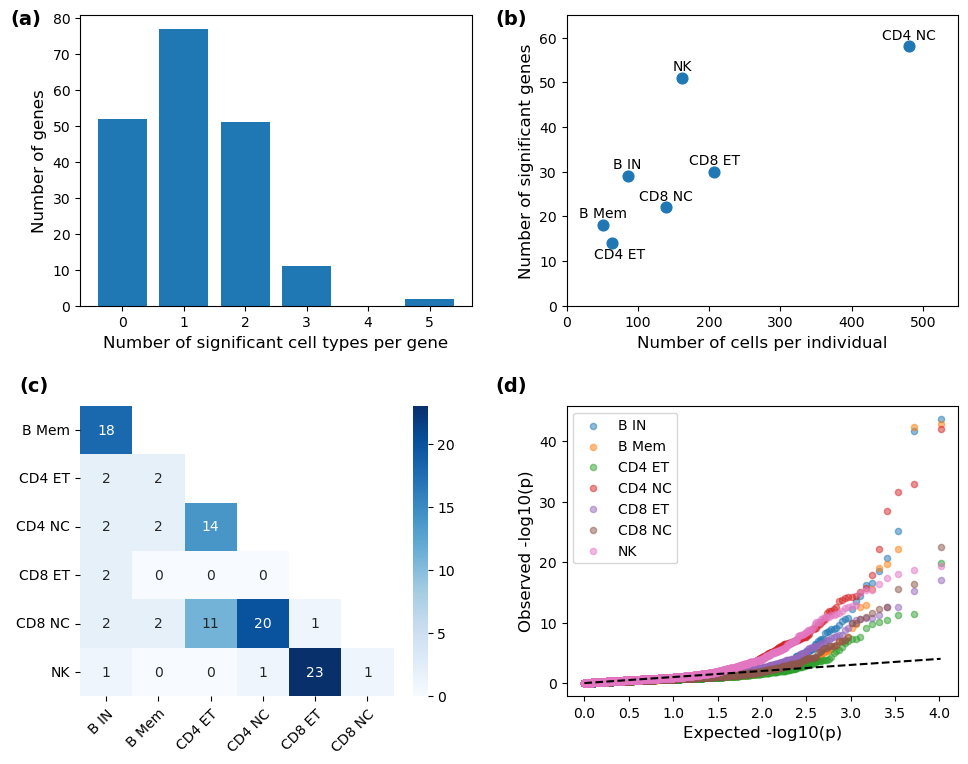

In [7]:
tmp_df = util.read_out(jk, ['gene', 'p:free:V', 'p:free:vc'])
C = len(cts)

tmp_sig_df = tmp_df.loc[tmp_df['p:free:V'] < p_cut]
# save sig genes in file
tmp_sig_df_copy = tmp_sig_df.copy()
tmp_sig_df_copy = tmp_sig_df_copy.merge(meta, left_on='gene', right_on='feature')
# print(tmp_sig_df_copy.shape)
# print(tmp_sig_df_copy.columns)
for i, ct in enumerate(cts):
    tmp_sig_df_copy[f'{ct}'] = (tmp_sig_df_copy[f'p:free:vc_{i}'] < p_cut).astype(int)
tmp_sig_df_copy[['gene', 'GeneSymbol'] + [f'{ct}' for ct in cts]].to_csv('../../significant_cts.txt', sep='\t', index=False)

print(tmp_sig_df.shape)
# number of significant cell types per gene
sig_cts = (tmp_sig_df[[f'p:free:vc_{i}' for i in range(C)]] < p_cut).sum(axis=1)
print(sig_cts.value_counts().sort_index())
# common significant genes for each pair of cell types
# common = np.zeros((C, C))
common = np.zeros((C, C), dtype=int)
for i in range(C):
    for j in range(i + 1, C):
        ct1 = cts[i]
        ct2 = cts[j]
        intersection = tmp_sig_df.loc[(tmp_sig_df[f'p:free:vc_{i}'] < p_cut) & (tmp_sig_df[f'p:free:vc_{j}'] < p_cut)].shape[0]
        # union = tmp_df.loc[(tmp_df['p:free:V'] < p_cut) & ((tmp_df[f'p:free:vc_{i}'] < p_cut) | (tmp_df[f'p:free:vc_{j}'] < p_cut))].shape[0]
        # common[j, i] = intersection / union if union > 0 else 0  # Jaccard index
        common[j, i] = intersection
        print(ct1, ct2, common[j, i])
common = common[1:, :(C-1)]

# number of significant genes per cell type
sig_genes = (tmp_sig_df[[f'p:free:vc_{i}' for i in range(C)]] < p_cut).sum(axis=0)
print(sig_genes)

# cell counts
cell_counts_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/n.final.gz'
cell_counts = pd.read_table(cell_counts_f, index_col=0)
cell_counts_per_ind = cell_counts.mean(axis=0)
print(cell_counts_per_ind)

# plot two bar plots for sig_cts and sig_genes
# bar plots for sig_cts and sig_genes
counts = sig_cts.value_counts().sort_index()
print(counts)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# left: number of significant cell types per gene
axes[0, 0].bar(counts.index, counts.values)
axes[0, 0].set_xlabel('Number of significant cell types per gene', fontsize=12)
axes[0, 0].set_ylabel('Number of genes', fontsize=12)
axes[0, 0].text(-0.1, 1.02, '(a)', transform=axes[0, 0].transAxes, va='top', ha='right', fontsize=14, fontweight='bold')

# right: cell counts vs number of significant genes per cell type
ax = axes[0, 1]
sig_genes_ct = sig_genes.copy()
sig_genes_ct.index = [cts[int(i.split('_')[-1])] for i in sig_genes_ct.index]
ax.scatter(cell_counts_per_ind.loc[sig_genes_ct.index], sig_genes_ct.values, s=60)
for i, ct in enumerate(sig_genes_ct.index):
    if ct != 'CD4 ET':
        ax.text(
            cell_counts_per_ind.loc[ct],
            sig_genes_ct.values[i] + 1,
            ct,
            fontsize=10,
            ha='center',
            va='bottom'
        )
    else:
        ax.text(
            cell_counts_per_ind.loc[ct] + 10,
            sig_genes_ct.values[i] - 1,
            ct,
            fontsize=10,
            ha='center',
            va='top'
        )

ax.set_xlabel('Number of cells per individual', fontsize=12)
ax.set_ylabel('Number of significant genes', fontsize=12)
ax.set_xlim(0, 550)
ax.set_ylim(0, 65)
ax.text(-0.1, 1.02, '(b)', transform=ax.transAxes, va='top', ha='right', fontsize=14, fontweight='bold')

# bottom: heatmap of common significant genes between cell type pairs
ax = axes[1, 0]
# Plot only the lower triangle (including the diagonal) of the matrix
mask = np.triu(np.ones_like(common, dtype=bool), k=1)
sns.heatmap(common, annot=True, fmt='d', xticklabels=cts[:-1], yticklabels=cts[1:], cmap='Blues', ax=ax, mask=mask)
# sns.heatmap(common, annot=True, fmt='.2f', xticklabels=cts[:-1], yticklabels=cts[1:], cmap='Blues', ax=ax, mask=mask)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.text(-0.1, 1.1, '(c)', transform=ax.transAxes, va='top', ha='right', fontsize=14, fontweight='bold')

# QQ plots
ax = axes[1, 1]
for i in range(C):
    pvals = tmp_df[f'p:free:vc_{i}'].values
    sorted_pvals = np.sort(pvals)
    quantiles = np.arange(1, len(pvals) + 1) / (len(pvals) + 1)
    color = colors[i]
    ax.scatter(-np.log10(quantiles), -np.log10(sorted_pvals), 
               edgecolor=None, facecolor=color, marker='o', 
               label=f'{cts[i]}', alpha=.5, s=20)

x_max = np.max(-np.log10(quantiles))
ax.plot([0, x_max], [0, x_max], 'k--')
ax.set_xlabel('Expected -log10(p)', fontsize=12)
ax.set_ylabel('Observed -log10(p)', fontsize=12)
ax.legend()
ax.text(-0.1, 1.1, '(d)', transform=ax.transAxes, va='top', ha='right', fontsize=14, fontweight='bold')

plt.tight_layout(pad=2)

In [8]:
def collect(cigma, trans=True):
    '''For JK'''
    out = {'gene': cigma['gene']}
    # shared genetic effect
    out['hom_g2'] = cigma['free']['hom_g2']
    out['hom_e2'] = cigma['free']['hom_e2']
    out['hom_g2_p'] = cigma['p']['free']['hom_g2']

    # specific genetic effect
    V = np.diagonal(cigma['free']['V'], axis1=1, axis2=2)
    out['V_bar'] = np.mean(V, axis=1)
    out['V_p'] = cigma['p']['free']['V']
    # out['specificity'] = out['V_bar'] / (out['V_bar'] + out['hom_g2'])
    # out['std_specificity'] = np.sqrt(cigma['p']['free']['var_specificity'])

    # specific env effect
    W = np.diagonal(cigma['free']['W'], axis1=1, axis2=2)
    out['W_bar'] = np.mean(W, axis=1)

    # h2
    out['shared_h2'] = cigma['free']['shared_h2']
    out['specific_h2'] = cigma['free']['specific_h2']
    out['std_shared_h2'] = np.sqrt(cigma['p']['free']['var_shared_h2'])
    out['std_specific_h2'] = np.sqrt(cigma['p']['free']['var_specific_h2'])

    # bio var
    if trans:
        out['hom_g2_b'] = cigma['free']['hom_g2_b']
        V_b = np.diagonal(cigma['free']['V_b'], axis1=1, axis2=2)
        out['V_b_bar'] = np.mean(V_b, axis=1)
        out['bio_var'] = out['hom_g2'] + out['V_bar'] + out['hom_g2_b'] + out['V_b_bar'] + out['hom_e2'] + out['W_bar']
        out['shared_h2_b'] = out['hom_g2_b'] / out['bio_var']
        out['specific_h2_b'] = out['V_b_bar'] / out['bio_var']
        # out['specificity_b'] = out['V_b_bar'] / (out['V_b_bar'] + out['hom_g2_b'])
        out['std_shared_h2_b'] = np.sqrt(cigma['p']['free']['var_shared_h2_b'])
        out['std_specific_h2_b'] = np.sqrt(cigma['p']['free']['var_specific_h2_b'])
        # out['std_specificity_b'] = np.sqrt(cigma['p']['free']['var_specificity_b'])
    else:
        out['bio_var'] = out['hom_g2'] + out['V_bar'] + out['hom_e2'] + out['W_bar']

    return pd.DataFrame(out)

# jk_df = collect(jk, trans=False)
trans_df = collect(trans)

# CIGMA vs DEG

14 3.4539413954544446e-05
SignificanceResult(statistic=np.float64(0.13173757003207234), pvalue=np.float64(4.679353806636135e-41))
SignificanceResult(statistic=np.float64(0.19342455434635936), pvalue=np.float64(2.7539724692948033e-87))


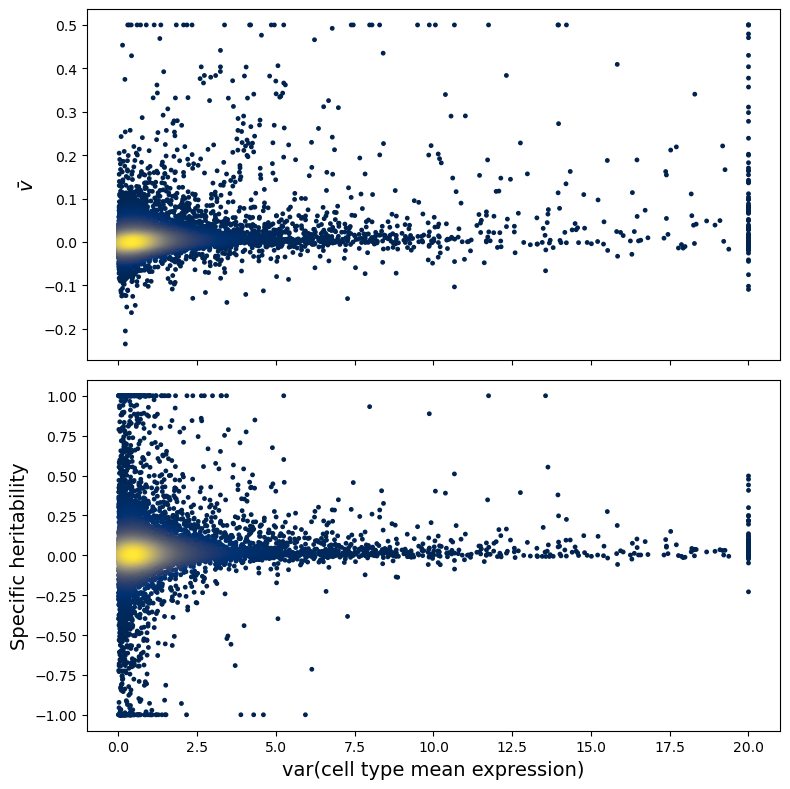

In [9]:
# print(jk_data.columns)
# print(jk_data.shape)
m = 200
v_genes = jk_data.nlargest(m, 'V', keep='all')['feature'].to_list()
beta_genes = jk_data.nlargest(m, 'var_beta', keep='all')['feature'].to_list()
assert (len(v_genes) == m) and (len(beta_genes) == m)
# print(jk_data.nlargest(m, 'var_beta', keep='all')['raw_p_beta'].sort_values(ascending=False))

common_genes = list(set(v_genes) & set(beta_genes))
p = stats.hypergeom.sf(len(common_genes) - 1, jk_data.shape[0], len(v_genes), len(beta_genes))
print(len(common_genes), p)

# spearman correlation
print(stats.spearmanr(jk_data['specific_h2'], jk_data['var_beta']))
print(stats.spearmanr(jk_data['v_bar'], jk_data['var_beta']))

# point plot of specific h2 vs var_beta
fig, axes = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)
plot.scatter(jk_data['var_beta'].clip(np.nan, 20), jk_data['v_bar'].clip(np.nan, .5), 
            s=6, ax=axes[0], heatscatter=True)
plot.scatter(jk_data['var_beta'].clip(np.nan, 20), jk_data['specific_h2'].clip(-1, 1), 
            s=6, ax=axes[1], heatscatter=True)
axes[0].set_ylabel(r'$\bar{v}$', fontsize=14)
axes[1].set_xlabel('var(cell type mean expression)', fontsize=14)
axes[1].set_ylabel('Specific heritability', fontsize=14)
fig.tight_layout()

# Supp: various QC

In [10]:
def summary(df, filters, rng, confidence_level=.95):
    data = {'gene no':[], 
        'shared (mean)':[], 'specific (mean)': [], 'shared (median)':[], 'specific (median)': [], 'shared (ratio)': [], 'specific (ratio)': [],
        'shared_mean_ci':[], 'specific_mean_ci':[], 'shared_median_ci':[],'specific_median_ci':[],'shared_ratio_ci':[], 'specific_ratio_ci':[],
        'trans shared (mean)':[], 'trans specific (mean)': [], 'trans shared (median)':[], 'trans specific (median)': [], 'trans shared (ratio)': [], 'trans specific (ratio)': [],
        'trans shared_mean_ci':[], 'trans specific_mean_ci':[], 'trans shared_median_ci':[],'trans specific_median_ci':[],'trans shared_ratio_ci':[], 'trans specific_ratio_ci':[],
        }
        # 'specificity (mean)':[], 'specificity (median)':[], 'specificity (ratio)':[],
        # 'specificity_mean_ci':[], 'specificity_median_ci':[], 'specificity_ratio_ci':[],
        # 'trans specificity (mean)':[], 'trans specificity (median)':[], 'trans specificity (ratio)':[],
        # 'trans specificity_mean_ci':[], 'trans specificity_median_ci':[], 'trans specificity_ratio_ci':[],
    for filter in filters:
        data['gene no'].append(filter.sum())

        data['shared (mean)'].append(np.mean(df['shared_h2'][filter]))
        data['specific (mean)'].append(np.mean(df['specific_h2'][filter]))
        data['shared (median)'].append(np.median(df['shared_h2'][filter]))
        data['specific (median)'].append(np.median(df['specific_h2'][filter]))
        data['shared (ratio)' ].append(np.mean(df['hom_g2'][filter]) / np.mean(df['bio_var'][filter]))
        data['specific (ratio)'].append(np.mean(df['V_bar'][filter]) / np.mean(df['bio_var'][filter]))
        # data['specificity (mean)'].append(np.mean(df['specificity'][filter]))
        # data['specificity (median)'].append(np.median(df['specificity'][filter]))
        # data['specificity (ratio)'].append(np.mean(df['V_bar'][filter]) / np.mean((df['hom_g2'] + df['V_bar'])[filter]))

        data['trans shared (mean)'].append(np.mean(df['shared_h2_b'][filter]))
        data['trans specific (mean)'].append(np.mean(df['specific_h2_b'][filter]))
        data['trans shared (median)'].append(np.median(df['shared_h2_b'][filter]))
        data['trans specific (median)'].append(np.median(df['specific_h2_b'][filter]))
        data['trans shared (ratio)' ].append(np.mean(df['hom_g2_b'][filter]) / np.mean(df['bio_var'][filter]))
        data['trans specific (ratio)'].append(np.mean(df['V_b_bar'][filter]) / np.mean(df['bio_var'][filter]))
        # data['trans specificity (mean)'].append(np.mean(df['specificity_b'][filter]))
        # data['trans specificity (median)'].append(np.median(df['specificity_b'][filter]))
        # data['trans specificity (ratio)'].append(np.mean(df['V_b_bar'][filter]) / np.mean((df['hom_g2_b'] + df['V_b_bar'])[filter]))


        data['shared_mean_ci'].append(np.array(stats.bootstrap((df['shared_h2'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_mean_ci'].append(np.array(stats.bootstrap((df['specific_h2'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['shared_median_ci'].append(np.array(stats.bootstrap((df['shared_h2'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_median_ci'].append(np.array(stats.bootstrap((df['specific_h2'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['shared_ratio_ci'].append(np.array(stats.bootstrap((df['hom_g2'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y), 
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_ratio_ci'].append(np.array(stats.bootstrap((df['V_bar'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y),
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        # data['specificity_mean_ci'].append(np.array(stats.bootstrap((df['specificity'][filter], ), np.mean, 
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['specificity_median_ci'].append(np.array(stats.bootstrap((df['specificity'][filter], ), np.median,
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['specificity_ratio_ci'].append(np.array(stats.bootstrap((df['V_bar'][filter], (df['hom_g2'] + df['V_bar'])[filter]), lambda x, y: np.mean(x) / np.mean(y), 
        #                         vectorized=False, paired=True, random_state=rng
        #                         ).confidence_interval))


        data['trans shared_mean_ci'].append(np.array(stats.bootstrap((df['shared_h2_b'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_mean_ci'].append(np.array(stats.bootstrap((df['specific_h2_b'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans shared_median_ci'].append(np.array(stats.bootstrap((df['shared_h2_b'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_median_ci'].append(np.array(stats.bootstrap((df['specific_h2_b'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans shared_ratio_ci'].append(np.array(stats.bootstrap((df['hom_g2_b'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y), 
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_ratio_ci'].append(np.array(stats.bootstrap((df['V_b_bar'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y),
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        # data['trans specificity_mean_ci'].append(np.array(stats.bootstrap((df['specificity_b'][filter], ), np.mean, 
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['trans specificity_median_ci'].append(np.array(stats.bootstrap((df['specificity_b'][filter], ), np.median,
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['trans specificity_ratio_ci'].append(np.array(stats.bootstrap((df['V_b_bar'][filter], (df['hom_g2_b'] + df['V_b_bar'])[filter]), lambda x, y: np.mean(x) / np.mean(y), 
        #                         vectorized=False, paired=True, random_state=rng
        #                         ).confidence_interval))

    return pd.DataFrame(data)

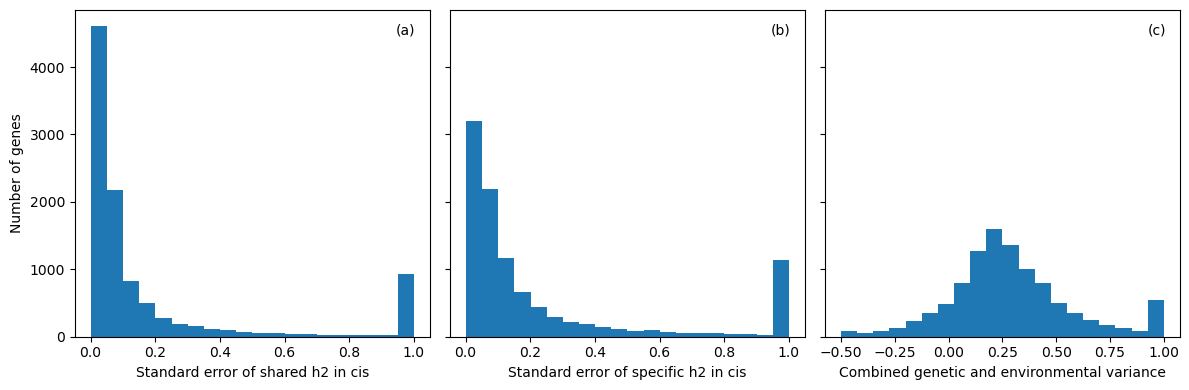

In [11]:
# supp fig: distribution of std(h2) and bio var
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

ax = axes[0]
ax.hist(np.clip(trans_df['std_shared_h2'], a_min=None, a_max=1), bins=20)
ax.set_xlabel('Standard error of shared h2 in cis')
ax.set_ylabel('Number of genes')
ax.text(0.96, 0.96, '(a)', ha='right', va='top', transform=ax.transAxes)

ax = axes[1]
ax.hist(np.clip(trans_df['std_specific_h2'], a_min=None, a_max=1), bins=20)
ax.set_xlabel('Standard error of specific h2 in cis')
ax.text(0.96, 0.96, '(b)', ha='right', va='top', transform=ax.transAxes)

ax = axes[2]
ax.hist(np.clip(trans_df['bio_var'], a_min=-.5, a_max=1), bins=20)
ax.set_xlabel('Combined genetic and environmental variance')
ax.text(0.96, 0.96, '(c)', ha='right', va='top', transform=ax.transAxes)

fig.tight_layout()

In [12]:
# HE
rng = np.random.default_rng(42)

colors = sns.color_palette()
palette = {'shared (mean)': colors[0], 'specific (mean)': colors[0], 'shared (median)': colors[1],'specific (median)': colors[1],'shared (ratio)': colors[2],'specific (ratio)': colors[2]}
dashes = {'shared (mean)': '', 'specific (mean)': (2, 2), 'shared (median)': '', 'specific (median)': (2, 2), 'shared (ratio)': '', 'specific (ratio)': (2, 2)}

# filter on var(shared and specific cis h2)
cuts = [0.1, .5, 1, 10]
filters = []
for cut in cuts:
    filter = (trans_df['std_specific_h2'] < cut) & (trans_df['std_shared_h2'] < cut)
    filters.append(filter)

trans_se_filterd_df = summary(trans_df, filters, rng)
trans_se_filterd_df['cut'] = cuts

# filter on bio var
cuts = [0.01, 0.1, 0.2, 0.3]
filters = []
for cut in cuts:
    filter = trans_df['bio_var'] > cut
    # filter = filter & specificity_filter
    filters.append(filter)

trans_bio_filterd_df = summary(trans_df, filters, rng)
trans_bio_filterd_df['cut'] = cuts


print(trans_se_filterd_df[['cut', 'gene no']])
print(trans_bio_filterd_df[['cut', 'gene no']])

    cut  gene no
0   0.1     4930
1   0.5     8427
2   1.0     9039
3  10.0     9814
    cut  gene no
0  0.01     8992
1  0.10     8090
2  0.20     6296
3  0.30     4298


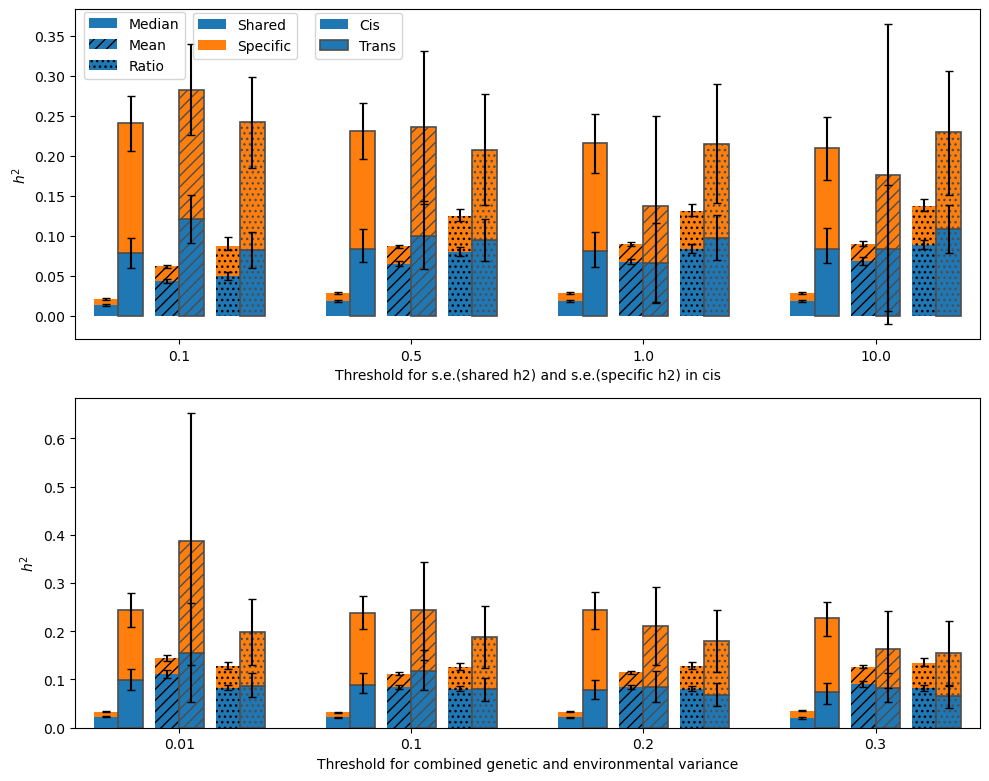

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
colors = sns.color_palette()


# se(shared and specific h2)
ax = axes[0]
width = 0.105
multiplier = -2.5
x = np.arange(trans_se_filterd_df['cut'].nunique())
for measure in ['median', 'mean', 'ratio']:
    hatch = None
    if measure == 'mean':
        hatch = '///'
    elif measure == 'ratio':
        hatch = '...'
    for region in ['cis', 'trans']:
        if region == 'cis':
            offset = width * (multiplier - .5)
            # shared
            bottom = np.zeros(trans_se_filterd_df['cut'].nunique())
            values = trans_se_filterd_df[f'shared ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'shared_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], hatch=hatch)
            # speccific
            bottom = values
            values = trans_se_filterd_df[f'specific ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'specific_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], hatch=hatch)
        else:
            offset = width * (multiplier + .5)
            # shared
            bottom = np.zeros(trans_se_filterd_df['cut'].nunique())
            values = trans_se_filterd_df[f'trans shared ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'trans shared_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'trans shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], edgecolor='0.3', linewidth=1.2, hatch=hatch)
            # specific
            bottom = values
            values = trans_se_filterd_df[f'trans specific ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'trans specific_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'trans specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], edgecolor='0.3', linewidth=1.2, hatch=hatch)
        
    multiplier += 2.5

# make legend
bar1 = ax.bar(0, 0, 0, color=colors[0], label='Cis')
bar2 = ax.bar(0, 0, 0, color=colors[0], edgecolor='0.3', linewidth=1.2, label='Trans')
legend1 = ax.legend(handles=[bar1, bar2], loc=[0.265, 0.85])

bar3 = ax.bar(0, 0, 0, color=colors[0], label='Shared')
bar4 = ax.bar(0, 0, 0, color=colors[1], label='Specific')
legend2 = ax.legend(handles=[bar3, bar4], loc=[0.13, 0.85])

bar5 = ax.bar(0, 0, 0, color=colors[0], label='Median')
bar6 = ax.bar(0, 0, 0, color=colors[0], hatch='///', label='Mean')
bar7 = ax.bar(0, 0, 0, color=colors[0], hatch='...', label='Ratio')
legend3 = ax.legend(handles=[bar5, bar6, bar7], loc=[0.01, 0.79])

ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_xticks(x, labels=trans_se_filterd_df['cut'])
ax.set_xlim((-.45, 3.45))
ax.set_ylabel('$h^2$')
ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')

# total var
ax = axes[1]
width = 0.105
multiplier = -2.5
x = np.arange(trans_bio_filterd_df['cut'].nunique())
for measure in ['median', 'mean', 'ratio']:
    hatch = None
    if measure == 'mean':
        hatch = '///'
    elif measure == 'ratio':
        hatch = '...'
    for region in ['cis', 'trans']:
        if region == 'cis':
            offset = width * (multiplier - .5)
            # shared
            bottom = np.zeros(trans_bio_filterd_df['cut'].nunique())
            values = trans_bio_filterd_df[f'shared ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'shared_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], hatch=hatch)
            # speccific
            bottom = values
            values = trans_bio_filterd_df[f'specific ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'specific_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], hatch=hatch)
        else:
            offset = width * (multiplier + .5)
            # shared
            bottom = np.zeros(trans_bio_filterd_df['cut'].nunique())
            values = trans_bio_filterd_df[f'trans shared ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'trans shared_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'trans shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], edgecolor='0.3', linewidth=1.2, hatch=hatch)
            # specific
            bottom = values
            values = trans_bio_filterd_df[f'trans specific ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'trans specific_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'trans specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], edgecolor='0.3', linewidth=1.2, hatch=hatch)
    multiplier += 2.5

ax.set_xticks(x, labels=trans_bio_filterd_df['cut'])
ax.set_xlim((-.45, 3.45))
ax.set_xlabel('Threshold for combined genetic and environmental variance')
ax.set_ylabel('$h^2$')
fig.tight_layout()

9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared: 0.10136985303533792; Trans specific: 0.14850067668957345;
Trans specific (%): 0.5943104889282522
Cis specific sd: 0.01282304524507802
Trans specific sd: 0.045410842279155185
Trans (%): 0.8837440884972985
[[0.00122072 0.00137804]
 [0.02277014 0.0205564 ]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
9065 genes after filtering
Cis shared: 0.14869828987012348; Cis specific: 0.06038141896072777;
Cis specific (%): 0.28879616916616846
Trans shared: 0.27549408164350697; Trans specific: 0.3505556605883576;
Trans specific (%): 0.559948574275629
Cis specific sd: 0.054927398645581514
Trans specific sd: 0.15647528672797614
Trans (%): 0.7496439521264711
[[0.0214052  0.04440636]
 [0.1719951  0.17043404]]
[0.14869829 0.27549408] [0.06038142 0.35055566]
9065 genes after filtering
Cis shared: 0.08312438318246487; Cis specific: 0.04477737207400226;
Cis sp

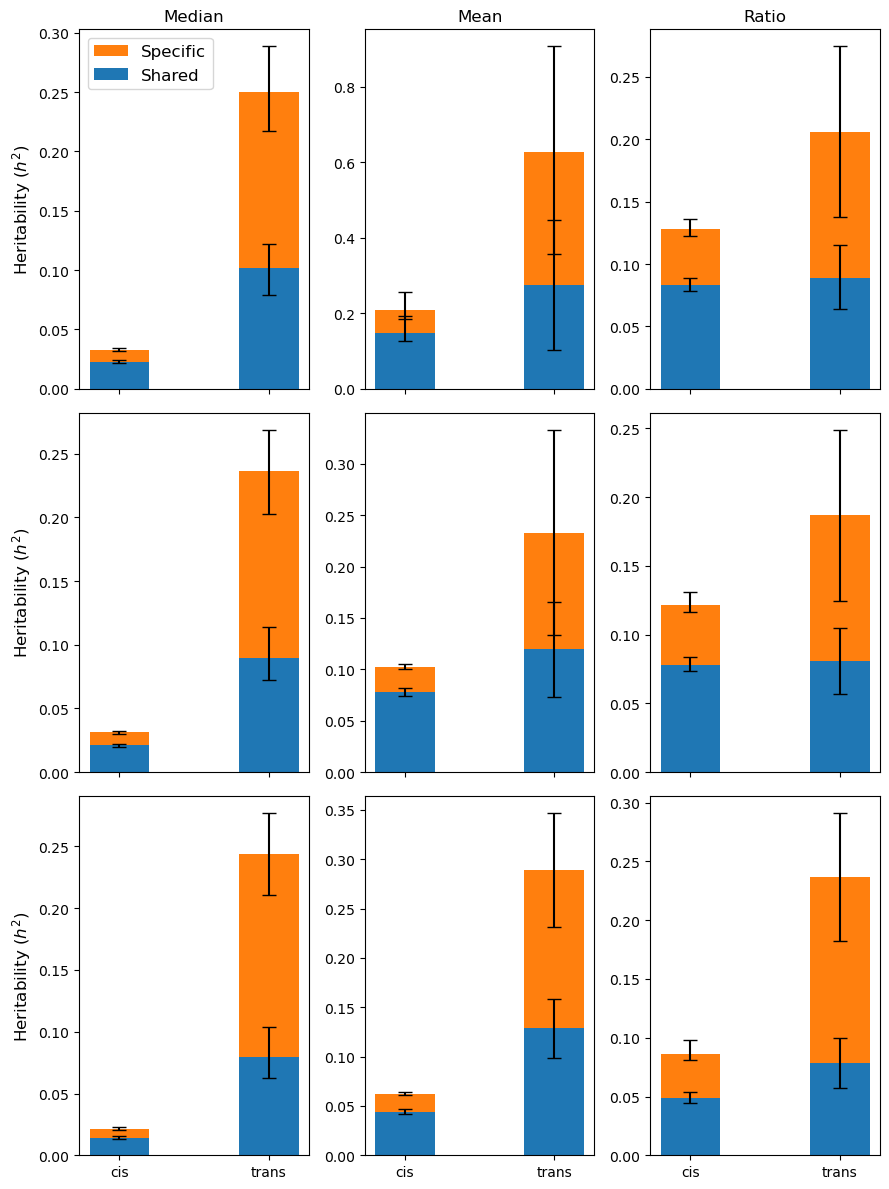

In [14]:
# supp fig
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 12), sharex=True)

ax = axes[0, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4)
ax.legend(loc='upper left', reverse=True, fontsize=12)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)
ax.set_title('Median')

ax = axes[0, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean_clip', width=.4)  # truncated h2 to (-100, 100)
ax.set_title('Mean')

ax = axes[0, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4)
ax.set_title('Ratio')


# filter on precision of shared and specific h2
std_shared_h2 = np.sqrt(trans['p']['free']['var_shared_h2'])
std_specific_h2 = np.sqrt(trans['p']['free']['var_specific_h2'])
h2_filter = (std_shared_h2 < 1) & (std_specific_h2 < 1)
print(h2_filter.sum(), len(h2_filter))

ax = axes[1, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4, filter=h2_filter)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)

ax = axes[1, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean', width=.4, filter=h2_filter)

ax = axes[1, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4, filter=h2_filter)


h2_filter = (std_shared_h2 < .1) & (std_specific_h2 < .1)
print(h2_filter.sum(), len(h2_filter))

ax = axes[2, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4, filter=h2_filter)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)

ax = axes[2, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean', width=.4, filter=h2_filter)

ax = axes[2, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4, filter=h2_filter)


# ax.set_xlabel('regulatory region', fontsize=12)

fig.tight_layout()

In [15]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='row', squeeze=False)
# # fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex='col', sharey='row', squeeze=False)
# colors = sns.color_palette()

# # filter on var(shared and specific cis h2)
# ax = axes[0, 0]
# ax.errorbar(data['cut'], data['shared (median)'], yerr=np.abs(np.vstack(data['shared_median_ci'].tolist()).T - data['shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='shared (median)')
# ax.errorbar(data['cut'], data['specific (median)'], yerr=np.abs(np.vstack(data['specific_median_ci'].tolist()).T - data['specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='specific (median)')
# ax.errorbar(data['cut'], data['shared (mean)'], yerr=np.abs(np.vstack(data['shared_mean_ci'].tolist()).T - data['shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='shared (mean)')
# ax.errorbar(data['cut'], data['specific (mean)'], yerr=np.abs(np.vstack(data['specific_mean_ci'].tolist()).T - data['specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='specific (mean)')
# ax.errorbar(data['cut'], data['shared (ratio)'], yerr=np.abs(np.vstack(data['shared_ratio_ci'].tolist()).T - data['shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='shared (ratio)')
# ax.errorbar(data['cut'], data['specific (ratio)'], yerr=np.abs(np.vstack(data['specific_ratio_ci'].tolist()).T - data['specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='specific (ratio)')
# ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')
# ax.set_ylabel('Cis h2')
# # ax.text(0.02, 1.02, 'number of genes:' + '; '.join(data['gene no'].astype(str).tolist()), ha='left', va='bottom', transform=ax.transAxes)
# ax.axhline(y=0, color='0.7')


# ax = axes[0, 1]
# ax.errorbar(data['cut'], data['trans shared (median)'], yerr=np.abs(np.vstack(data['trans shared_median_ci'].tolist()).T - data['trans shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='trans shared (median)')
# ax.errorbar(data['cut'], data['trans specific (median)'], yerr=np.abs(np.vstack(data['trans specific_median_ci'].tolist()).T - data['trans specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='trans specific (median)')
# ax.errorbar(data['cut'], data['trans shared (mean)'], yerr=np.abs(np.vstack(data['trans shared_mean_ci'].tolist()).T - data['trans shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='trans shared (mean)')
# ax.errorbar(data['cut'], data['trans specific (mean)'], yerr=np.abs(np.vstack(data['trans specific_mean_ci'].tolist()).T - data['trans specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='trans specific (mean)')
# ax.errorbar(data['cut'], data['trans shared (ratio)'], yerr=np.abs(np.vstack(data['trans shared_ratio_ci'].tolist()).T - data['trans shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='trans shared (ratio)')
# ax.errorbar(data['cut'], data['trans specific (ratio)'], yerr=np.abs(np.vstack(data['trans specific_ratio_ci'].tolist()).T - data['trans specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='trans specific (ratio)')
# ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')
# ax.set_ylabel('Trans h2')
# ax.axhline(y=0, color='0.7')


# # filter on bio var
# ax = axes[1, 0]
# ax.errorbar(data2['cut'], data2['shared (median)'], yerr=np.abs(np.vstack(data2['shared_median_ci'].tolist()).T - data2['shared (median)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[0])
# ax.errorbar(data2['cut'], data2['specific (median)'], yerr=np.abs(np.vstack(data2['specific_median_ci'].tolist()).T - data2['specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--')
# ax.errorbar(data2['cut'], data2['shared (mean)'], yerr=np.abs(np.vstack(data2['shared_mean_ci'].tolist()).T - data2['shared (mean)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[1])
# ax.errorbar(data2['cut'], data2['specific (mean)'], yerr=np.abs(np.vstack(data2['specific_mean_ci'].tolist()).T - data2['specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--')
# ax.errorbar(data2['cut'], data2['shared (ratio)'], yerr=np.abs(np.vstack(data2['shared_ratio_ci'].tolist()).T - data2['shared (ratio)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[2])
# ax.errorbar(data2['cut'], data2['specific (ratio)'], yerr=np.abs(np.vstack(data2['specific_ratio_ci'].tolist()).T - data2['specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--')
# ax.set_xlabel('Threshold for combined genetic and environmental variance')
# # ax.text(0.02, 1.02, 'number of genes:' + '; '.join(data2['gene no'].astype(str).tolist()), ha='left', va='bottom', transform=ax.transAxes)
# ax.set_ylabel('Cis h2')
# ax.axhline(y=0, color='0.7')

# ax = axes[1, 1]
# ax.errorbar(data2['cut'], data2['trans shared (median)'], yerr=np.abs(np.vstack(data2['trans shared_median_ci'].tolist()).T - data2['trans shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='Shared (median)')
# ax.errorbar(data2['cut'], data2['trans specific (median)'], yerr=np.abs(np.vstack(data2['trans specific_median_ci'].tolist()).T - data2['trans specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='Specific (median)')
# ax.errorbar(data2['cut'], data2['trans shared (mean)'], yerr=np.abs(np.vstack(data2['trans shared_mean_ci'].tolist()).T - data2['trans shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='Shared (mean)')
# ax.errorbar(data2['cut'], data2['trans specific (mean)'], yerr=np.abs(np.vstack(data2['trans specific_mean_ci'].tolist()).T - data2['trans specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='Specific (mean)')
# ax.errorbar(data2['cut'], data2['trans shared (ratio)'], yerr=np.abs(np.vstack(data2['trans shared_ratio_ci'].tolist()).T - data2['trans shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='Shared (ratio)')
# ax.errorbar(data2['cut'], data2['trans specific (ratio)'], yerr=np.abs(np.vstack(data2['trans specific_ratio_ci'].tolist()).T - data2['trans specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='Specific (ratio)')
# ax.set_xlabel('Threshold for combined genetic and environmental variance')
# ax.set_ylabel('Trans h2')
# ax.axhline(y=0, color='0.7')
# ax.legend(loc='upper right')

# fig.tight_layout()

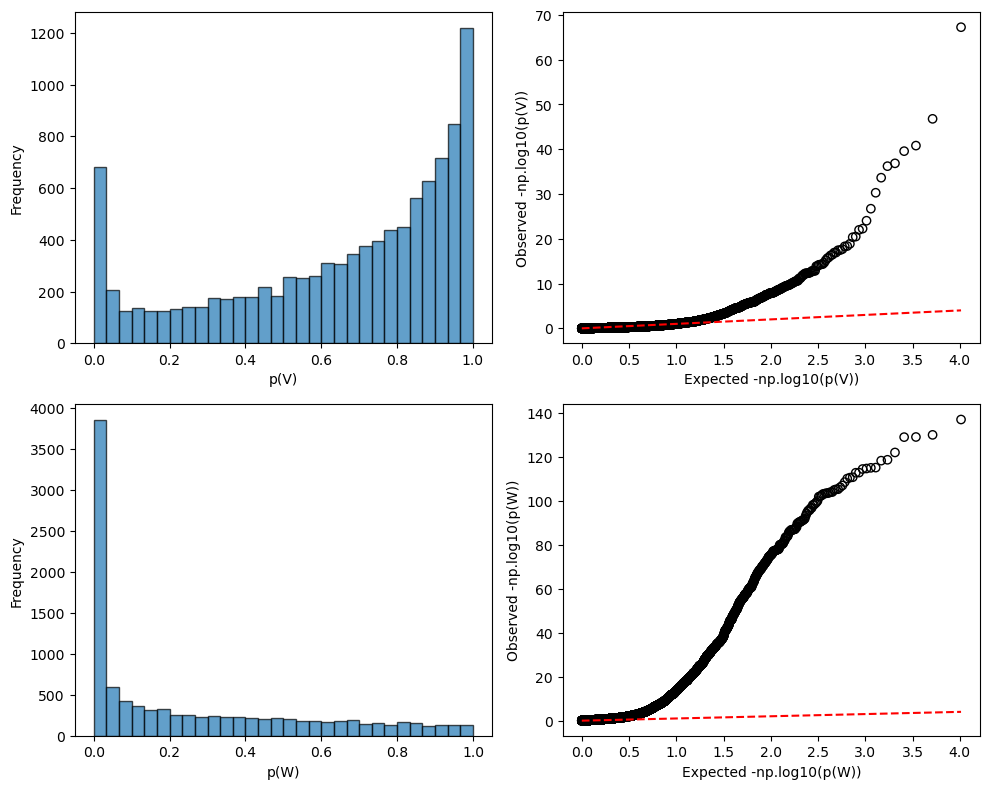

In [16]:
# Supp: QQ plot and hist
p_values = jk['p']['free']['V']
W_p_values = jk['p']['free']['W']

# Sort p-values for QQ plot
sorted_p_values = np.sort(p_values)
sorted_W_p_values = np.sort(W_p_values)

# Theoretical quantiles
quantiles = np.arange(1, len(p_values)+1) / (len(p_values)+1)
W_quantiles = np.arange(1, len(W_p_values)+1) / (len(W_p_values)+1)

# QQ plot
plt.figure(figsize=(10, 8))

# Histogram
plt.subplot(2, 2, 1)
plt.hist(p_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('p(V)')
plt.ylabel('Frequency')
# plt.title('Histogram of P-Values')

plt.subplot(2, 2, 2)
plt.scatter(-np.log10(quantiles), -np.log10(sorted_p_values), edgecolor='k', facecolor='none')
x_max = np.max(-np.log10(quantiles))
plt.plot([0, x_max], [0, x_max], 'r--')
plt.xlabel('Expected -np.log10(p(V))')
plt.ylabel('Observed -np.log10(p(V))')
# plt.title('QQ Plot of P-Values')

plt.subplot(2, 2, 3)
plt.hist(W_p_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('p(W)')
plt.ylabel('Frequency')
# plt.title('Histogram of P-Values')

plt.subplot(2, 2, 4)
plt.scatter(-np.log10(W_quantiles), -np.log10(sorted_W_p_values), edgecolor='k', facecolor='none')
x_max = np.max(-np.log10(W_quantiles))
plt.plot([0, x_max], [0, x_max], 'r--')
plt.xlabel('Expected -np.log10(p(W))')
plt.ylabel('Observed -np.log10(p(W))')
# plt.title('QQ Plot of P-Values')


plt.tight_layout()
plt.show()


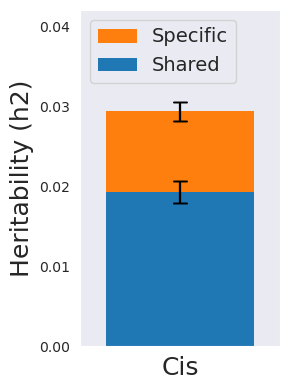

In [17]:
# fig: cis h2

# calcualte h2
rng = np.random.default_rng(42)

func = lambda x: np.median(x)
# ctp
cis_shared_h2 = func(cis['free']['shared_h2'])
cis_specific_h2 = func(cis['free']['specific_h2'])

cis_shared_h2_ci = stats.bootstrap((cis['free']['shared_h2'],), func, vectorized=False, paired=False, random_state=rng).confidence_interval
cis_specific_h2_ci = stats.bootstrap((cis['free']['specific_h2'],), func, vectorized=False, paired=False, random_state=rng).confidence_interval

# plot
colors = sns.color_palette()
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(3, 4))
labels = 'Cis'

bottom = np.zeros(len(labels))
values = np.array([cis_shared_h2])
ci = np.array([cis_shared_h2_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, yerr=yerr.T, capsize=5,
    bottom=bottom, color=colors[0], edgecolor='none', label='Shared')

bottom += values
values = np.array([cis_specific_h2])
ci = np.array([cis_specific_h2_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, yerr=yerr.T, capsize=5,
        bottom=bottom, color=colors[1], edgecolor='none', label='Specific')
ax.set_ylim(0, .042)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
ax.legend(loc='upper left', reverse=True, fontsize=14)
ax.set_ylabel('Heritability (h2)', fontsize=18)
xlims = ax.get_xlim()
ax.set_xlim((xlims[0] - 0.1, xlims[1] + 0.1))
plt.xticks(fontsize=18)
# ax.set_title('OneK1K', fontsize=20)
fig.tight_layout()


9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared: 0.10136985303533792; Trans specific: 0.14850067668957345;
Trans specific (%): 0.5943104889282522
Cis specific sd: 0.013098072903718264
Trans specific sd: 0.04612682405066562
Trans (%): 0.8837440884972985
[[0.00124182 0.00135801]
 [0.02370026 0.02080401]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = 0.2831981664704886 with p = 0.001


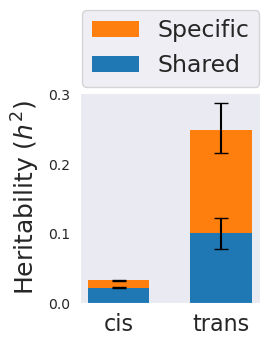

In [18]:
#fig 1: cis Transcriptome-wide + Trans transcriptome-wide
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(2.8, 4))
dif, p = plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.6)
ax.legend(loc='upper left', bbox_to_anchor=(-.05, 1.45), reverse=True, fontsize=17)
ax.set_ylabel('Heritability ($h^2$)', fontsize=18)
ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.tick_params(axis='x', labelsize=16)
print(f'trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = {dif} with p = {p}')
# ax.set_ylim(0, .35)

fig.tight_layout()

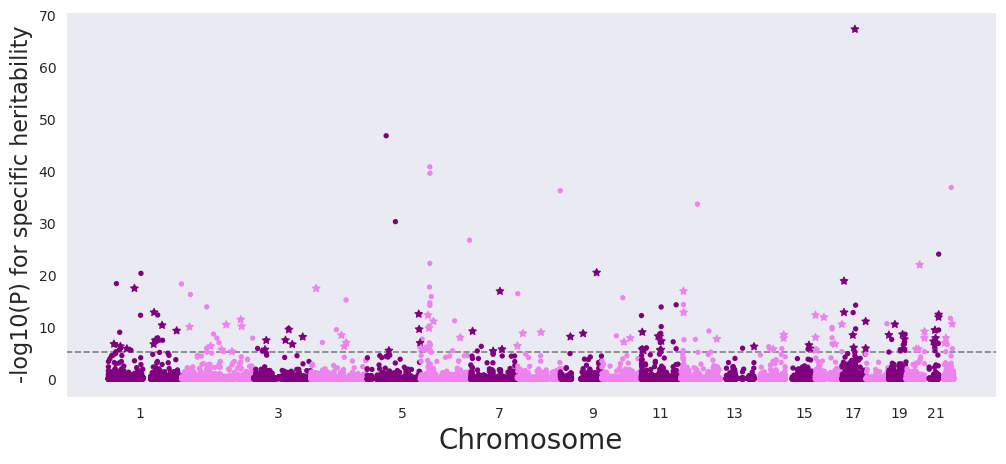

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
light_dark_green = mcolors.ListedColormap(['violet', 'purple'])
cut = -np.log10(0.05 / jk_data.shape[0])
v = 'V'
sig_V = jk_data.loc[jk_data[v] > cut, :]
sig_W = jk_data.loc[jk_data[w] > cut, :]
sig_V_only = jk_data.loc[(jk_data[v] > cut) & (jk_data[w] < cut), :]
ax.scatter(jk_data['start_cum'], jk_data[v], c=jk_data['chr'] % 2, cmap=light_dark_green, s=8, label='cell type-specific genetic effects (V)')
ax.scatter(sig_V_only['start_cum'], sig_V_only[v], c=sig_V_only['chr'] % 2, cmap=light_dark_green, marker='*', s=30)
ax.set_xticks(chr_ticks[::2])
ax.set_xticklabels(jk_data['chr'].unique()[::2])
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('-log10(P) for specific heritability', fontsize=16)
ax.axhline(cut, color='0.5', lw=1.2, ls='--', zorder=0)

In [20]:
print(jk['p']['free'].keys())

dict_keys(['hom_g2', 'V', 'vc', 'hom_e2', 'W', 'var_hom_g2', 'var_V', 'var_hom_e2', 'var_W', 'var_shared_h2', 'var_specific_h2', 'var_specificity', 'jk_hom_g2', 'jk_V', 'jk_hom_e2', 'jk_W', 'jk_shared_h2', 'jk_specific_h2', 'ct_beta'])


{'CTLA4'}
              feature GeneSymbol  chr      start         V        W     v_bar  \
1637  ENSG00000163599      CTLA4    2  204732509  10.15487  3.21597  0.183511   

      specific_h2  raw_p_beta  var_beta  start_cum  
1637     0.232808         0.0  0.733915  453932904  


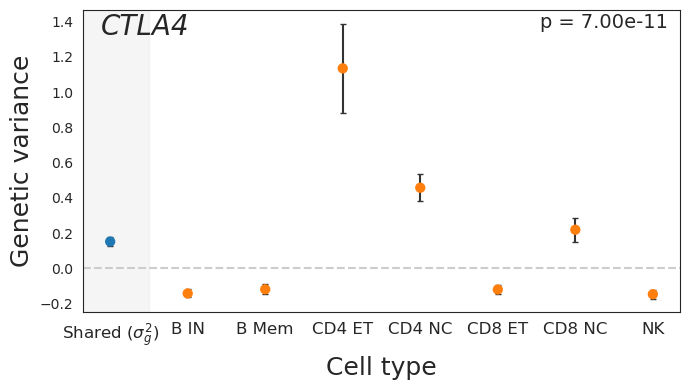

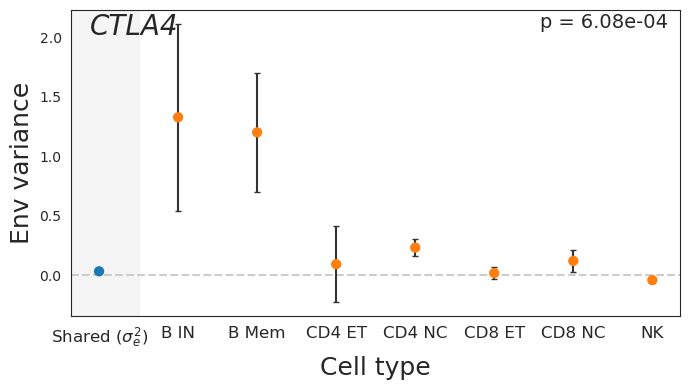

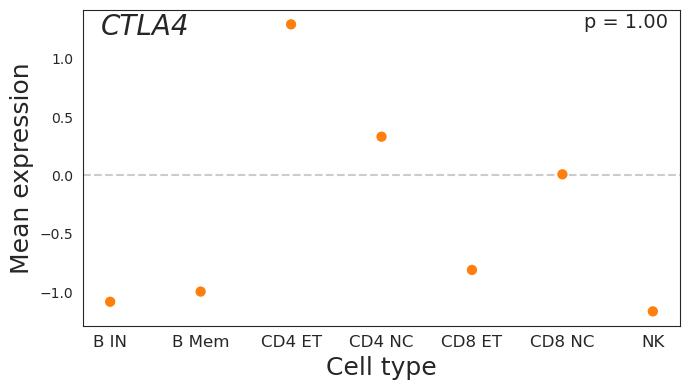

In [21]:
yazar_genes = ['SELL', 'CTLA4', 'BACH2', 'BLK']
print(set(meta.loc[meta['feature'].isin(sig_V['feature']), 'GeneSymbol'].to_list()) & set(yazar_genes))

sns.set_style('white')
fig, ax = plt.subplots(figsize=(7, 4))

genename = 'CTLA4'
gene = meta.loc[meta['GeneSymbol'] == genename, 'feature'].to_list()[0]
index = np.where(jk_data['feature'] == gene)[0][0]
gene_homg2 = jk['free']['hom_g2'][index]
gene_V = np.diag(jk['free']['V'][index])
gene_std_hom_g2 = np.sqrt(jk['p']['free']['var_hom_g2'][index])
gene_std_V = np.sqrt(np.diag(jk['p']['free']['var_V'][index]))
gene_p_V = 10 ** (-1 * jk_data[v][index])
print(jk_data.loc[jk_data['GeneSymbol'] == genename])
gene_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_homg2] + gene_V.tolist(), 
                    'error': [gene_std_hom_g2] + gene_std_V.tolist()})
sns.scatterplot(data=gene_df, palette=[colors[0]] + [colors[1]] * len(cts), x='variable', y='value', 
                hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
ax.axhline(0, ls='--', color='0.8', zorder=1)
ax.text(0.98, 0.99, f'p = {gene_p_V:.2e}', ha='right', va='top', fontsize=14, transform=ax.transAxes)
ax.legend().set_visible(False)
# ax.set_title(f'{genename}', fontsize=18, fontstyle='italic')
ax.text(0.03, 0.99, f'{genename}', ha='left', va='top', fontsize=20, fontstyle='italic', transform=ax.transAxes)
# ax.set_xlabel('Variance component', fontsize=18)
ax.set_xlabel('Cell type', fontsize=18)
ax.set_ylabel('Genetic variance', fontsize=18)
ax.errorbar(gene_df['variable'], gene_df['value'], yerr=gene_df['error'], 
                fmt='none', ecolor='0.2', capsize=2, zorder=1)

current_labels = plt.xticks()[1]
new_labels = []
for label in current_labels:
    label = label.get_text()
    if label == 'Shared':
        new_labels.append(r'Shared ($\sigma_g^2$)')
    else:
        # label = re.sub(' ', '\ ', label)
        # new_labels.append(f"$V_{{{label}}}$")
        new_labels.append(f"{label}")
ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=12)

xmin, xmax = ax.get_xlim()
ax.axvspan(xmin, 0.5, color='0.88', alpha=0.3, zorder=0)
ax.set_xlim((xmin, xmax))

fig.tight_layout()




# env
gene_home2 = jk['free']['hom_e2'][index]
gene_W = np.diag(jk['free']['W'][index])
gene_std_hom_e2 = np.sqrt(jk['p']['free']['var_hom_e2'][index])
gene_std_W = np.sqrt(np.diag(jk['p']['free']['var_W'][index]))
gene_p_W = 10 ** (-1 * jk_data['W'][index])
gene_w_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_home2] + gene_W.tolist(), 
                    'error': [gene_std_hom_e2] + gene_std_W.tolist()})

fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=gene_w_df, palette=[colors[0]] + [colors[1]] * len(cts), x='variable', y='value', 
                hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
ax.axhline(0, ls='--', color='0.8', zorder=1)
ax.text(0.98, 0.99, f'p = {gene_p_W:.2e}', ha='right', va='top', fontsize=14, transform=ax.transAxes)
ax.legend().set_visible(False)
# ax.set_title(f'{genename}', fontsize=18, fontstyle='italic')
ax.text(0.03, 0.99, f'{genename}', ha='left', va='top', fontsize=20, fontstyle='italic', transform=ax.transAxes)
# ax.set_xlabel('Variance component', fontsize=18)
ax.set_xlabel('Cell type', fontsize=18)
ax.set_ylabel('Env variance', fontsize=18)
ax.errorbar(gene_w_df['variable'], gene_w_df['value'], yerr=gene_w_df['error'], 
                fmt='none', ecolor='0.2', capsize=2, zorder=1)

current_labels = plt.xticks()[1]
new_labels = []
for label in current_labels:
    label = label.get_text()
    if label == 'Shared':
        new_labels.append(r'Shared ($\sigma_e^2$)')
    else:
        # label = re.sub(' ', '\ ', label)
        # new_labels.append(f"$V_{{{label}}}$")
        new_labels.append(f"{label}")
ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=12)

xmin, xmax = ax.get_xlim()
ax.axvspan(xmin, 0.5, color='0.88', alpha=0.3, zorder=0)
ax.set_xlim((xmin, xmax))

fig.tight_layout()


# beta mu
gene_beta = jk['free']['ct_beta'][index]
gene_p_beta = 10 ** (-1 * jk['p']['free']['ct_beta'][index])
gene_beta_df = pd.DataFrame({'variable': cts, 'value': gene_beta.tolist()})

fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=gene_beta_df, palette= [colors[1]] * len(cts), x='variable', y='value', 
                hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
ax.axhline(0, ls='--', color='0.8', zorder=1)
ax.text(0.98, 0.99, f'p = {gene_p_beta:.2f}', ha='right', va='top', fontsize=14, transform=ax.transAxes)
ax.legend().set_visible(False)
# ax.set_title(f'{genename}', fontsize=18, fontstyle='italic')
ax.text(0.03, 0.99, f'{genename}', ha='left', va='top', fontsize=20, fontstyle='italic', transform=ax.transAxes)
# ax.set_xlabel('Variance component', fontsize=18)
ax.set_xlabel('Cell type', fontsize=18)
ax.set_ylabel('Mean expression', fontsize=18)
ax.errorbar(gene_beta_df['variable'], gene_beta_df['value'], yerr=None, 
                fmt='none', ecolor='0.2', capsize=2, zorder=1)

current_labels = plt.xticks()[1]
new_labels = []
for label in current_labels:
    label = label.get_text()
    if label == 'Shared':
        new_labels.append(r'Shared ($\sigma_e^2$)')
    else:
        # label = re.sub(' ', '\ ', label)
        # new_labels.append(f"$V_{{{label}}}$")
        new_labels.append(f"{label}")
ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=12)

xmin, xmax = ax.get_xlim()
ax.set_xlim((xmin, xmax))

fig.tight_layout()

In [22]:
# Supp: full gen vs env
upper_mask = np.triu(np.ones_like(full_cor, dtype=bool), k=1)

# cov
# V_cov = full_V.mean(axis=0)[upper_mask]
# W_cov = full_W.mean(axis=0)[upper_mask]

# ci_V_cov = stats.sem(full_V)[upper_mask] * 1.96  # 95% confidence interval
# ci_W_cov = stats.sem(full_W)[upper_mask] * 1.96  # 95% confidence interval
# print(ci_V)

def cal_cor(X):
    X = X.mean(axis=0)
    return (X / np.sqrt(np.outer(np.diag(X), np.diag(X))))[upper_mask]

V_cor = cal_cor(full_V)
W_cor = cal_cor(full_W)
# calculate correlation and p
r, p = stats.pearsonr(V_cor, W_cor)
print(r, p)

# ci
rng = np.random.default_rng(123)
sampled_V_cor = []
sampled_W_cor = []
for i in range(9999):
    sampled = rng.choice(full_V.shape[0], size=full_V.shape[0], replace=True)
    sampled_V = full_V[sampled, :, :]
    sampled_W = full_W[sampled, :, :]
    sampled_V_cor.append(cal_cor(sampled_V))
    sampled_W_cor.append(cal_cor(sampled_W))
ci_V_cor = np.percentile(sampled_V_cor, [2.5, 97.5], axis=0) # 95% confidence interval
ci_W_cor = np.percentile(sampled_W_cor, [2.5, 97.5], axis=0)  # 95% confidence interval


0.9523730794808328 2.991523548165629e-11


Text(0, 0.5, 'Environmental Correlation')

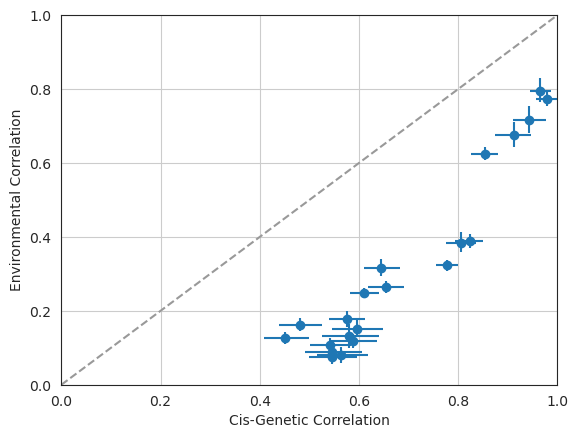

In [23]:
# Create scatter plot
fig, ax = plt.subplots()
ax.errorbar(V_cor, W_cor, xerr=np.abs(ci_V_cor - V_cor), yerr=np.abs(ci_W_cor - W_cor), fmt='o')
ax.set_xlim(0, 1)
ax.set_ylim(0, max(1, ax.get_ylim()[1]))
ax.grid(True)

# Plot y=x line
ax.plot([0, 1], [0, 1], color='0.6', linestyle='--')

# Add labels and title
ax.set_xlabel('Cis-Genetic Correlation')
ax.set_ylabel('Environmental Correlation')

# Downsampling cells and reads

In [30]:
cell_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/cellsampling.he.npy'
read_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/readsampling.he.npy'

cell_out = np.load(cell_f, allow_pickle=True).item()
# only keep <= 200 cells
cell_out = {k: v for k, v in cell_out.items() if k <= 200}
read_out = np.load(read_f, allow_pickle=True).item()
# only keep .75, .5, .25 read proportions
read_out = {k: v for k, v in read_out.items() if k in [0.75, 0.5, 0.25]}
print(read_out.keys())

primary_df = util.read_out(jk, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
primary_df['t'] = primary_df['free:hom_g2'] + primary_df['free:v'] + primary_df['free:hom_e2'] + primary_df['free:w']
primary_df = primary_df.loc[primary_df['t'] > 0]
print(primary_df.shape[0])

cell_data = {}
merged_cell_df = primary_df.copy()
merged_cell_df['Cell number'] = 'All'
for key in cell_out.keys():
    # print(key)
    tmp_cell_df = util.read_out(cell_out[key], ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
    tmp_cell_df['t'] = tmp_cell_df['free:hom_g2'] + tmp_cell_df['free:v'] + tmp_cell_df['free:hom_e2'] + tmp_cell_df['free:w']
    tmp_cell_df = tmp_cell_df.loc[tmp_cell_df['t'] > 0]
    # print(tmp_cell_df.shape[0])
    tmp = primary_df.merge(tmp_cell_df, on='gene', suffixes=('', f'_{key}'))
    cell_data[key] = tmp
    # print(tmp.shape[0])
    tmp_cell_df['Cell number'] = str(key)
    merged_cell_df = pd.concat([merged_cell_df, tmp_cell_df], axis=0)
# keep overlapping genes
merged_cell_df = merged_cell_df.loc[merged_cell_df['gene'].isin(primary_df['gene'])]
for key in cell_out.keys():
    merged_cell_df = merged_cell_df.loc[merged_cell_df['gene'].isin(cell_data[key]['gene'])]
print(merged_cell_df['gene'].nunique())
print(merged_cell_df['Cell number'].unique())
merged_cell_df = merged_cell_df.rename(columns={'free:hom_g2': 'Hom_g2', 'free:v': 'V', 'free:shared_h2': 'Shared', 'free:specific_h2': 'Specific'})
merged_cell_df = merged_cell_df.melt(id_vars=['gene', 'Cell number'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Heritability (h2)')


read_data = {}
merged_read_df = primary_df.copy()
merged_read_df['Read proportion'] = 'All'
for key in read_out.keys():
    tmp_read_df = util.read_out(read_out[key], ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
    tmp_read_df['t'] = tmp_read_df['free:hom_g2'] + tmp_read_df['free:v'] + tmp_read_df['free:hom_e2'] + tmp_read_df['free:w']
    tmp_read_df = tmp_read_df.loc[tmp_read_df['t'] > 0]
    # print(tmp_read_df.shape[0])
    tmp = primary_df.merge(tmp_read_df, on='gene', suffixes=('', f'_{key}'))
    read_data[key] = tmp
    # print(tmp.shape[0])
    tmp_read_df['Read proportion'] = str(key)
    merged_read_df = pd.concat([merged_read_df, tmp_read_df], axis=0)
# keep overlapping genes
merged_read_df = merged_read_df.loc[merged_read_df['gene'].isin(primary_df['gene'])]
for key in read_out.keys():
    merged_read_df = merged_read_df.loc[merged_read_df['gene'].isin(read_data[key]['gene'])]
print(merged_read_df['gene'].nunique())
merged_read_df = merged_read_df.rename(columns={'free:hom_g2': 'Hom_g2', 'free:v': 'V', 'free:shared_h2': 'Shared', 'free:specific_h2': 'Specific'})
merged_read_df = merged_read_df.melt(id_vars=['gene', 'Read proportion'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Heritability (h2)')

dict_keys([0.25, 0.5, 0.75])
9067
3994
['All' '11' '20' '50' '100' '200']
4616


Component      Shared  Specific
Cell number                    
100          0.022893  0.009475
11           0.018320  0.010526
20           0.023747  0.008442
200          0.022438  0.010401
50           0.023258  0.010461
All          0.022140  0.010205


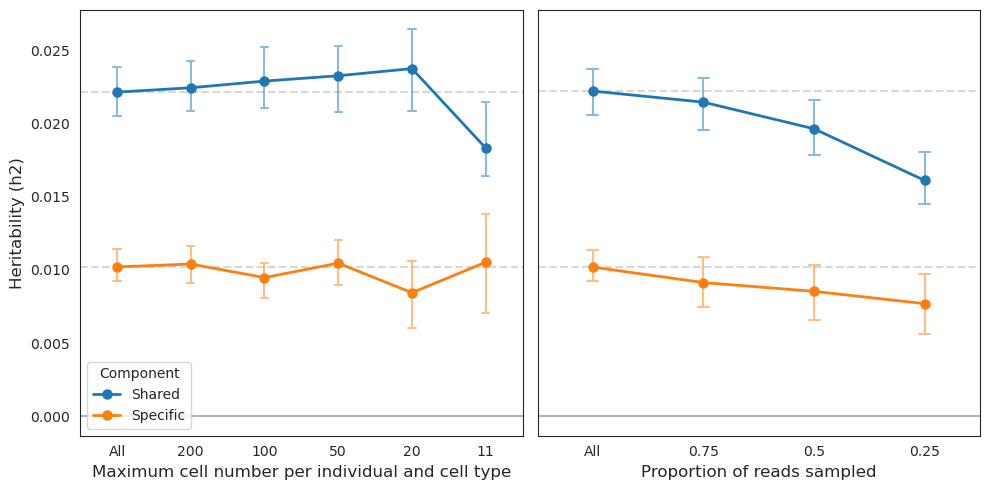

In [31]:
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# cell
ax = axes[0]
tmp_df = merged_cell_df.copy()
sns.pointplot(data=tmp_df, x='Cell number', y='Heritability (h2)', hue='Component', estimator='median', capsize=.1,
    ax=ax, palette=[colors[0], colors[1]], markers='o', markersize=6, linewidth=2, err_kws=dict(linewidth=1.5, alpha=0.5),
    order=['All'] + np.sort([int(x) for x in merged_cell_df['Cell number'].unique() if x != 'All']).astype(str).tolist()[::-1])
# plot median "All" lines separately for each component (avoid passing an array to axhline)
all_medians = merged_cell_df.loc[merged_cell_df['Cell number'] == 'All'].groupby('Component')['Heritability (h2)'].median()
ax.axhline(y=all_medians['Shared'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
ax.axhline(y=all_medians['Specific'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)

ax.set_xlabel('Maximum cell number per individual and cell type', fontsize=fs)
ax.set_ylabel('Heritability (h2)', fontsize=fs)

print(merged_cell_df.groupby(['Cell number', 'Component'])['Heritability (h2)'].median().unstack())

# read
ax = axes[1]
sns.pointplot(data=merged_read_df, x='Read proportion', y='Heritability (h2)', hue='Component', ax=ax, palette=[colors[0], colors[1]],
              estimator='median', capsize=.1,
              markers='o', markersize=6, linewidth=2, err_kws=dict(linewidth=1.5, alpha=0.5),
              order=['All'] + np.sort([float(x) for x in merged_read_df['Read proportion'].unique() if x != 'All'])[::-1].astype(str).tolist())
# plot median "All" lines separately for each component (avoid passing an array to axhline)
all_medians = merged_read_df.loc[merged_read_df['Read proportion'] == 'All'].groupby('Component')['Heritability (h2)'].median()
ax.axhline(y=all_medians['Shared'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
ax.axhline(y=all_medians['Specific'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)

ax.set_xlabel('Proportion of reads sampled', fontsize=fs)
ax.set_ylabel('Heritability (h2)', fontsize=fs)
ax.legend().set_visible(False)

axes[0].axhline(y=0, color='0.7')
axes[1].axhline(y=0, color='0.7')

fig.tight_layout()

In [29]:
# correlation with all

# cell
tmp_cell_shared_df = merged_cell_df.loc[merged_cell_df['Component'] == 'Shared'].pivot(index='gene', columns='Cell number', values='Heritability (h2)')
cell_shared_corr = tmp_cell_shared_df.corrwith(tmp_cell_shared_df['All']).drop(labels='All')
tmp_cell_specific_df = merged_cell_df.loc[merged_cell_df['Component'] == 'Specific'].pivot(index='gene', columns='Cell number', values='Heritability (h2)')
cell_specific_corr = tmp_cell_specific_df.corrwith(tmp_cell_specific_df['All']).drop(labels='All')
print(cell_shared_corr)
print(cell_specific_corr)
assert cell_shared_corr.index.equals(cell_specific_corr.index)
cell_corr_df = pd.DataFrame({'Cell number': cell_shared_corr.index.values.astype(int), 'Shared': cell_shared_corr.values, 'Specific': cell_specific_corr.values})
cell_corr_df = cell_corr_df.melt(id_vars=['Cell number'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Correlation with All')


# reads
tmp_read_shared_df = merged_read_df.loc[merged_read_df['Component'] == 'Shared'].pivot(index='gene', columns='Read proportion', values='Heritability (h2)')
read_shared_corr = tmp_read_shared_df.corrwith(tmp_read_shared_df['All'], method='spearman') # spearman
tmp_read_specific_df = merged_read_df.loc[merged_read_df['Component'] == 'Specific'].pivot(index='gene', columns='Read proportion', values='Heritability (h2)')
read_specific_corr = tmp_read_specific_df.corrwith(tmp_read_specific_df['All'], method='spearman') # spearman
print(read_shared_corr)
print(read_specific_corr)
assert read_shared_corr.index.equals(read_specific_corr.index)
read_corr_df = pd.DataFrame({'Read proportion': read_shared_corr.index.values, 'Shared': read_shared_corr.values, 'Specific': read_specific_corr.values})
read_corr_df = read_corr_df.melt(id_vars=['Read proportion'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Correlation with All')



Cell number
100    0.805986
11     0.055653
20     0.044015
200    0.980580
300    0.996951
400    0.997649
50     0.320235
500    0.999389
dtype: float64
Cell number
100    0.533348
11     0.021081
20     0.053249
200    0.825459
300    0.951380
400    0.996958
50     0.095758
500    0.997740
dtype: float64
Read proportion
0.25    0.654802
0.5     0.785585
0.75    0.858007
0.8     0.865457
0.9     0.877257
0.95    0.879984
All     1.000000
dtype: float64
Read proportion
0.25    0.342362
0.5     0.513152
0.75    0.623727
0.8     0.637366
0.9     0.654242
0.95    0.666839
All     1.000000
dtype: float64


In [30]:
rng = np.random.default_rng(42)

# Cell: bootstrap correlation of each downsampled Cell number with 'All'
cell_shared_ci = {}
cell_specific_ci = {}
for col in cell_shared_corr.index:
    data = (tmp_cell_shared_df[col].values, tmp_cell_shared_df['All'].values)
    res = stats.bootstrap(
        data,
        statistic=lambda x, y: stats.pearsonr(x, y)[0],
        vectorized=False,
        paired=True,
        random_state=rng,
        confidence_level=0.95
    )
    ci = np.array(res.confidence_interval)
    cell_shared_ci[col] = ci

    data = (tmp_cell_specific_df[col].values, tmp_cell_specific_df['All'].values)
    res = stats.bootstrap(
        data,
        statistic=lambda x, y: stats.pearsonr(x, y)[0],
        vectorized=False,
        paired=True,
        random_state=rng,
        confidence_level=0.95
    )
    ci = np.array(res.confidence_interval)
    cell_specific_ci[col] = ci

cell_shared_ci = pd.DataFrame.from_dict(cell_shared_ci, orient='index', columns=['ci_low', 'ci_high'])
cell_specific_ci = pd.DataFrame.from_dict(cell_specific_ci, orient='index', columns=['ci_low', 'ci_high'])


# Read: bootstrap correlation of each downsampled Read proportion with 'All'
read_shared_ci = {}
read_specific_ci = {}
for col in read_corr_df['Read proportion'].unique():
    if col == 'All':
        continue
    data = (tmp_read_shared_df[col].values, tmp_read_shared_df['All'].values)
    res = stats.bootstrap(
        data,
        statistic=lambda x, y: stats.spearmanr(x, y)[0], # spearman
        vectorized=False,
        paired=True,
        random_state=rng,
        confidence_level=0.95
    )
    ci = np.array(res.confidence_interval)
    read_shared_ci[col] = ci

    data = (tmp_read_specific_df[col].values, tmp_read_specific_df['All'].values)
    res = stats.bootstrap(
        data,
        statistic=lambda x, y: stats.spearmanr(x, y)[0], # spearman
        vectorized=False,
        paired=True,
        random_state=rng,
        confidence_level=0.95
    )
    ci = np.array(res.confidence_interval)
    read_specific_ci[col] = ci
read_shared_ci = pd.DataFrame.from_dict(read_shared_ci, orient='index', columns=['ci_low', 'ci_high'])
read_specific_ci = pd.DataFrame.from_dict(read_specific_ci, orient='index', columns=['ci_low', 'ci_high'])

/tmp/ipykernel_74210/1006210437.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Cell number'] = tmp_df['Cell number'].astype(int)
/tmp/ipykernel_74210/1006210437.py:12: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=tmp_df, x='Cell number', y='Heritability (h2)', hue='Component', style='Component', estimator='median',
/tmp/ipykernel_74210/1006210437.py:28: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cell_corr_df, x='Cell number', y='Correlation with All', hue='Component', style='Component', ax=ax, palette=[colors[0], colors[1]],


Component      Shared  Specific
Cell number                    
100          0.022893  0.009475
11           0.018320  0.010526
20           0.023747  0.008442
200          0.022438  0.010401
300          0.022185  0.010473
400          0.022382  0.010408
50           0.023258  0.010461
500          0.022501  0.010310
All          0.022140  0.010205
       ci_low   ci_high
100  0.713070  0.906813
11   0.014749  0.154753
20   0.037040  0.263932
200  0.962901  0.989483
300  0.994541  0.998091
400  0.995727  0.998847
50   0.131629  0.413367
500  0.998745  0.999702
       ci_low   ci_high
100  0.427273  0.729608
11   0.001038  0.070359
20   0.016607  0.122289
200  0.767388  0.955566
300  0.886515  0.991803
400  0.995469  0.997921
50   0.035973  0.231875
500  0.995761  0.998664


/tmp/ipykernel_74210/1006210437.py:59: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=read_corr_df, x='Read proportion', y='Correlation with All', hue='Component', style='Component', ax=ax, palette=[colors[0], colors[1]],
[2025-11-12 14:18:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:18:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:18:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:18:09 

        ci_low   ci_high
0.25  0.632238  0.675599
0.5   0.768674  0.800822
0.75  0.844372  0.869361
0.8   0.852564  0.876801
0.9   0.865473  0.887585
0.95  0.868047  0.890599
        ci_low   ci_high
0.25  0.310549  0.373229
0.5   0.484880  0.541440
0.75  0.598135  0.647353
0.8   0.612828  0.660836
0.9   0.629588  0.677415
0.95  0.643531  0.688941
  Read proportion Component  Correlation with All
0            0.25    Shared              0.654802
1             0.5    Shared              0.785585
2            0.75    Shared              0.858007
3             0.8    Shared              0.865457
4             0.9    Shared              0.877257
5            0.95    Shared              0.879984
        ci_low   ci_high
0.25  0.632238  0.675599
0.5   0.768674  0.800822
0.75  0.844372  0.869361
0.8   0.852564  0.876801
0.9   0.865473  0.887585
0.95  0.868047  0.890599
   Read proportion Component  Correlation with All
7             0.25  Specific              0.342362
8              0.5  Spe

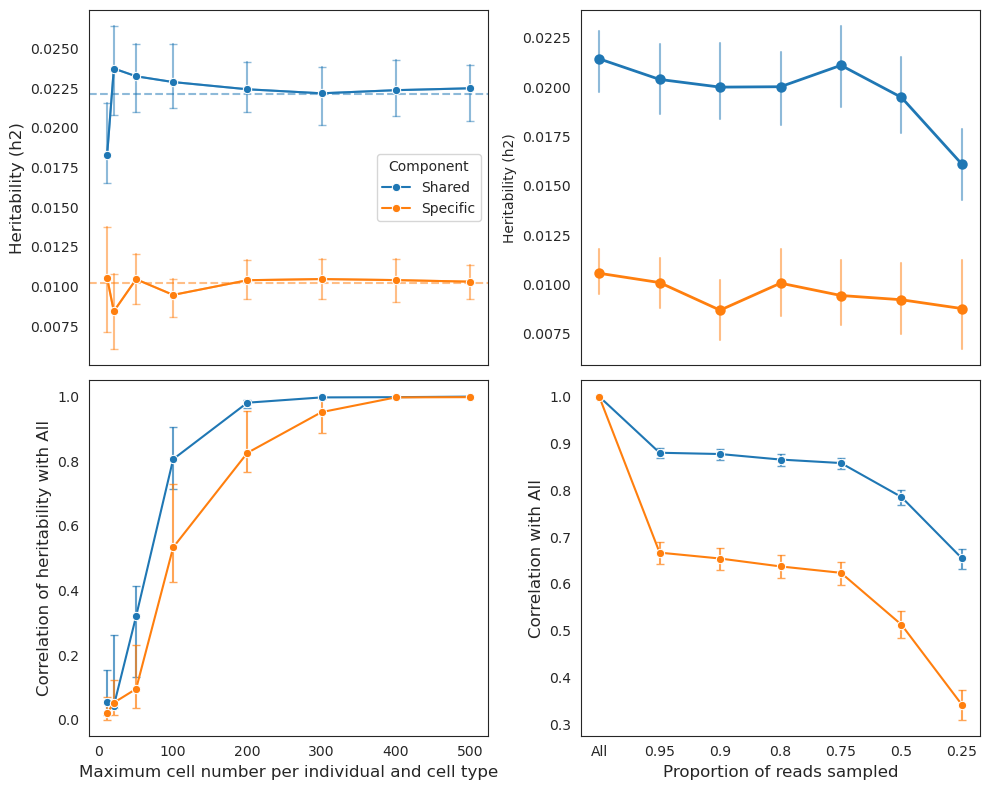

In [31]:
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col')

# cell
ax = axes[0, 0]
tmp_df = merged_cell_df.loc[merged_cell_df['Cell number'] != 'All']
tmp_df['Cell number'] = tmp_df['Cell number'].astype(int)
sns.lineplot(data=tmp_df, x='Cell number', y='Heritability (h2)', hue='Component', estimator='median', 
    ax=ax, palette=[colors[0], colors[1]], err_kws=dict(linewidth=1.5, capsize=3), alpha=.5, err_style='bars', legend=False)
sns.lineplot(data=tmp_df, x='Cell number', y='Heritability (h2)', hue='Component', style='Component', estimator='median',
    ax=ax, palette=[colors[0], colors[1]], dashes=False, markers='o', markersize=6, errorbar=None)

# plot median "All" lines separately for each component (avoid passing an array to axhline)
all_medians = merged_cell_df.loc[merged_cell_df['Cell number'] == 'All'].groupby('Component')['Heritability (h2)'].median()
ax.axhline(y=all_medians['Shared'], color=colors[0], linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
ax.axhline(y=all_medians['Specific'], color=colors[1], linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)

ax.set_xlabel('Maximum cell number per individual and cell type', fontsize=fs)
ax.set_ylabel('Heritability (h2)', fontsize=fs)

print(merged_cell_df.groupby(['Cell number', 'Component'])['Heritability (h2)'].median().unstack())

# correlatin with All
ax = axes[1, 0]

sns.lineplot(data=cell_corr_df, x='Cell number', y='Correlation with All', hue='Component', style='Component', ax=ax, palette=[colors[0], colors[1]],
              dashes=False, markers='o', markersize=6)
# add error bars
print(cell_shared_ci)
print(cell_specific_ci)
for component, color in zip(['Shared', 'Specific'], [colors[0], colors[1]]):
    comp_df = cell_corr_df.loc[cell_corr_df['Component'] == component]
    if component == 'Shared':
        ci_df = cell_shared_ci
    else:
        ci_df = cell_specific_ci
    ax.errorbar(comp_df['Cell number'], comp_df['Correlation with All'], 
                yerr=[comp_df['Correlation with All'] - ci_df['ci_low'].values, ci_df['ci_high'].values - comp_df['Correlation with All']], 
                fmt='none', ecolor=color, capsize=3, alpha=0.7, zorder=1)
    
ax.set_xlabel('Maximum cell number per individual and cell type', fontsize=fs)
ax.set_ylabel('Correlation of heritability with All', fontsize=fs)
ax.legend().set_visible(False)

# read
ax = axes[0, 1]
sns.pointplot(data=merged_read_df, x='Read proportion', y='Heritability (h2)', hue='Component', ax=ax, palette=[colors[0], colors[1]],
              estimator='median',
              markers='o', markersize=6, linewidth=2, err_kws=dict(linewidth=1.5, alpha=0.5),
              order=['All'] + np.sort([float(x) for x in merged_read_df['Read proportion'].unique() if x != 'All'])[::-1].astype(str).tolist())
ax.set_xlabel('Proportion of reads sampled', fontsize=fs)
ax.legend().set_visible(False)

# correlation
ax = axes[1, 1]

sns.lineplot(data=read_corr_df, x='Read proportion', y='Correlation with All', hue='Component', style='Component', ax=ax, palette=[colors[0], colors[1]],
              dashes=False, markers='o', markersize=6)
# add error bars
print(read_shared_ci)
print(read_specific_ci)
for component, color in zip(['Shared', 'Specific'], [colors[0], colors[1]]):
    comp_df = read_corr_df.loc[(read_corr_df['Component'] == component) & (read_corr_df['Read proportion'] != 'All')]
    if component == 'Shared':
        ci_df = read_shared_ci
    else:
        ci_df = read_specific_ci
    print(comp_df)
    print(ci_df)
    assert comp_df['Read proportion'].values.astype(str).tolist() == ci_df.index.values.astype(str).tolist()
    ax.errorbar(comp_df['Read proportion'], comp_df['Correlation with All'], 
                yerr=[comp_df['Correlation with All'] - ci_df['ci_low'].values, ci_df['ci_high'].values - comp_df['Correlation with All']], 
                fmt='none', ecolor=color, capsize=3, alpha=0.7, zorder=1)
    
ax.set_xlabel('Proportion of reads sampled', fontsize=fs)
ax.set_ylabel('Correlation with All', fontsize=fs)
ax.legend().set_visible(False)

fig.tight_layout()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


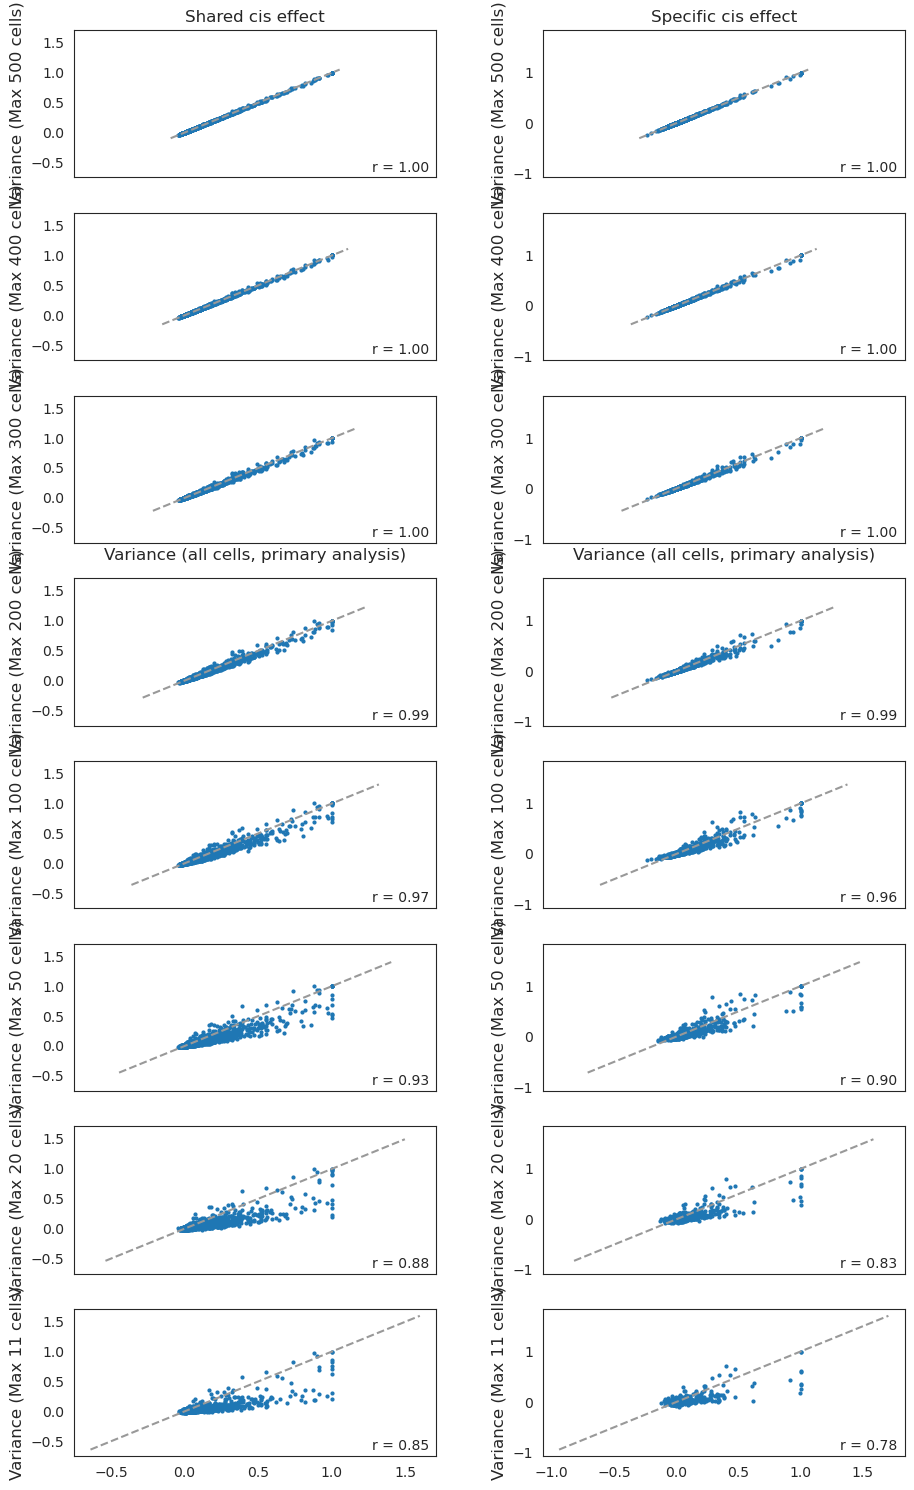

In [32]:
fs = 12
s = 16

fig, axes = plt.subplots(len(cell_data.keys()), 2, figsize=(9, 15), sharex='col', sharey='col')

for i, key in enumerate(list(reversed(cell_data.keys()))):
    tmp_df = cell_data[key]

    axes[i, 0].scatter(tmp_df['free:hom_g2'].clip(np.nan, 1), tmp_df[f'free:hom_g2_{key}'].clip(np.nan, 1), marker='.', s=s)
    r, p = stats.pearsonr(tmp_df['free:hom_g2'], tmp_df[f'free:hom_g2_{key}'])
    print(p)
    axes[i, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[i, 0].transAxes)

    axes[i, 1].scatter(tmp_df['free:v'].clip(np.nan, 1), tmp_df[f'free:v_{key}'].clip(np.nan, 1), marker='.', s=s)
    r, p = stats.pearsonr(tmp_df['free:v'], tmp_df[f'free:v_{key}'])
    print(p)
    axes[i, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[i, 1].transAxes)

    axes[i, 0].set_ylabel(f'Variance (Max {key} cells)', fontsize=fs)
    axes[i, 1].set_ylabel(f'Variance (Max {key} cells)', fontsize=fs)

axes[0, 0].set_title('Shared cis effect')
axes[0, 1].set_title('Specific cis effect')

axes[2, 0].set_xlabel('Variance (all cells, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (all cells, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


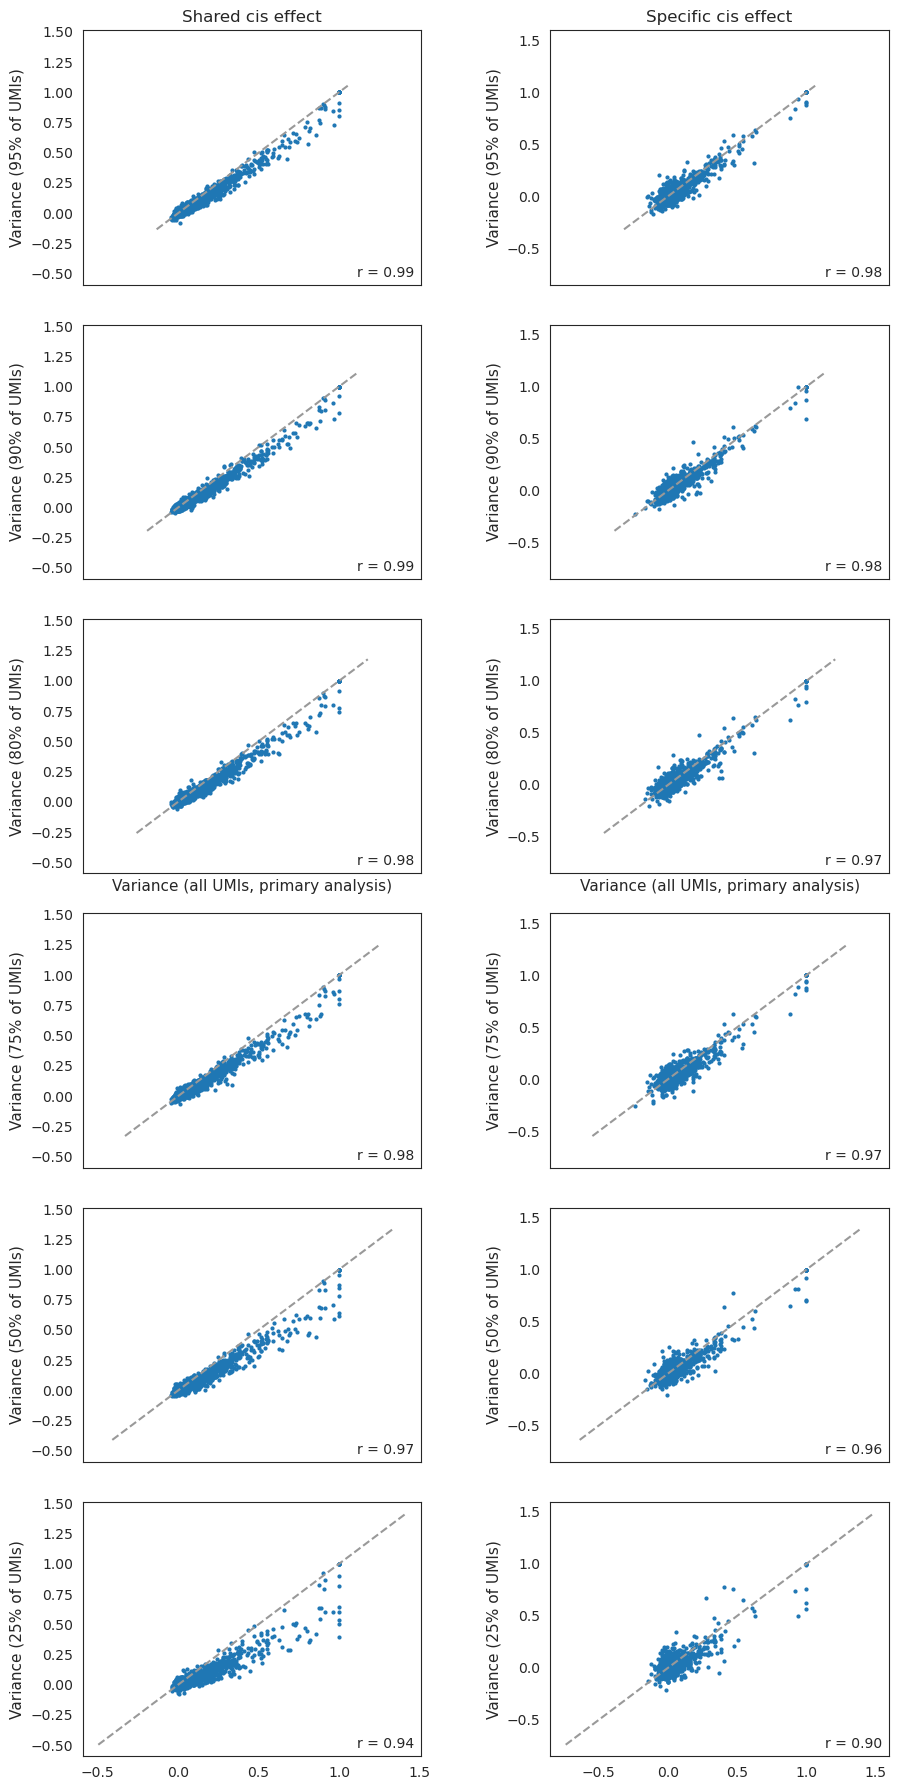

In [33]:
fs = 11
s = 16

fig, axes = plt.subplots(len(read_data.keys()), 2, figsize=(9, 3 * len(read_data.keys())), sharex='col', sharey='col')
for i, key in enumerate(list(reversed(read_data.keys()))):
    tmp_df = read_data[key]

    axes[i, 0].scatter(tmp_df['free:hom_g2'].clip(np.nan, 1), tmp_df[f'free:hom_g2_{key}'].clip(np.nan, 1), marker='.', s=s)
    r, p = stats.pearsonr(tmp_df['free:hom_g2'], tmp_df[f'free:hom_g2_{key}'])
    print(p)
    axes[i, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[i, 0].transAxes)

    axes[i, 1].scatter(tmp_df['free:v'].clip(np.nan, 1), tmp_df[f'free:v_{key}'].clip(np.nan, 1), marker='.', s=s)
    r, p = stats.pearsonr(tmp_df['free:v'], tmp_df[f'free:v_{key}'])
    print(p)
    axes[i, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[i, 1].transAxes)

    axes[i, 0].set_ylabel(f'Variance ({key * 100:.0f}% of UMIs)', fontsize=fs)
    axes[i, 1].set_ylabel(f'Variance ({key * 100:.0f}% of UMIs)', fontsize=fs)

axes[0, 0].set_title('Shared cis effect')
axes[0, 1].set_title('Specific cis effect')

axes[2, 0].set_xlabel('Variance (all UMIs, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (all UMIs, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)


# Geno PC comparison

In [34]:
joint_PC4_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~4_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'
joint_PC8_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~8_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'

joint_PC4 = np.load(joint_PC4_f, allow_pickle=True).item()
joint_PC8 = np.load(joint_PC8_f, allow_pickle=True).item()

# joint_PC4
joint_PC4_data = {'gene': joint_PC4['gene'], 
                'hom_g2': joint_PC4['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_PC4['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_PC4['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_PC4['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_PC4['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_PC4['free']['W'], axis1=1, axis2=2), axis=1),}
joint_PC4_df = pd.DataFrame(joint_PC4_data)

# joint_PC8
joint_PC8_data = {'gene': joint_PC8['gene'],
                'hom_g2': joint_PC8['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_PC8['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_PC8['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_PC8['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_PC8['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_PC8['free']['W'], axis1=1, axis2=2), axis=1)}
joint_PC8_df = pd.DataFrame(joint_PC8_data)

# merge
PC_df = trans_df.merge(joint_PC4_df, on='gene', suffixes=('', '_PC4')).merge(joint_PC8_df, on='gene', suffixes=('', '_PC8'))
# PC_df = trans_df.merge(cis_PC4_df, on='gene', suffixes=('', '_cis_PC4')).merge(cis_PC8_df, on='gene', suffixes=('', '_cis_PC8')).merge(joint_PC4_df, on='gene', suffixes=('', '_joint_PC4')).merge(joint_PC8_df, on='gene', suffixes=('', '_joint_PC8'))
print(PC_df.columns)
print(PC_df.shape)

Index(['gene', 'hom_g2', 'hom_e2', 'hom_g2_p', 'V_bar', 'V_p', 'W_bar',
       'shared_h2', 'specific_h2', 'std_shared_h2', 'std_specific_h2',
       'hom_g2_b', 'V_b_bar', 'bio_var', 'shared_h2_b', 'specific_h2_b',
       'std_shared_h2_b', 'std_specific_h2_b', 'hom_g2_PC4', 'V_bar_PC4',
       'hom_g2_b_PC4', 'V_b_bar_PC4', 'hom_e2_PC4', 'W_bar_PC4', 'hom_g2_PC8',
       'V_bar_PC8', 'hom_g2_b_PC8', 'V_b_bar_PC8', 'hom_e2_PC8', 'W_bar_PC8'],
      dtype='object')
(10288, 30)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


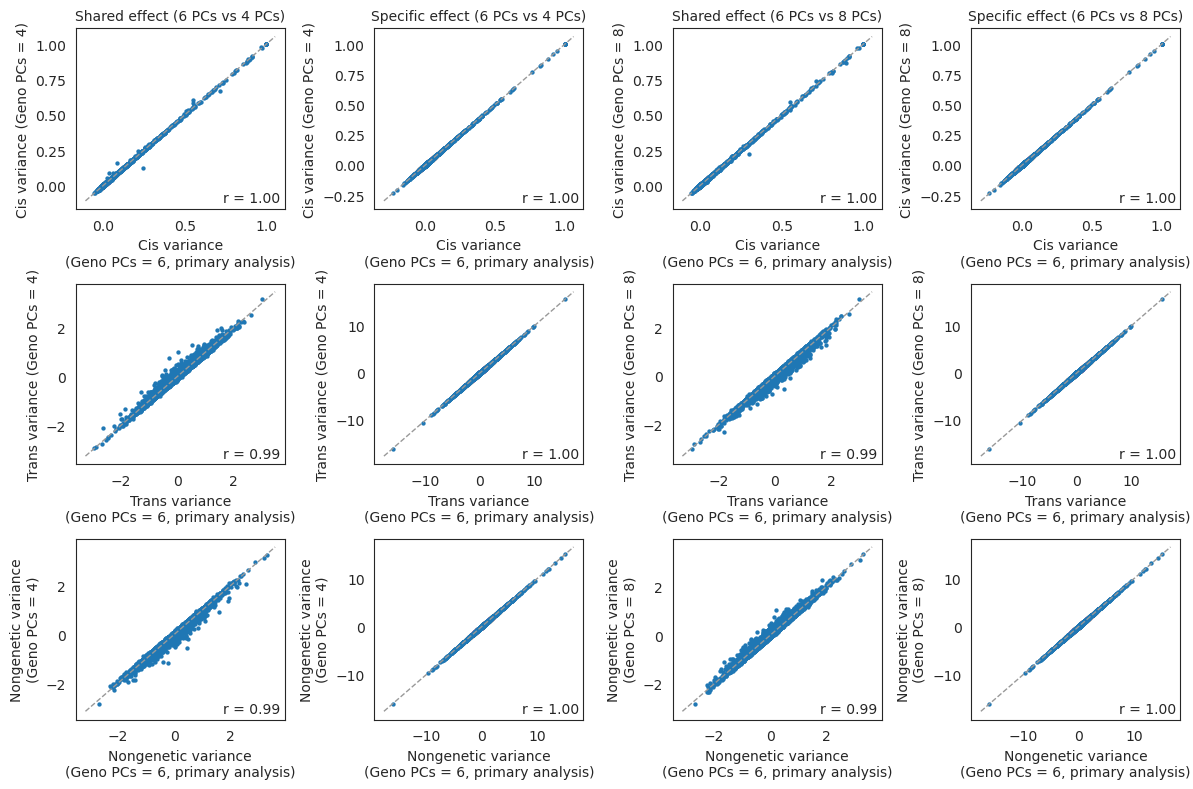

In [35]:
s = 18
fs = 10

# plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

axes[0, 0].scatter(PC_df['hom_g2'].clip(np.nan, 1), PC_df['hom_g2_PC4'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2'], PC_df['hom_g2_PC4'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(PC_df['V_bar'].clip(np.nan, 1), PC_df['V_bar_PC4'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_bar'], PC_df['V_bar_PC4'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

ax = axes[0, 2]
ax.scatter(PC_df['hom_g2'].clip(np.nan, 1), PC_df['hom_g2_PC8'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2'], PC_df['hom_g2_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[0, 3]
ax.scatter(PC_df['V_bar'].clip(np.nan, 1), PC_df['V_bar_PC8'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_bar'], PC_df['V_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 0]
ax.scatter(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 1]
ax.scatter(PC_df['V_b_bar'], PC_df['V_b_bar_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_b_bar'], PC_df['V_b_bar_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 2]
ax.scatter(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 3]
ax.scatter(PC_df['V_b_bar'], PC_df['V_b_bar_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_b_bar'], PC_df['V_b_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 0]
ax.scatter(PC_df['hom_e2'], PC_df['hom_e2_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_e2'], PC_df['hom_e2_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 1]
ax.scatter(PC_df['W_bar'], PC_df['W_bar_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['W_bar'], PC_df['W_bar_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 2]
ax.scatter(PC_df['hom_e2'], PC_df['hom_e2_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_e2'], PC_df['hom_e2_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 3]
ax.scatter(PC_df['W_bar'], PC_df['W_bar_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['W_bar'], PC_df['W_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)


axes[0, 0].set_title('Shared effect (6 PCs vs 4 PCs)', fontsize=fs)
axes[0, 1].set_title('Specific effect (6 PCs vs 4 PCs)', fontsize=fs)
axes[0, 2].set_title('Shared effect (6 PCs vs 8 PCs)', fontsize=fs)
axes[0, 3].set_title('Specific effect (6 PCs vs 8 PCs)', fontsize=fs)

axes[0, 0].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 0].set_ylabel('Cis variance (Geno PCs = 4)')
axes[0, 1].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 1].set_ylabel('Cis variance (Geno PCs = 4)')

axes[0, 2].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 2].set_ylabel('Cis variance (Geno PCs = 8)')
axes[0, 3].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 3].set_ylabel('Cis variance (Geno PCs = 8)')

axes[1, 0].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 0].set_ylabel('Trans variance (Geno PCs = 4)')
axes[1, 1].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 1].set_ylabel('Trans variance (Geno PCs = 4)')

axes[1, 2].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 2].set_ylabel('Trans variance (Geno PCs = 8)')
axes[1, 3].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 3].set_ylabel('Trans variance (Geno PCs = 8)')

axes[2, 0].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 0].set_ylabel('Nongenetic variance\n(Geno PCs = 4)')
axes[2, 1].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 1].set_ylabel('Nongenetic variance\n(Geno PCs = 4)')

axes[2, 2].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 2].set_ylabel('Nongenetic variance\n(Geno PCs = 8)')
axes[2, 3].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 3].set_ylabel('Nongenetic variance\n(Geno PCs = 8)')

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=1)

fig.tight_layout()

# Shared vs specific fixed or random effects

In [36]:
specific_batch_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~specific_fixed~shared/trans/he.npy'
specific_fixed_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~specific/trans/he.npy'
specific_both_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~specific_fixed~specific/trans/he.npy'

specific_batch = np.load(specific_batch_f, allow_pickle=True).item()
specific_fixed = np.load(specific_fixed_f, allow_pickle=True).item()
specific_both = np.load(specific_both_f, allow_pickle=True).item()

# specific batch
specific_batch_data = {'gene': specific_batch['gene'], 
                'hom_g2': specific_batch['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_batch['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_batch['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_batch['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_batch['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_batch['free']['W'], axis1=1, axis2=2), axis=1),}
specific_batch_df = pd.DataFrame(specific_batch_data)

# specific fixed
specific_fixed_data = {'gene': specific_fixed['gene'],
                'hom_g2': specific_fixed['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_fixed['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_fixed['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_fixed['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_fixed['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_fixed['free']['W'], axis1=1, axis2=2), axis=1)}
specific_fixed_df = pd.DataFrame(specific_fixed_data)

# specific both
specific_both_data = {'gene': specific_both['gene'],
                'hom_g2': specific_both['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_both['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_both['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_both['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_both['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_both['free']['W'], axis1=1, axis2=2), axis=1)}
specific_both_df = pd.DataFrame(specific_both_data)

# merge
specific_df = trans_df.merge(specific_batch_df, on='gene', suffixes=('', '_specific_batch')).merge(specific_fixed_df, on='gene', suffixes=('', '_specific_fixed')).merge(specific_both_df, on='gene', suffixes=('', '_specific_both'))
print(specific_df.columns)
print(specific_df.shape)

Index(['gene', 'hom_g2', 'hom_e2', 'hom_g2_p', 'V_bar', 'V_p', 'W_bar',
       'shared_h2', 'specific_h2', 'std_shared_h2', 'std_specific_h2',
       'hom_g2_b', 'V_b_bar', 'bio_var', 'shared_h2_b', 'specific_h2_b',
       'std_shared_h2_b', 'std_specific_h2_b', 'hom_g2_specific_batch',
       'V_bar_specific_batch', 'hom_g2_b_specific_batch',
       'V_b_bar_specific_batch', 'hom_e2_specific_batch',
       'W_bar_specific_batch', 'hom_g2_specific_fixed', 'V_bar_specific_fixed',
       'hom_g2_b_specific_fixed', 'V_b_bar_specific_fixed',
       'hom_e2_specific_fixed', 'W_bar_specific_fixed', 'hom_g2_specific_both',
       'V_bar_specific_both', 'hom_g2_b_specific_both',
       'V_b_bar_specific_both', 'hom_e2_specific_both', 'W_bar_specific_both'],
      dtype='object')
(10288, 36)


In [37]:
print(stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_batch']))
print(stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed']))
print(stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_batch']))
stats.pearsonr(specific_batch['free']['r2']['batch'].mean(axis=1), trans['free']['r2']['batch'])

PearsonRResult(statistic=np.float64(0.9618921136249625), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9909358660259202), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9902657875872349), pvalue=np.float64(0.0))


PearsonRResult(statistic=np.float64(0.7830221030624743), pvalue=np.float64(0.0))

In [38]:
print(np.diagonal(specific_batch['free']['V_b'], axis1=1, axis2=2)[0])
print(np.diagonal(trans['free']['V_b'], axis1=1, axis2=2)[0])
print('***************')
print(np.diagonal(specific_batch['free']['W'], axis1=1, axis2=2)[0])
print(np.diagonal(trans['free']['W'], axis1=1, axis2=2)[0])
print('***************')
print(specific_batch['free']['r2']['batch'][0])
print(trans['free']['r2']['batch'][0])


[-6.18228006 -7.29555567  2.72258732  1.28568988  0.80614188  1.87150438
 -1.54822097]
[-6.17246814 -7.28952511  2.72075072  1.28933895  0.81346384  1.87587319
 -1.54614339]
***************
[ 5.06193661  6.22328665 -2.29828743 -1.31290158 -0.65451693 -1.99786046
  2.5442579 ]
[ 5.34283181  6.38928097 -2.37134561 -1.21927158 -0.44928199 -1.8823602
  2.5901363 ]
***************
[ 0.29493959  0.1743233  -0.07662017  0.09835943  0.21551583  0.12131755
  0.04823256]
0.19418907422683548


0.0
0.0
0.0
0.0
0.0
0.0


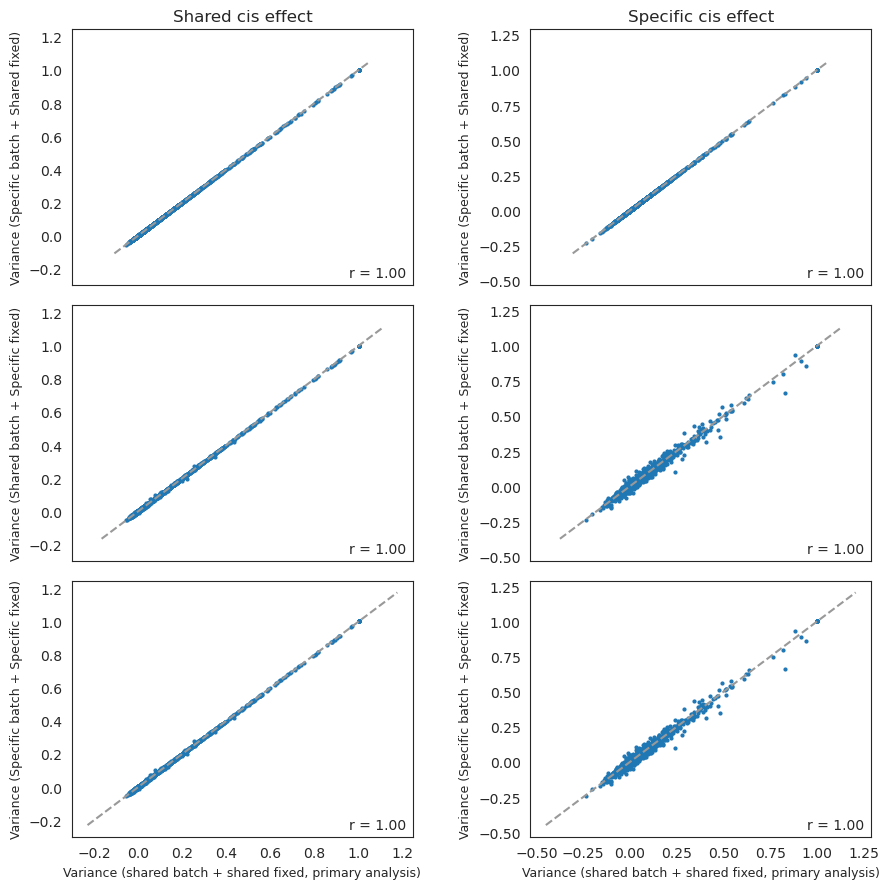

In [39]:
fs = 9
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_batch'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_batch'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)


axes[1, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_fixed'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_fixed'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)


axes[2, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_both'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_both'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)



axes[0, 0].set_title('Shared cis effect')
axes[0, 1].set_title('Specific cis effect')

axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)

axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

0.0
0.0
0.0
0.0
0.0
0.0


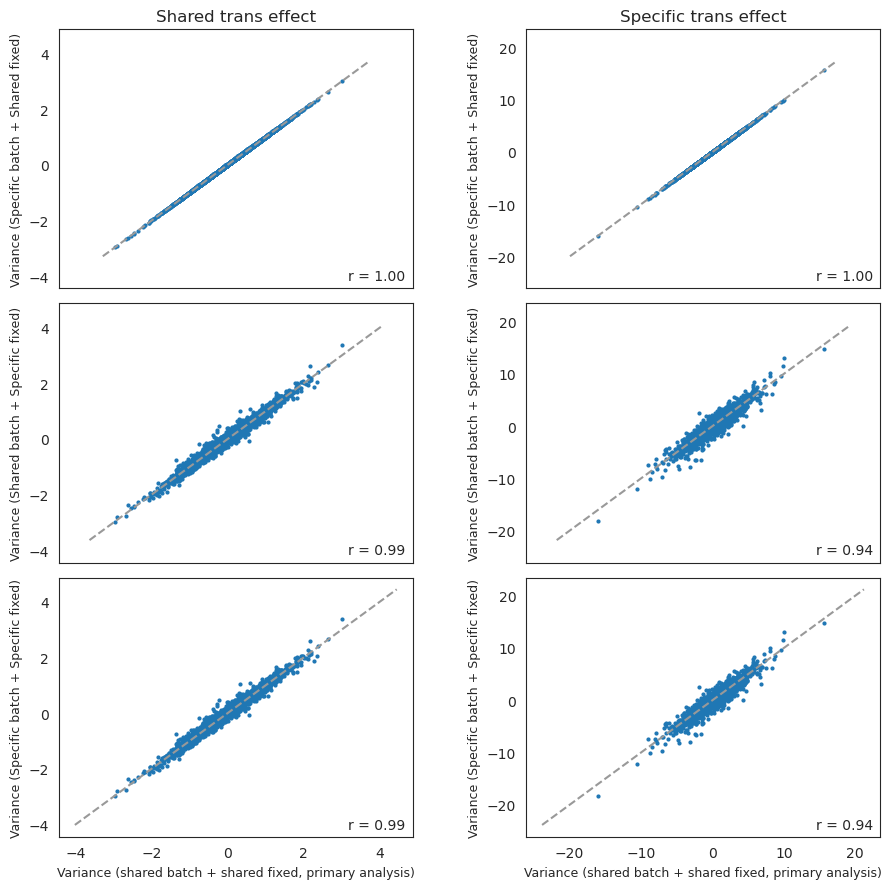

In [40]:
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[1, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[2, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)

axes[0, 0].set_title('Shared trans effect')
axes[0, 1].set_title('Specific trans effect')
axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

0.0
0.0
0.0
0.0
0.0
0.0


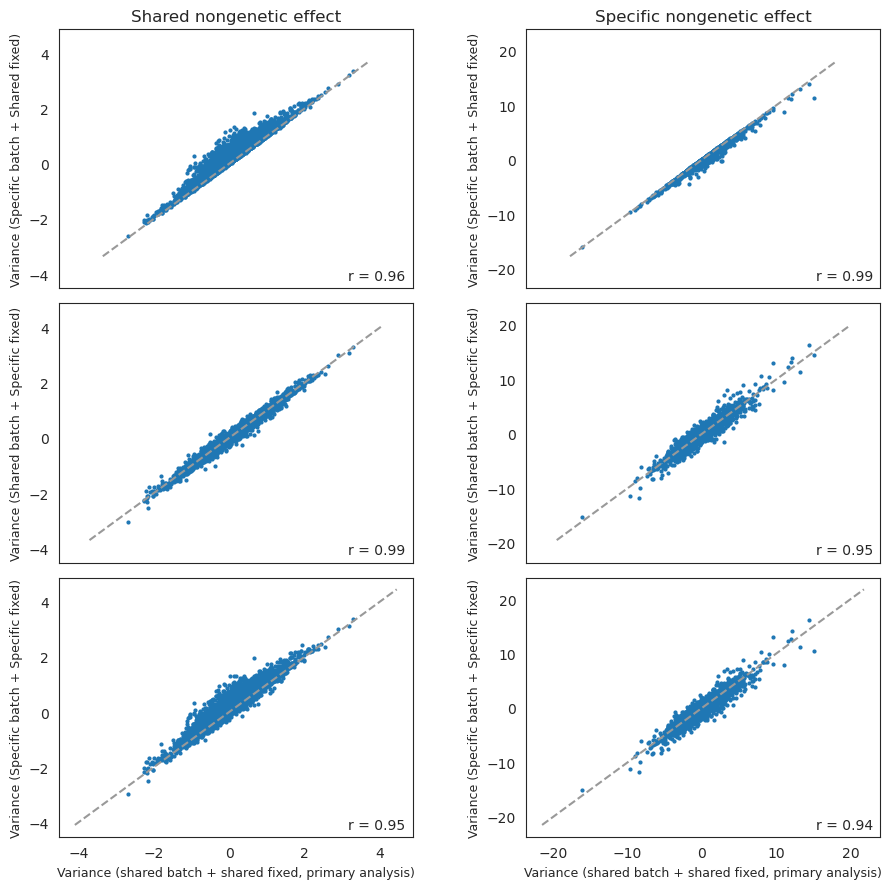

In [41]:
fs = 9
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)


axes[1, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)


axes[2, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)



axes[0, 0].set_title('Shared nongenetic effect')
axes[0, 1].set_title('Specific nongenetic effect')

axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)

axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

# Cell type number

## Extracting cell types from main analysis

In [42]:
joint_ct4_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/mainct/he.npy'
joint_ct4_P_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/mainct/P.final.gz'

joint_ct4 = np.load(joint_ct4_f, allow_pickle=True).item()
joint_ct4_P = pd.read_table(joint_ct4_P_f, index_col=0)
ct4_cts = joint_ct4_P.columns.to_numpy()
print(ct4_cts)
default_cts = P.columns.to_numpy()

# joint_ct4
joint_ct4_data = {'gene': joint_ct4['gene'], 
                'hom_g2': joint_ct4['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_ct4['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_ct4['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_ct4['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_ct4['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_ct4['free']['W'], axis1=1, axis2=2), axis=1),}
joint_ct4_df = pd.DataFrame(joint_ct4_data)


# merge
default_in_ct4 = np.isin(default_cts, ct4_cts)
trans_ct_df = pd.DataFrame({'gene': trans['gene'], 
                            'hom_g2': trans['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(trans['free']['V'], axis1=1, axis2=2)[:, default_in_ct4], axis=1),
                            'hom_g2_b': trans['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(trans['free']['V_b'], axis1=1, axis2=2)[:, default_in_ct4], axis=1),
                            'hom_e2': trans['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(trans['free']['W'], axis1=1, axis2=2)[:, default_in_ct4], axis=1)})
merge_ct4_df = trans_ct_df.merge(joint_ct4_df, on='gene', suffixes=('', '_ct4'))

['CD4 NC' 'CD8 ET' 'CD8 NC' 'NK']


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


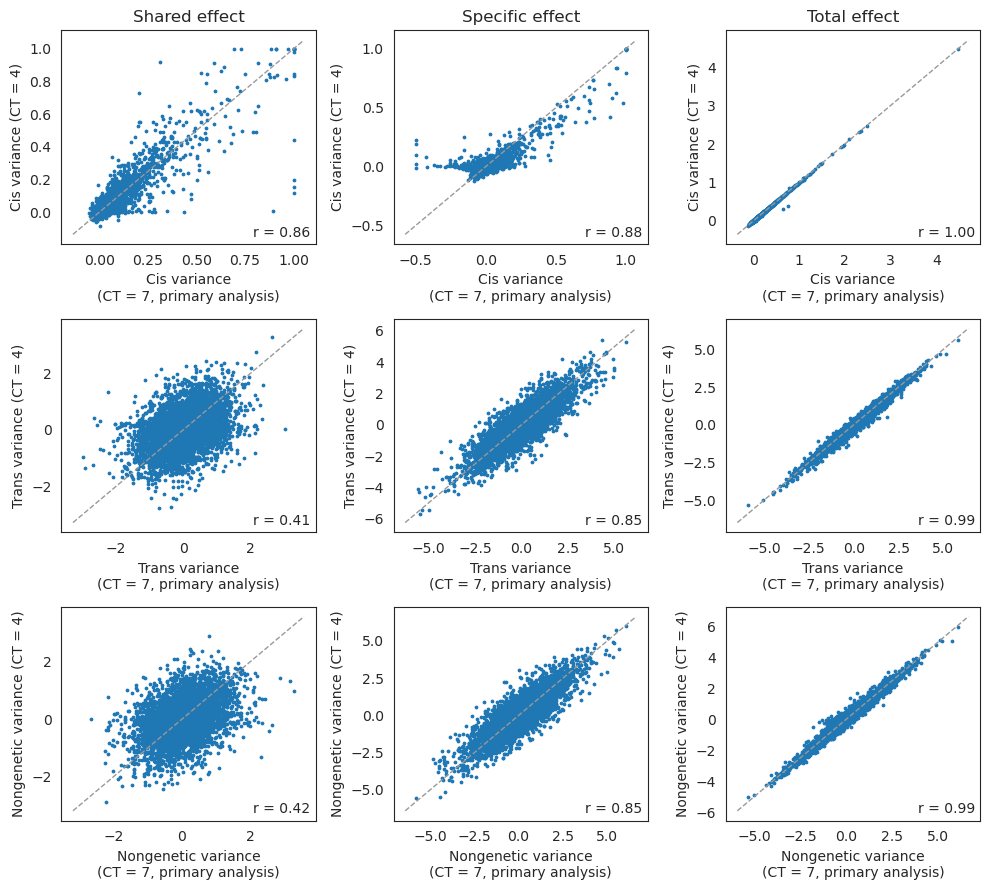

In [43]:
s = 12
lw = 1

# plot
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

axes[0, 0].scatter(merge_ct4_df['hom_g2'].clip(np.nan, 1), merge_ct4_df['hom_g2_ct4'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2'].clip(np.nan, 1), merge_ct4_df['hom_g2_ct4'].clip(np.nan, 1.), s=6, ax=axes[0, 0], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2'], merge_ct4_df['hom_g2_ct4'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(merge_ct4_df['V_bar'].clip(-.5, 1), merge_ct4_df['V_bar_ct4'].clip(-.5, 1.), marker='.', s=s)
# plot.scatter(merge_ct4_df['V_bar'].clip(-.5, 1), merge_ct4_df['V_bar_ct4'].clip(-.5, 1.), s=6, ax=axes[0, 1], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['V_bar'], merge_ct4_df['V_bar_ct4'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[0, 2].scatter(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'], s=6, ax=axes[0, 2], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'])
print(p)
axes[0, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 2].transAxes)


axes[1, 0].scatter(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'], s=6, ax=axes[1, 0], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'], s=6, ax=axes[1, 1], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[1, 2].scatter(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'], s=6, ax=axes[1, 2], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'])
print(p)
axes[1, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 2].transAxes)


axes[2, 0].scatter(merge_ct4_df['hom_e2'], merge_ct4_df['hom_e2_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['hom_e2'], merge_ct4_df['hom_e2_ct4'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(merge_ct4_df['W_bar'], merge_ct4_df['W_bar_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['W_bar'], merge_ct4_df['W_bar_ct4'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)

axes[2, 2].scatter(merge_ct4_df['hom_e2'] + merge_ct4_df['W_bar'], merge_ct4_df['hom_e2_ct4'] + merge_ct4_df['W_bar_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['hom_e2'] + merge_ct4_df['W_bar'], merge_ct4_df['hom_e2_ct4'] + merge_ct4_df['W_bar_ct4'])
print(p)
axes[2, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 2].transAxes)


axes[0, 0].set_title('Shared effect')
axes[0, 1].set_title('Specific effect')
axes[0, 2].set_title('Total effect')

# x y lables
for ax in axes[0]:
    ax.set_xlabel('Cis variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Cis variance (CT = 4)')

for ax in axes[1]:
    ax.set_xlabel('Trans variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Trans variance (CT = 4)')

for ax in axes[2]:
    ax.set_xlabel('Nongenetic variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Nongenetic variance (CT = 4)')


# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=lw)

fig.tight_layout()

# Transformation

In [44]:
joint_cpm_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/transform_logp_cpm/trans/he.npy'

joint_cpm = np.load(joint_cpm_f, allow_pickle=True).item()

# joint_cpm
joint_cpm_data = {'gene': joint_cpm['gene'], 
                'hom_g2': joint_cpm['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_cpm['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_cpm['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_cpm['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_cpm['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_cpm['free']['W'], axis1=1, axis2=2), axis=1),}
joint_cpm_df = pd.DataFrame(joint_cpm_data)


# merge
merge_cpm_df = trans_df.merge(joint_cpm_df, on='gene', suffixes=('', '_cpm'))

0.0
0.0
0.0
0.0
0.0
0.0


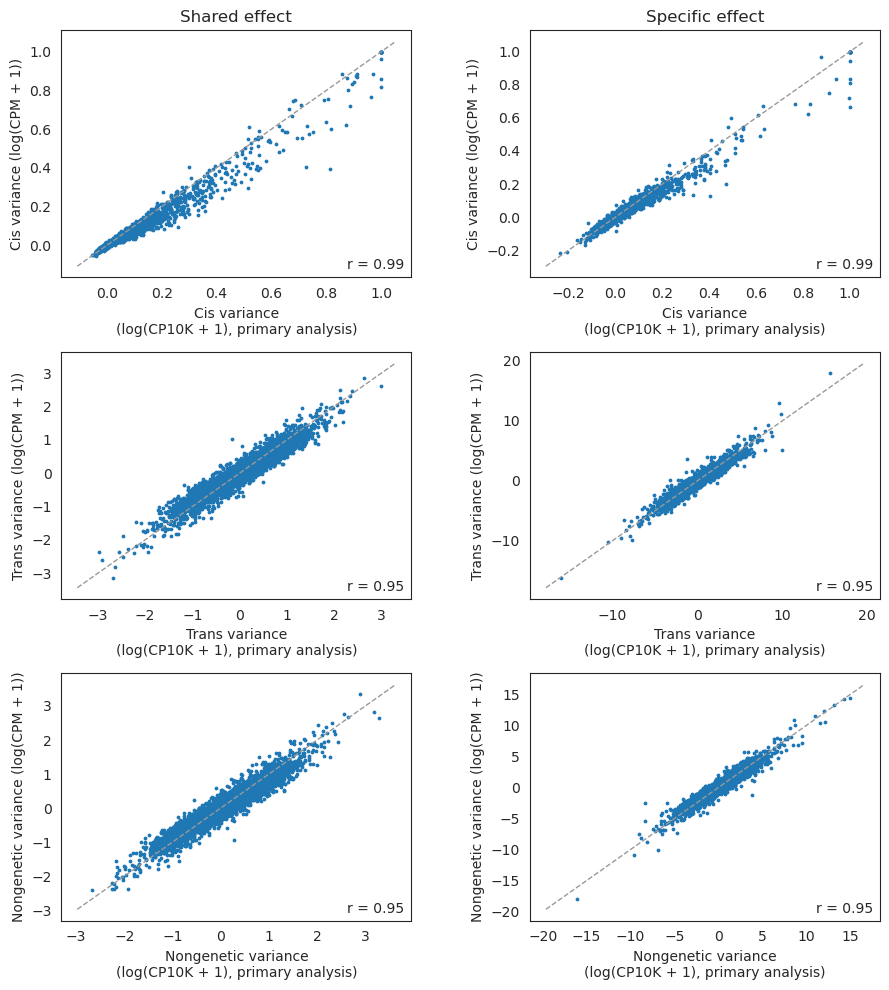

In [45]:
s = 12
lw = 1

# plot
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

axes[0, 0].scatter(merge_cpm_df['hom_g2'].clip(np.nan, 1), merge_cpm_df['hom_g2_cpm'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_cpm_df['hom_g2'].clip(np.nan, 1), merge_cpm_df['hom_g2_cpm'].clip(np.nan, 1.), s=6, ax=axes[0, 0], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['hom_g2'], merge_cpm_df['hom_g2_cpm'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(merge_cpm_df['V_bar'].clip(np.nan, 1), merge_cpm_df['V_bar_cpm'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_cpm_df['V_bar'].clip(np.nan, 1), merge_cpm_df['V_bar_cpm'].clip(np.nan, 1.), s=6, ax=axes[0, 1], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['V_bar'], merge_cpm_df['V_bar_cpm'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[1, 0].scatter(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'], marker='.', s=s)
# plot.scatter(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'], s=6, ax=axes[1, 0], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'], marker='.', s=s)
# plot.scatter(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'], s=6, ax=axes[1, 1], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[2, 0].scatter(merge_cpm_df['hom_e2'], merge_cpm_df['hom_e2_cpm'], marker='.', s=s)
r, p = stats.pearsonr(merge_cpm_df['hom_e2'], merge_cpm_df['hom_e2_cpm'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(merge_cpm_df['W_bar'], merge_cpm_df['W_bar_cpm'], marker='.', s=s)
r, p = stats.pearsonr(merge_cpm_df['W_bar'], merge_cpm_df['W_bar_cpm'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)


axes[0, 0].set_title('Shared effect')
axes[0, 1].set_title('Specific effect')

# x y labels
for ax in axes[0]:
    ax.set_xlabel('Cis variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Cis variance (log(CPM + 1))')
for ax in axes[1]:
    ax.set_xlabel('Trans variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Trans variance (log(CPM + 1))')
for ax in axes[2]:
    ax.set_xlabel('Nongenetic variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Nongenetic variance (log(CPM + 1))')


# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=lw)

fig.tight_layout(w_pad=4)

# Variance decomposition

Number of genes: (8701, 28)
OP h2: 0.055235948904285986 0.003120003857523127 0.24420587714315908 0.049798733231837554
Specific h2 in cis: 0.05346504872018823
Proportion of trans h2: 0.8343856865186354
CTP h2 0.023324418431451124 0.01053416488558596 0.10136985303533792 0.14757056402942126
Specific h2 in cis 0.31112243495094316
Proportion of trans h2: 0.8802733274469644
CTP - OP trans proportion: 0.04588764092832898
Permutation p: 0.005


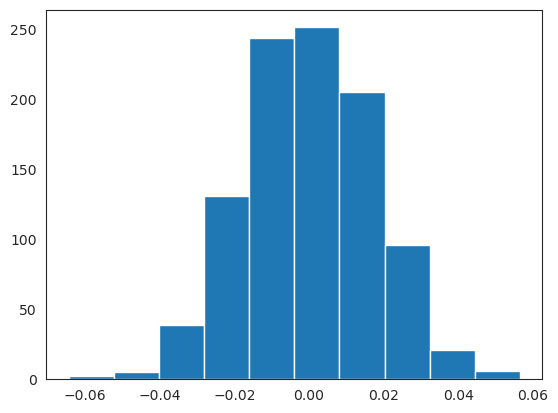

In [46]:
nu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/nu.final.gz', index_col=0)[cis['gene']]
ctnu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ctnu.final.gz', index_col=0)[cis['gene']]
assert np.all(trans['gene'] == nu.columns.to_numpy()) and np.all(trans['gene'] == ctnu.columns.to_numpy())

N, C = P.shape

# OP variance components
trans_op_data = {
    'Batch': trans['free']['op_random_vars']['batch'],
    'Cell Type Mean': trans['free']['op_fixed_vars']['ct_beta'], 
    'Overall Pseudobulk PC': trans['free']['op_fixed_vars']['op_pca'],
    'Sex': trans['free']['op_fixed_vars']['sex'],
    'Age':trans['free']['op_fixed_vars']['age'],
    'Genotype PC': trans['free']['op_fixed_vars']['geno_pca'],
    'Shared Genetics (cis)': trans['free']['hom_g2'],
    'Shared Nongenetics': trans['free']['hom_e2'],
    'Specific Genetics (cis)': np.trace(trans['free']['V'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Specific Nongenetics': np.trace(trans['free']['W'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Shared Genetics (trans)': trans['free']['hom_g2_b'],
    'Specific Genetics (trans)': np.trace(trans['free']['V_b'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Cell Noise': nu.mean().to_numpy(),
    }


trans_op_df = pd.DataFrame(trans_op_data, index=cis['gene'])

# total op variance
trans_op_df['Total'] = trans_op_df.sum(axis=1)

# print(f"Proportion of specific in cis: {trans_op_df['Specific Genetics (cis)'].mean() / (trans_op_df['Specific Genetics (cis)'].mean() + trans_op_df['Shared Genetics (cis)'].mean())}")
# print(f"Proportion of specific in trans: {trans_op_df['Specific Genetics (trans)'].mean() / (trans_op_df['Specific Genetics (trans)'].mean() + trans_op_df['Shared Genetics (trans)'].mean())}")
# print(f"Proportion of trans: {(trans_op_df['Specific Genetics (trans)'] + trans_op_df['Shared Genetics (trans)']).mean() / (trans_op_df['Specific Genetics (trans)'] + trans_op_df['Shared Genetics (trans)'] + trans_op_df['Specific Genetics (cis)'] + trans_op_df['Shared Genetics (cis)']).mean()}")

# add gene
trans_op_df['gene'] = trans['gene']

# add CTP variance
trans_op_df['v_bar'] = np.diagonal(trans['free']['V'], axis1=1, axis2=2).mean(axis=1)
trans_op_df['v_bar (trans)'] = np.diagonal(trans['free']['V_b'], axis1=1, axis2=2).mean(axis=1)
trans_op_df['w_bar'] = np.diagonal(trans['free']['W'], axis1=1, axis2=2).mean(axis=1)

# OP h2
trans_op_df['total variance'] = (trans_op_df['Shared Genetics (cis)'] + trans_op_df['Specific Genetics (cis)'] 
                            + trans_op_df['Shared Genetics (trans)'] + trans_op_df['Specific Genetics (trans)']
                            + trans_op_df['Shared Nongenetics'] + trans_op_df['Specific Nongenetics'])

trans_op_df['Shared h2 (cis)'] = trans_op_df['Shared Genetics (cis)'] / trans_op_df['total variance']
trans_op_df['Specific h2 (cis)'] = trans_op_df['Specific Genetics (cis)'] / trans_op_df['total variance']
trans_op_df['Shared h2 (trans)'] = trans_op_df['Shared Genetics (trans)'] / trans_op_df['total variance']
trans_op_df['Specific h2 (trans)'] = trans_op_df['Specific Genetics (trans)'] / trans_op_df['total variance']

# CTP h2
trans_op_df['ctp total variance'] = (trans_op_df['Shared Genetics (cis)'] + trans_op_df['v_bar'] 
                            + trans_op_df['Shared Genetics (trans)'] + trans_op_df['v_bar (trans)']
                            + trans_op_df['Shared Nongenetics'] + trans_op_df['w_bar'])

trans_op_df['ctp Shared h2 (cis)'] = trans_op_df['Shared Genetics (cis)'] / trans_op_df['ctp total variance']
trans_op_df['ctp Specific h2 (cis)'] = trans_op_df['v_bar'] / trans_op_df['ctp total variance']
trans_op_df['ctp Shared h2 (trans)'] = trans_op_df['Shared Genetics (trans)'] / trans_op_df['ctp total variance']
trans_op_df['ctp Specific h2 (trans)'] = trans_op_df['v_bar (trans)'] / trans_op_df['ctp total variance']

# filter
filtered_trans_op_df = trans_op_df.loc[(trans_op_df['total variance'] > 0) & (trans_op_df['ctp total variance'] > 0)]
print('Number of genes:', filtered_trans_op_df.shape)

# proportion of h2
median_shared_h2_cis = filtered_trans_op_df['Shared h2 (cis)'].median()
median_specific_h2_cis = filtered_trans_op_df['Specific h2 (cis)'].median()
median_shared_h2_trans = filtered_trans_op_df['Shared h2 (trans)'].median()
median_specific_h2_trans = filtered_trans_op_df['Specific h2 (trans)'].median()
median_h2_cis = median_shared_h2_cis + median_specific_h2_cis
median_h2_trans = median_shared_h2_trans + median_specific_h2_trans

print('OP h2:', median_shared_h2_cis, median_specific_h2_cis, median_shared_h2_trans, median_specific_h2_trans)

print('Specific h2 in cis:', median_specific_h2_cis / median_h2_cis)
# print(median_specific_h2_trans / median_h2_trans)
trans_prop = median_h2_trans / (median_h2_cis + median_h2_trans)
print('Proportion of trans h2:', trans_prop)

## proportion of ctp h2
median_ctp_shared_h2_cis = filtered_trans_op_df['ctp Shared h2 (cis)'].median()
median_ctp_specific_h2_cis = filtered_trans_op_df['ctp Specific h2 (cis)'].median()
median_ctp_shared_h2_trans = filtered_trans_op_df['ctp Shared h2 (trans)'].median()
median_ctp_specific_h2_trans = filtered_trans_op_df['ctp Specific h2 (trans)'].median()
median_ctp_h2_cis = median_ctp_shared_h2_cis + median_ctp_specific_h2_cis
median_ctp_h2_trans = median_ctp_shared_h2_trans + median_ctp_specific_h2_trans

print('CTP h2', median_ctp_shared_h2_cis, median_ctp_specific_h2_cis, median_ctp_shared_h2_trans, median_ctp_specific_h2_trans)

print('Specific h2 in cis', median_ctp_specific_h2_cis / median_ctp_h2_cis)
ctp_trans_prop = median_ctp_h2_trans / (median_ctp_h2_cis + median_ctp_h2_trans)
print('Proportion of trans h2:', ctp_trans_prop)

prop_diff = ctp_trans_prop - trans_prop
print('CTP - OP trans proportion:', prop_diff)

# permutation
rng = np.random.default_rng(123)
def cal_trans_prop(shared_cis, specific_cis, shared_trans, specific_trans): 
    shared_cis_median = np.median(shared_cis)
    specific_cis_median = np.median(specific_cis)
    shared_trans_median = np.median(shared_trans)
    specific_trans_median = np.median(specific_trans)
    cis_median = shared_cis_median + specific_cis_median
    trans_median = shared_trans_median + specific_trans_median

    return trans_median / (cis_median + trans_median)

combined = np.vstack([
    filtered_trans_op_df[['Shared h2 (cis)', 'Specific h2 (cis)', 'Shared h2 (trans)', 'Specific h2 (trans)']].values,
    filtered_trans_op_df[['ctp Shared h2 (cis)', 'ctp Specific h2 (cis)', 'ctp Shared h2 (trans)', 'ctp Specific h2 (trans)']].values,
])
k = 999
prop_diffs = []
for i in range(k):
    rng.shuffle(combined)
    op_perm = combined[:filtered_trans_op_df.shape[0]]
    ctp_perm = combined[filtered_trans_op_df.shape[0]:]
    op_prop = cal_trans_prop(op_perm[:, 0], op_perm[:, 1], op_perm[:, 2], op_perm[:, 3])
    ctp_prop = cal_trans_prop(ctp_perm[:, 0], ctp_perm[:, 1], ctp_perm[:, 2], ctp_perm[:, 3])
    prop_diffs.append(ctp_prop - op_prop)

prop_diffs = np.array(prop_diffs)
p = (1 + (prop_diffs > prop_diff).sum()) / (k + 1)
print('Permutation p:', p)
plt.hist(prop_diffs)

## confidence interval
median_shared_h2_cis_ci = stats.bootstrap((filtered_trans_op_df['Shared h2 (cis)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_specific_h2_cis_ci = stats.bootstrap((filtered_trans_op_df['Specific h2 (cis)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_shared_h2_trans_ci = stats.bootstrap((filtered_trans_op_df['Shared h2 (trans)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_specific_h2_trans_ci = stats.bootstrap((filtered_trans_op_df['Specific h2 (trans)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval


In [47]:
for f in ['ratio of means', 'mean of ratios']:
    print(f)
    if f == 'mean of ratios':
        # op h2
        f_shared_h2_cis = filtered_trans_op_df['Shared h2 (cis)'].mean()
        f_specific_h2_cis = filtered_trans_op_df['Specific h2 (cis)'].mean()
        f_shared_h2_trans = filtered_trans_op_df['Shared h2 (trans)'].mean()
        f_specific_h2_trans = filtered_trans_op_df['Specific h2 (trans)'].mean()
        f_h2_cis = f_shared_h2_cis + f_specific_h2_cis
        f_h2_trans = f_shared_h2_trans + f_specific_h2_trans

        # ctp h2
        f_ctp_shared_h2_cis = filtered_trans_op_df['ctp Shared h2 (cis)'].mean()
        f_ctp_specific_h2_cis = filtered_trans_op_df['ctp Specific h2 (cis)'].mean()
        f_ctp_shared_h2_trans = filtered_trans_op_df['ctp Shared h2 (trans)'].mean()
        f_ctp_specific_h2_trans = filtered_trans_op_df['ctp Specific h2 (trans)'].mean()
        f_ctp_h2_cis = f_ctp_shared_h2_cis + f_ctp_specific_h2_cis
        f_ctp_h2_trans = f_ctp_shared_h2_trans + f_ctp_specific_h2_trans
    
    elif f == 'ratio of means':
        # op h2
        f_shared_h2_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_specific_h2_cis = filtered_trans_op_df['Specific Genetics (cis)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_shared_h2_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_specific_h2_trans = filtered_trans_op_df['Specific Genetics (trans)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_h2_cis = f_shared_h2_cis + f_specific_h2_cis
        f_h2_trans = f_shared_h2_trans + f_specific_h2_trans

        # ctp h2
        f_ctp_shared_h2_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_specific_h2_cis = filtered_trans_op_df['v_bar'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_shared_h2_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_specific_h2_trans = filtered_trans_op_df['v_bar (trans)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_h2_cis = f_ctp_shared_h2_cis + f_ctp_specific_h2_cis
        f_ctp_h2_trans = f_ctp_shared_h2_trans + f_ctp_specific_h2_trans
    

    print('OP h2:', f_shared_h2_cis, f_specific_h2_cis, 
        f_shared_h2_trans, f_specific_h2_trans)

    print('Specific h2 in cis:', f_specific_h2_cis / f_h2_cis)
    trans_prop = f_h2_trans / (f_h2_cis + f_h2_trans)
    print('Proportion of trans h2:', trans_prop)

    print('CTP h2', f_ctp_shared_h2_cis, f_ctp_specific_h2_cis, 
        f_ctp_shared_h2_trans, f_ctp_specific_h2_trans)

    print('Specific h2 in cis', f_ctp_specific_h2_cis / f_ctp_h2_cis)
    ctp_trans_prop = f_ctp_h2_trans / (f_ctp_h2_cis + f_ctp_h2_trans)
    print('Proportion of trans h2:', ctp_trans_prop)

    prop_diff = ctp_trans_prop - trans_prop
    print('CTP - OP trans proportion:', prop_diff)


ratio of means
OP h2: 0.2127832850185126 0.015068602735680304 0.23811127094236162 0.04689868370817187
Specific h2 in cis: 0.0661333240826003
Proportion of trans h2: 0.55572462422661
CTP h2 0.08568175490439632 0.04547921659152925 0.09588061183980093 0.11715282467038964
Specific h2 in cis 0.3467435173194187
Proportion of trans h2: 0.6189334618893783
CTP - OP trans proportion: 0.0632088376627683
mean of ratios
OP h2: 0.49174371121776883 0.09088734442993499 2.925491794503591 -0.4312702408571116
Specific h2 in cis: 0.15599467887769325
Proportion of trans h2: 0.8106405702087378
CTP h2 0.15192839303100028 0.051908380448978164 0.31377329582847036 0.8338155756413952
Specific h2 in cis 0.25465660372649485
Proportion of trans h2: 0.8491690798959617
CTP - OP trans proportion: 0.03852850968722388


[[0.0029514  0.00438097]
 [0.04941146 0.06204012]]
[0.05523595 0.24420588] [0.00312    0.04979873]


/tmp/ipykernel_74210/3092803115.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


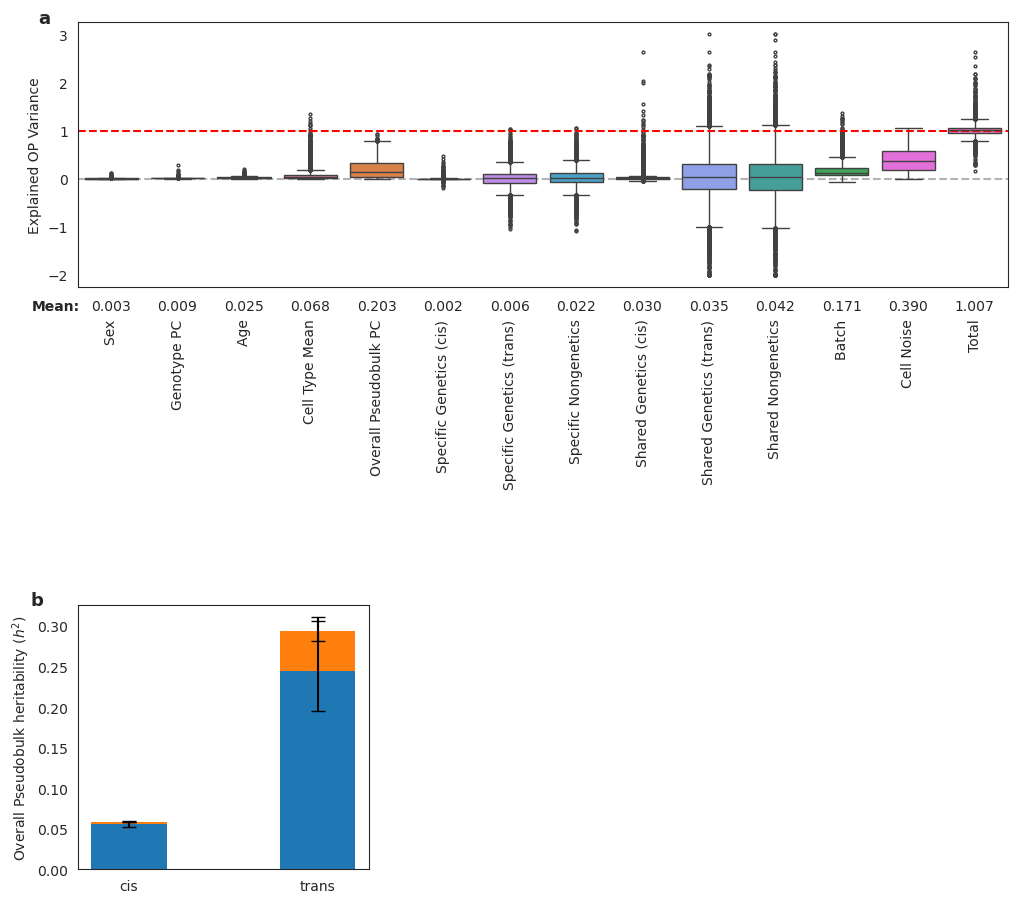

In [48]:
trans_fixed = ['Cell Type Mean', 'Overall Pseudobulk PC', 'Sex', 'Age', 'Genotype PC']
trans_random = ['Batch', 'Shared Genetics (cis)', 'Shared Nongenetics', 'Specific Genetics (cis)', 
                'Specific Nongenetics', 'Shared Genetics (trans)', 'Specific Genetics (trans)', 'Cell Noise']
trans_variances = trans_fixed + trans_random + ['Total']
trans_op_var_df = trans_op_df[trans_variances]
trans_means = trans_op_var_df.mean()
trans_orders = trans_means.sort_values().index.to_numpy()
trans_orders = trans_orders[np.isin(trans_orders, trans_fixed)].tolist() + trans_orders[~np.isin(trans_orders, trans_fixed)].tolist()

# plot
fig = plt.figure(1, figsize=(12, 11))
gs = gridspec.GridSpec(3, 3, wspace=.1, hspace=.1)

ax = fig.add_subplot(gs[:1, :])

sns.boxplot(data=trans_op_var_df.clip(-2, 3), ax=ax, fliersize=2, order=trans_orders)

ax.axhline(y=1, color='r', linestyle='--')
ax.axhline(y=0, color='.7', linestyle='--', zorder=0)

# move x labels down
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f'{label.get_text()}     ' for label in ax.get_xticklabels()])
# add means
y = -2.8
ax.text(-1.2, y, 'Mean:', fontweight='bold', va='bottom')
for x, mean in zip(ax.get_xticks(), trans_means[trans_orders]):
    ax.text(x, y, f'{mean:.3f}', ha='center', va='bottom')

# ax.set_xlabel('Component')
ax.set_ylabel('Explained OP Variance')

ax.tick_params(axis='x', rotation=90)
ax.text(-0.03, 1.05, 'a', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

# plot proportion of h2
width = .4
labels = ['cis', 'trans']
ax = fig.add_subplot(gs[2, 0])

bottom = np.zeros(2)
values = np.array([median_shared_h2_cis, median_shared_h2_trans]) 
ci = np.array([median_shared_h2_cis_ci, median_shared_h2_trans_ci]) 
yerr = np.abs(ci - values[:, np.newaxis])
print(yerr)

ax.bar(labels, values, width, yerr=yerr.T, capsize=5,
    bottom=bottom, color=colors[0], edgecolor='none', label='Shared')

bottom += [median_shared_h2_cis, median_shared_h2_trans]
values = np.array([median_specific_h2_cis, median_specific_h2_trans])
print(bottom, values)
ci = np.array([median_specific_h2_cis_ci, median_specific_h2_trans_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, width, yerr=yerr.T, capsize=5,
        bottom=bottom, color=colors[1], edgecolor='none', label='Specific')

ax.set_ylabel('Overall Pseudobulk heritability ($h^2$)')
ax.text(-0.12, 1.05, 'b', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


fig.tight_layout()

# Rare variants

In [49]:
rare_maf1_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.maf0.01.jk.npy'
rare_maf2_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.maf1e-10.jk.npy'

rare_maf1 = np.load(rare_maf1_f, allow_pickle=True).item()
rare_maf2 = np.load(rare_maf2_f, allow_pickle=True).item()

rare_jk_df = util.read_out(jk, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
rare_maf1_df = util.read_out(rare_maf1, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
rare_maf2_df = util.read_out(rare_maf2, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])

# merge dataframes
df1 = rare_jk_df.merge(rare_maf1_df, on='gene', suffixes=('', '_maf1'))
df = df1.merge(rare_maf2_df, on='gene', suffixes=('', '_maf2'))

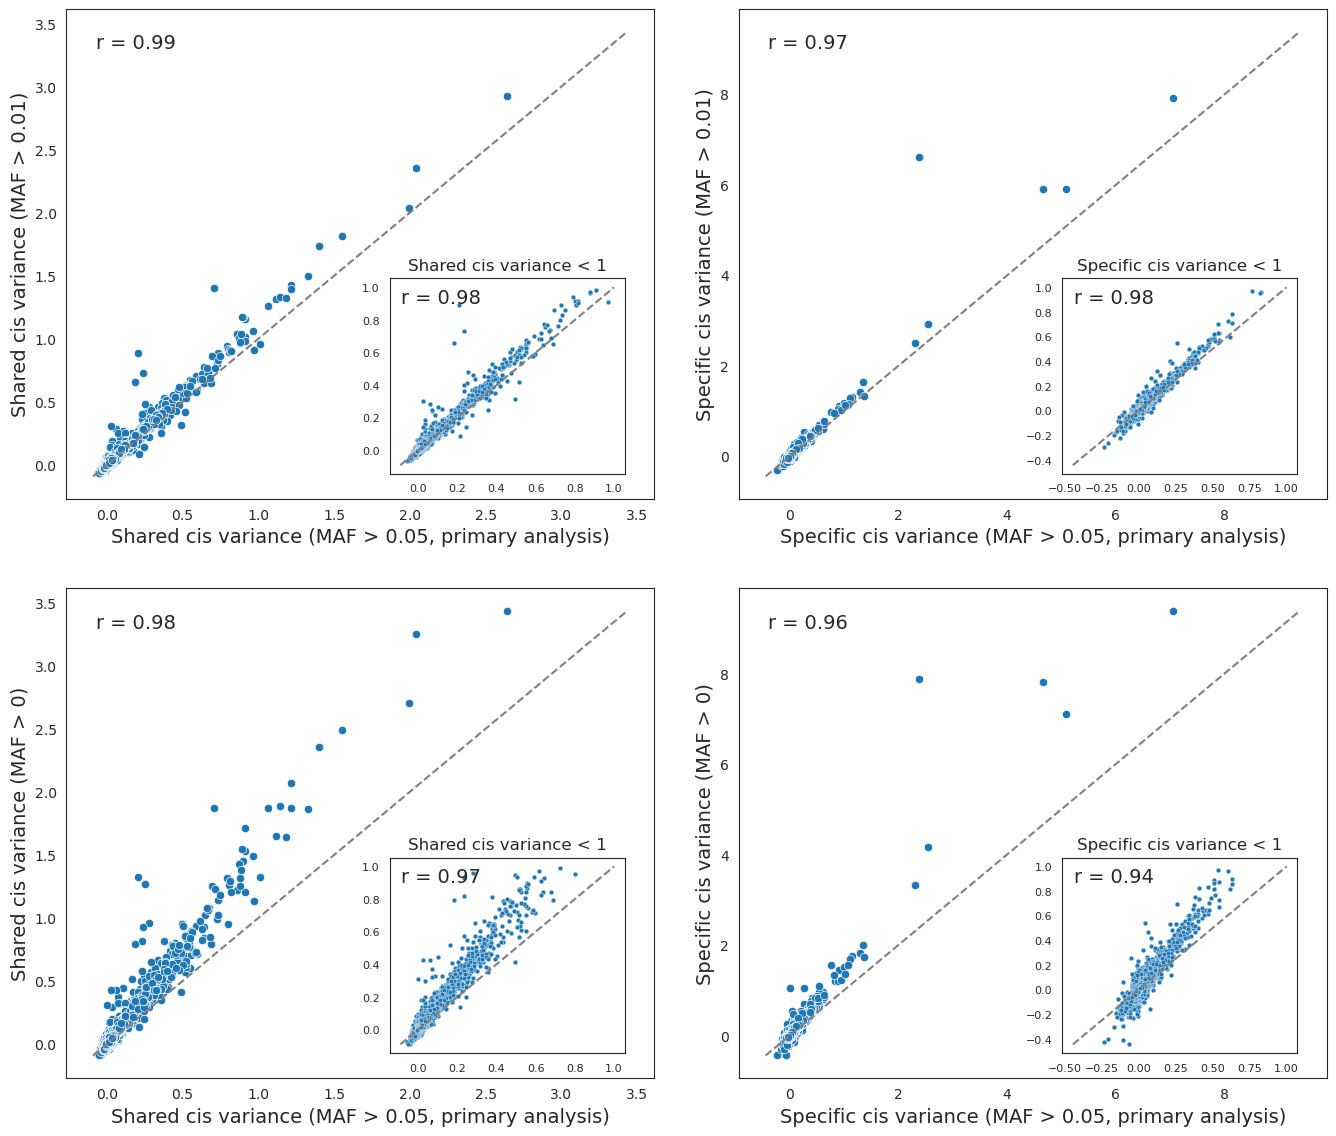

In [50]:
# restrict data for plotting
hom_g2_cut = 1
v_cut = 1
df1_hom_g2 = df[(df['free:hom_g2'] < hom_g2_cut) & (df['free:hom_g2_maf1'] < hom_g2_cut)]
df2_hom_g2 = df[(df['free:hom_g2'] < hom_g2_cut) & (df['free:hom_g2_maf2'] < hom_g2_cut)]
df1_V = df[(df['free:v'] < v_cut) & (df['free:v_maf1'] < v_cut)]
df2_V = df[(df['free:v'] < v_cut) & (df['free:v_maf2'] < v_cut)]

# define min/max for plotting
min_hom_g2 = min(df['free:hom_g2'].min(), df['free:hom_g2_maf1'].min(), df['free:hom_g2_maf2'].min())
max_hom_g2 = max(df['free:hom_g2'].max(), df['free:hom_g2_maf1'].max(), df['free:hom_g2_maf2'].max())
min_hom_g2_r = min_hom_g2
# max_hom_g2_r = max(df_hom_g2['free:hom_g2'].max(), df_hom_g2['free:hom_g2_maf1'].max(), df_hom_g2['free:hom_g2_maf2'].max())
max_hom_g2_r = hom_g2_cut
min_V = min(df['free:v'].min(), df['free:v_maf1'].min(), df['free:v_maf2'].min())
max_V = max(df['free:v'].max(), df['free:v_maf1'].max(), df['free:v_maf2'].max())
min_V_r = min_V
# min_V_r = min(df_V['free:v'].min(), df_V['free:v_maf1'].min(), df_V['free:v_maf2'].min())
# max_V_r = max(df_V['free:v'].max(), df_V['free:v_maf1'].max(), df_V['free:v_maf2'].max())
max_V_r = v_cut

# Calculate correlations
corr1_hom_g2 = df['free:hom_g2'].corr(df['free:hom_g2_maf1'])
corr1_V = df['free:v'].corr(df['free:v_maf1'])
corr1_hom_g2_restricted = df1_hom_g2['free:hom_g2'].corr(df1_hom_g2['free:hom_g2_maf1'])
corr1_V_restricted = df1_V['free:v'].corr(df1_V['free:v_maf1'])
corr2_hom_g2 = df['free:hom_g2'].corr(df['free:hom_g2_maf2'])
corr2_V = df['free:v'].corr(df['free:v_maf2'])
corr2_hom_g2_restricted = df2_hom_g2['free:hom_g2'].corr(df2_hom_g2['free:hom_g2_maf2'])
corr2_V_restricted = df2_V['free:v'].corr(df2_V['free:v_maf2'])

# plot free:hom_g2 vs free:hom_g2_maf1 and free:V vs free:V_maf1
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
label_size = 14

# All data: free:hom_g2 vs free:hom_g2_maf1
sns.scatterplot(x='free:hom_g2', y='free:hom_g2_maf1', data=df, ax=axes[0, 0])
axes[0, 0].text(0.05, 0.95, f'r = {corr1_hom_g2:.2f}', transform=axes[0, 0].transAxes, fontsize=label_size, verticalalignment='top', ha='left')
axes[0, 0].set_xlabel('Shared cis variance (MAF > 0.05, primary analysis)', fontsize=label_size)
axes[0, 0].set_ylabel('Shared cis variance (MAF > 0.01)', fontsize=label_size)
axes[0, 0].plot([min_hom_g2, max_hom_g2], [min_hom_g2, max_hom_g2], ls='--', color='gray')

# Inset for restricted data: free:hom_g2 vs free:hom_g2_maf1
inset_hom_g2_1 = axes[0, 0].inset_axes([0.55, 0.05, 0.4, 0.4])
sns.scatterplot(x='free:hom_g2', y='free:hom_g2_maf1', data=df1_hom_g2, ax=inset_hom_g2_1, s=12)
inset_hom_g2_1.set_title(f'Shared cis variance < {hom_g2_cut}', fontsize=12)
inset_hom_g2_1.text(0.05, 0.95, f'r = {corr1_hom_g2_restricted:.2f}', transform=inset_hom_g2_1.transAxes, fontsize=label_size, verticalalignment='top', ha='left')
inset_hom_g2_1.plot([min_hom_g2_r, max_hom_g2_r], [min_hom_g2_r, max_hom_g2_r], ls='--', color='gray')
inset_hom_g2_1.tick_params(labelsize=8)
inset_hom_g2_1.set_xlabel('')
inset_hom_g2_1.set_ylabel('')

# All data: free:V vs free:V_maf1
sns.scatterplot(x='free:v', y='free:v_maf1', data=df, ax=axes[0, 1])
axes[0, 1].text(0.05, 0.95, f'r = {corr1_V:.2f}', transform=axes[0, 1].transAxes, fontsize=label_size, verticalalignment='top', ha='left')
axes[0, 1].set_xlabel('Specific cis variance (MAF > 0.05, primary analysis)', fontsize=label_size)
axes[0, 1].set_ylabel('Specific cis variance (MAF > 0.01)', fontsize=label_size)
axes[0, 1].plot([min_V, max_V], [min_V, max_V], ls='--', color='gray')

# Inset for restricted data: free:V vs free:V_maf1
inset_V_1 = axes[0, 1].inset_axes([0.55, 0.05, 0.4, 0.4])
sns.scatterplot(x='free:v', y='free:v_maf1', data=df1_V, ax=inset_V_1, s=12)
inset_V_1.set_title(f'Specific cis variance < {v_cut}', fontsize=12)
inset_V_1.text(0.05, 0.95, f'r = {corr1_V_restricted:.2f}', transform=inset_V_1.transAxes, fontsize=label_size, verticalalignment='top', ha='left')
inset_V_1.plot([min_V_r, max_V_r], [min_V_r, max_V_r], ls='--', color='gray')
inset_V_1.tick_params(labelsize=8)
inset_V_1.set_xlabel('')
inset_V_1.set_ylabel('')


# All data: free:hom_g2 vs free:hom_g2_maf2
sns.scatterplot(x='free:hom_g2', y='free:hom_g2_maf2', data=df, ax=axes[1, 0])
axes[1, 0].text(0.05, 0.95, f'r = {corr2_hom_g2:.2f}', transform=axes[1, 0].transAxes, fontsize=label_size, verticalalignment='top', ha='left')
axes[1, 0].set_xlabel('Shared cis variance (MAF > 0.05, primary analysis)', fontsize=label_size)
axes[1, 0].set_ylabel('Shared cis variance (MAF > 0)', fontsize=label_size)
axes[1, 0].plot([min_hom_g2, max_hom_g2], [min_hom_g2, max_hom_g2], ls='--', color='gray')

# Inset for restricted data: free:hom_g2 vs free:hom_g2_maf2
inset_hom_g2_2 = axes[1, 0].inset_axes([0.55, 0.05, 0.4, 0.4])
sns.scatterplot(x='free:hom_g2', y='free:hom_g2_maf2', data=df2_hom_g2, ax=inset_hom_g2_2, s=12)
inset_hom_g2_2.set_title(f'Shared cis variance < {hom_g2_cut}', fontsize=12)
inset_hom_g2_2.text(0.05, 0.95, f'r = {corr2_hom_g2_restricted:.2f}', transform=inset_hom_g2_2.transAxes, fontsize=label_size, verticalalignment='top', ha='left')
inset_hom_g2_2.plot([min_hom_g2_r, max_hom_g2_r], [min_hom_g2_r, max_hom_g2_r], ls='--', color='gray')
inset_hom_g2_2.tick_params(labelsize=8)
inset_hom_g2_2.set_xlabel('')
inset_hom_g2_2.set_ylabel('')

# All data: free:V vs free:V_maf2
sns.scatterplot(x='free:v', y='free:v_maf2', data=df, ax=axes[1, 1])
axes[1, 1].text(0.05, 0.95, f'r = {corr2_V:.2f}', transform=axes[1, 1].transAxes, fontsize=label_size, verticalalignment='top', ha='left')
axes[1, 1].set_xlabel('Specific cis variance (MAF > 0.05, primary analysis)', fontsize=label_size)
axes[1, 1].set_ylabel('Specific cis variance (MAF > 0)', fontsize=label_size)
axes[1, 1].plot([min_V, max_V], [min_V, max_V], ls='--', color='gray')

# Inset for restricted data: free:V vs free:V_maf2
inset_V_2 = axes[1, 1].inset_axes([0.55, 0.05, 0.4, 0.4])
sns.scatterplot(x='free:v', y='free:v_maf2', data=df2_V, ax=inset_V_2, s=12)
inset_V_2.set_title(f'Specific cis variance < {v_cut}', fontsize=12)
inset_V_2.text(0.05, 0.95, f'r = {corr2_V_restricted:.2f}', transform=inset_V_2.transAxes, fontsize=label_size, verticalalignment='top', ha='left')
inset_V_2.plot([min_V_r, max_V_r], [min_V_r, max_V_r], ls='--', color='gray')
inset_V_2.tick_params(labelsize=8)
inset_V_2.set_xlabel('')
inset_V_2.set_ylabel('')

plt.tight_layout(pad=3)
plt.show()

In [51]:
# calculate heritability
df['t'] = df[['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w']].sum(axis=1)
df['t_maf1'] = df[['free:hom_g2_maf1', 'free:v_maf1', 'free:hom_e2_maf1', 'free:w_maf1']].sum(axis=1)
df['t_maf2'] = df[['free:hom_g2_maf2', 'free:v_maf2', 'free:hom_e2_maf2', 'free:w_maf2']].sum(axis=1)
df['h2'] = (df['free:hom_g2'] + df['free:v']) / df['t']
df['h2_maf1'] = (df['free:hom_g2_maf1'] + df['free:v_maf1']) / df['t_maf1']
df['h2_maf2'] = (df['free:hom_g2_maf2'] + df['free:v_maf2']) / df['t_maf2']
tmp_df = df[(df['t'] > 0) & (df['t_maf1'] > 0) & (df['t_maf2'] > 0)]
print('Number of genes with positive total variance:', tmp_df.shape)
print('Median heritability:', df['h2'].median())
print('Median heritability (maf1):', df['h2_maf1'].median())
print('Median heritability (maf2):', df['h2_maf2'].median())

# calculate specificity
df['free:specificity'] = df['free:v'] / (df['free:hom_g2'] + df['free:v'])
df['free:specificity_maf1'] = df['free:v_maf1'] / (df['free:hom_g2_maf1'] + df['free:v_maf1'])
df['free:specificity_maf2'] = df['free:v_maf2'] / (df['free:hom_g2_maf2'] + df['free:v_maf2'])
print(df.shape)
tmp_data = df[((df['free:v'] + df['free:hom_g2']) > 0) & ((df['free:v_maf1'] + df['free:hom_g2_maf1']) > 0) & ((df['free:v_maf2'] + df['free:hom_g2_maf2']) > 0)]
print(tmp_data.shape)
# calculate mean, median of shared_h2, specific_h2, specificity
print(tmp_data[['free:shared_h2', 'free:specific_h2', 'free:specificity',
            'free:shared_h2_maf1', 'free:specific_h2_maf1', 'free:specificity_maf1',
            'free:shared_h2_maf2', 'free:specific_h2_maf2', 'free:specificity_maf2']].describe().loc[['mean', '50%']])

Number of genes with positive total variance: (9036, 25)
Median heritability: 0.03649093382960621
Median heritability (maf1): 0.04786044049319091
Median heritability (maf2): 0.06401372134307332
(10288, 28)
(6542, 28)
      free:shared_h2  free:specific_h2  free:specificity  free:shared_h2_maf1  \
mean        0.533194          0.172117          0.252194             0.183237   
50%         0.038878          0.029616          0.429225             0.050129   

      free:specific_h2_maf1  free:specificity_maf1  free:shared_h2_maf2  \
mean               0.024751               0.456793            -1.460413   
50%                0.036145               0.429690             0.069666   

      free:specific_h2_maf2  free:specificity_maf2  
mean              -1.350215               0.416170  
50%                0.050110               0.432588  


## Joint fitting rare and common

10287 3215 7072
0.40543575655777736 0.7198452224891791


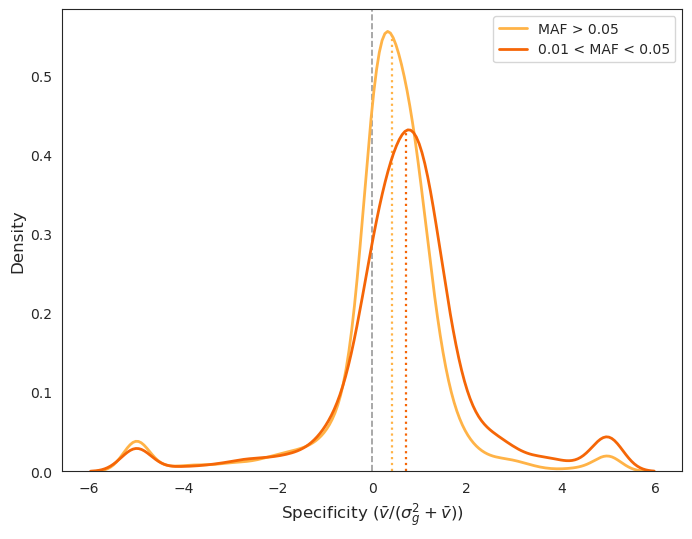

[2025-11-12 14:19:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:19:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(3132, 14)


[2025-11-12 14:19:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:19:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:19:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:19:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-12 14:19:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

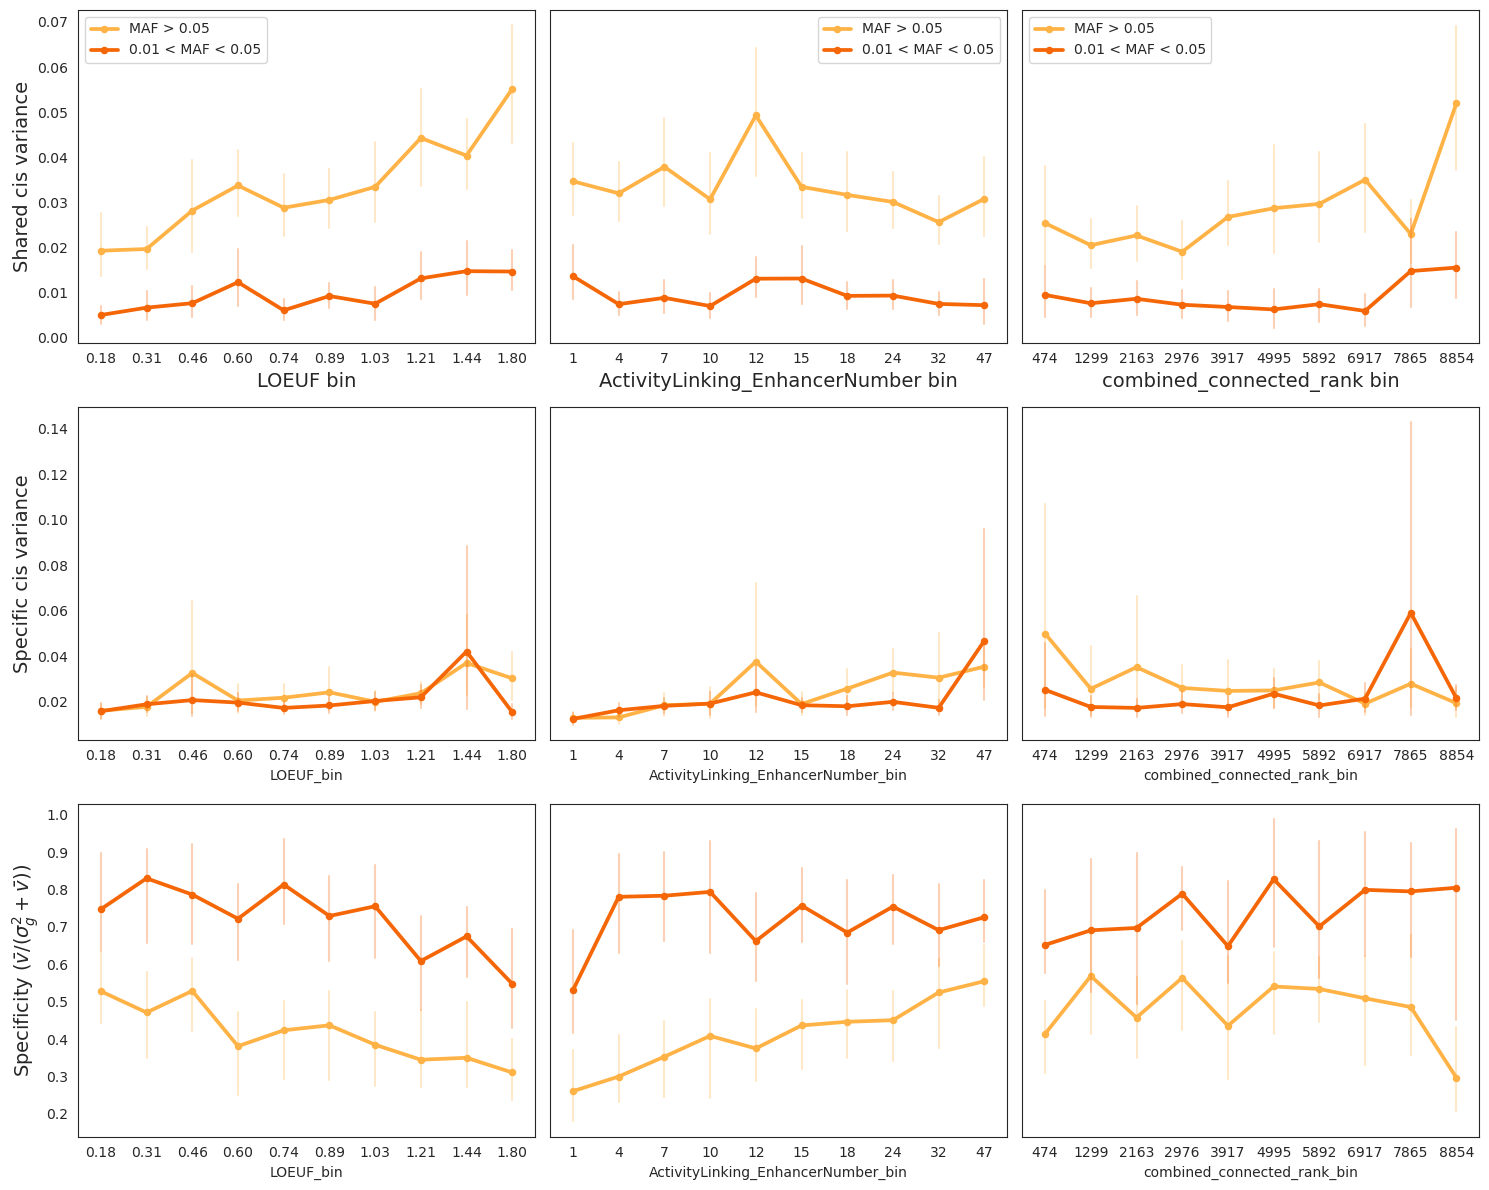

In [52]:
# Distribution of specificity and specificity_b
filtered_df = joint_rare_df[(joint_rare_df['free:g'] > 0) & (joint_rare_df['free:g_b'] > 0)].copy()
print(joint_rare_df.shape[0], filtered_df.shape[0], joint_rare_df.shape[0] - filtered_df.shape[0])

# Clip outliers for specificity and specificity_b for plot
spec_q1 = -5
spec_q3 = 5
x1 = filtered_df['specificity'].clip(lower=spec_q1, upper=spec_q3)
y1 = filtered_df['specificity_b'].clip(lower=spec_q1, upper=spec_q3)

fs = 12
alpha = 0.3

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(x=x1, label='MAF > 0.05', fill=False, color='#ffb347', lw=2)
sns.kdeplot(x=y1, label='0.01 < MAF < 0.05', fill=False, color="#f56607", lw=2)

# Add median lines
median_spec = x1.median()
median_spec_b = y1.median()
print(median_spec, median_spec_b)
kde_x, kde_y = ax.lines[0].get_data()
y_at_median = np.interp(median_spec, kde_x, kde_y)
ax.vlines(median_spec, 0, y_at_median, color='#ffb347', linestyle=':', lw=1.6, zorder=0)
kde_x, kde_y = ax.lines[1].get_data()
y_at_median = np.interp(median_spec_b, kde_x, kde_y)
ax.vlines(median_spec_b, 0, y_at_median, color='#f56607', linestyle=':', lw=1.6, zorder=0)


# add line x = 0
plt.axvline(0, color='0.6', linestyle='--', zorder=0, lw=1.2)
plt.xlabel(r'Specificity ($\bar{v} / (\sigma_g^2 + \bar{v})$)', fontsize=fs)
plt.ylabel('Density', fontsize=fs)
plt.legend()
plt.show()


# stratify by LOEUF
eds_f = '../../analysis/yazar/eds.txt'
# location_f = '../../data/Yazar2022Science/gene_location.txt'
eds_df = pd.read_csv(eds_f, sep='\t')
# location = pd.read_table(location_f)
# location['gene_length'] = location['end'] - location['start']
# eds = eds.drop('gene_length', axis=1)
# eds = eds.merge(location[['feature', 'gene_length']], left_on='gene_id', right_on='feature')
# eds = eds.drop('feature', axis=1)
# eds['gene_length (kb)'] = eds['gene_length'] / 1e3
eds_df = eds_df.rename(columns={'gene_id': 'gene'})
eds_df = eds_df[['gene', 'LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']]
merged_df = filtered_df.merge(eds_df, on='gene')
filter = merged_df[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
merged_df = merged_df.loc[~filter]
print(merged_df.shape)


fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey='row')
for i, annotation in zip(range(3), ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']):
    merged_df = plot.bin_gene_annotation(merged_df, annotation, 10)
    # print(merged_df.head())
    # bin_specificity_median = merged_df.groupby('LOEUF_bin')[['specificity', 'specificity_b']].median()
    # print(bin_specificity_median['specificity_b'] - bin_specificity_median['specificity'])

    # line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    # pointplot
    melt_df = merged_df.melt(id_vars=[f'{annotation}_bin'], value_vars=['free:hom_g2', 'free:hom_g2_b'],
                            var_name='specificity_type', value_name='specificity_value')
    sns.pointplot(data=melt_df, x=f'{annotation}_bin', y='specificity_value', hue='specificity_type', palette=["#ffb347", "#f56607"],
            err_kws={'alpha': alpha, 'linewidth': 1.5}, markers='.', estimator='mean', linestyles='-', ax=axes[0, i])
    melt_df = merged_df.melt(id_vars=[f'{annotation}_bin'], value_vars=['free:v', 'free:v_b'],
                            var_name='specificity_type', value_name='specificity_value')
    sns.pointplot(data=melt_df, x=f'{annotation}_bin', y='specificity_value', hue='specificity_type', palette=["#ffb347", "#f56607"],
            err_kws={'alpha': alpha, 'linewidth': 1.5}, markers='.', estimator='mean', linestyles='-', ax=axes[1, i])
    melt_df = merged_df.melt(id_vars=[f'{annotation}_bin'], value_vars=['specificity', 'specificity_b'],
                            var_name='specificity_type', value_name='specificity_value')
    sns.pointplot(data=melt_df, x=f'{annotation}_bin', y='specificity_value', hue='specificity_type', palette=["#ffb347", "#f56607"],
            err_kws={'alpha': alpha, 'linewidth': 1.5}, markers='.', estimator='median', linestyles='-', ax=axes[2, i])
    # modify legend
    handles, labels = axes[0, i].get_legend_handles_labels()
    labels = ['MAF > 0.05', '0.01 < MAF < 0.05']
    axes[0, i].legend(handles, labels, title=None, fontsize=fs-2, title_fontsize=fs-2)
    axes[0, i].set_xlabel(f'{annotation} bin', fontsize=fs+2)
    axes[1, i].get_legend().remove()
    axes[2, i].get_legend().remove()

axes[0, 0].set_ylabel('Shared cis variance', fontsize=fs+2)
axes[1, 0].set_ylabel('Specific cis variance', fontsize=fs+2)
axes[2, 0].set_ylabel(r'Specificity ($\bar{v} / (\sigma_g^2 + \bar{v})$)', fontsize=fs+2)
fig.tight_layout()

2857
[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5  10. ]


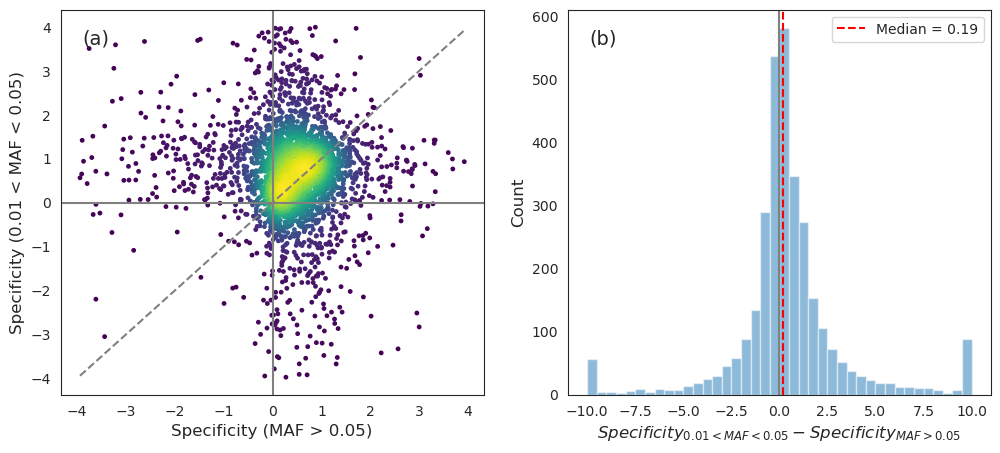

/home/minhuic/programs/anaconda3/envs/gxct/lib/python3.11/site-packages/scipy/stats/_resampling.py:1467: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


std of null distribution (specificity): 0.014157631310185608
std of null distribution (specificity_b): 0.021871316865451615
median specificity: 0.40543575655777736 0.7198452224891791
0.3144094659314018 0.002


/home/minhuic/programs/anaconda3/envs/gxct/lib/python3.11/site-packages/scipy/stats/_resampling.py:1467: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


0.19102961582617328 0.001


In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter plot of specificity vs specificity_b
filter = (filtered_df['specificity'] > -4) & (filtered_df['specificity'] < 4) & (filtered_df['specificity_b'] > -4) & (filtered_df['specificity_b'] < 4)
print(filter.sum())
x2 = filtered_df.loc[filter, 'specificity']
y2 = filtered_df.loc[filter, 'specificity_b']

# Sort the points by density, so that the densest points are plotted on top
xy = np.vstack([x2, y2])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x2, y2, z = x2.iloc[idx], y2.iloc[idx], z[idx]

axes[0].scatter(x2, y2, c=z, s=6, cmap='viridis')

axes[0].set_xlabel('Specificity (MAF > 0.05)', fontsize=12)
axes[0].set_ylabel('Specificity (0.01 < MAF < 0.05)', fontsize=12)
axes[0].axhline(0, color='gray', linestyle='-')
axes[0].axvline(0, color='gray', linestyle='-')
axes[0].plot([x2.min(), x2.max()], [x2.min(), x2.max()], color='gray', linestyle='--', label='y = x')
axes[0].text(0.05, 0.95, '(a)', transform=axes[0].transAxes, fontsize=14, verticalalignment='top', ha='left')
# add Pearson correlation annotation
# r, p = stats.pearsonr(x, y)
# print(r, p)
# plt.text(0.05, 0.95, f'r = {r:.2f} (p = {p:.2g})', transform=plt.gca().transAxes,
        #  ha='left', va='top', fontsize=12)


# histograms for specificity - specificity_b
diff = filtered_df['specificity_b'] - filtered_df['specificity']
diff = np.clip(diff, -10, 10)
diff_min, diff_max = diff.min(), diff.max()
bins = np.arange(np.floor(diff_min), np.ceil(diff_max) + 0.5, 0.5)
print(bins)
axes[1].hist(diff, bins=bins, alpha=0.5)
axes[1].axvline(0, color='gray', linestyle='-')
axes[1].axvline(np.median(diff), color='red', linestyle='--', label=f'Median = {np.median(diff):.2f}')
axes[1].set_xlabel(r'$Specificity_{0.01 < MAF < 0.05} - Specificity_{MAF > 0.05}$', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend()
axes[1].text(0.05, 0.95, '(b)', transform=axes[1].transAxes, fontsize=14, verticalalignment='top', ha='left')
plt.show()

# # t-test
# t_stat, p_value = stats.ttest_rel(filtered_df['specificity_b'], filtered_df['specificity'], alternative='greater')
# print('t-statistic:', t_stat)
# print('p-value:', p_value)
# # wilcoxon test
# w_stat, p_value_w = stats.wilcoxon(filtered_df['specificity_b'], filtered_df['specificity'], alternative='greater')
# print('Wilcoxon statistic:', w_stat)
# print('Wilcoxon p-value:', p_value_w)

# permutation to test if median_spec_b > median_spec
res = stats.permutation_test((filtered_df['specificity'], ), 
                             permutation_type='samples', vectorized=False,
                             statistic=lambda x: np.median(x), 
                             alternative='two-sided', n_resamples=999, random_state=123)
print('std of null distribution (specificity):', np.std(res.null_distribution, ddof=1))

res = stats.permutation_test((filtered_df['specificity_b'], ), 
                             permutation_type='samples', vectorized=False,
                             statistic=lambda x: np.median(x), 
                             alternative='two-sided', n_resamples=999, random_state=123)
print('std of null distribution (specificity_b):', np.std(res.null_distribution, ddof=1))

res = stats.permutation_test((filtered_df['specificity'], filtered_df['specificity_b']), 
                             permutation_type='samples', vectorized=False,
                             statistic=lambda x, y: np.median(y) - np.median(x), 
                             alternative='two-sided', n_resamples=999, random_state=123)
print('median specificity:', filtered_df['specificity'].median(), filtered_df['specificity_b'].median())
print(res.statistic, res.pvalue)

# permutation to test median_spec_b - median_spec
res = stats.permutation_test((filtered_df['specificity'], filtered_df['specificity_b']), 
                             permutation_type='samples', vectorized=False,
                             statistic=lambda x, y: np.median(y - x), 
                             alternative='greater', n_resamples=999, random_state=123)
print(res.statistic, res.pvalue)